# Dynamic Network Graph Exploration 

Explore interactive design and parameters combo to better detect adn define interactions between members. 

Code credits - Yumeng Xi
CHanged based on the original code provided by Xavier Lambein

# Notebook Requirements 

In [1]:
import os, sys
import logging
import gzip

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

# Import the data analysis tools
import openbadge_analysis as ob
import openbadge_analysis.preprocessing
import openbadge_analysis.core

SELECTED_BEACON = 12

In [2]:
ob.__version__

'0.4.4'

# Settings
The time_zone variable will be used when converting the timestamp form UTC time to your local time.

In [3]:
time_zone = 'US/Eastern'
log_version = '2.0'
time_bins_size = '1min'

proximity_data_filenames = []

for i in range(1, 18):
    if i < 10:
        filename = 'CTSIserver{:02d}_proximity_2019-06-01.txt'.format(i)
    else:
        filename = 'CTSIserver{}_proximity_2019-06-01.txt'.format(i)
        
    proximity_data_filenames.append(filename)
    
attendees_metadata_filename = "Badge assignments_Attendees_2019.xlsx"
members_metadata_filename = "Member-2019-05-28.csv"
beacons_metadata_filename = "location table.xlsx"
data_dir = "../proximity_2019-06-01/"

# Pre-processing

First, we load two lists that will help us with some of the analysis: list of membmers and list of location beacons

In [6]:
members_metadata = pd.read_csv(data_dir+members_metadata_filename)
beacons_metadata = pd.read_excel(data_dir+beacons_metadata_filename, sheet_name='Sheet1')


## beacons_metadata

We create a translation table between the badge ID and member key. This is done based on the data itself, since it should contain data from all the badges that take part in the study. 

Note that we create a <id,member key> pair for ever time bin. While this is not necessary at this point, it allows this mapping to change (for example, if a badge is re-assigned to a different member).

In [7]:
idmaps = []

for proximity_data_filename in proximity_data_filenames:
    with open(os.path.join(data_dir, proximity_data_filename), 'r') as f:
        idmaps.append(ob.preprocessing.id_to_member_mapping(f, time_bins_size, tz=time_zone))
        
tmp_idmaps = idmaps[0]
for i in range(1, len(idmaps)):
    tmp_idmaps = pd.concat([tmp_idmaps, idmaps[i]])

In [8]:
tmp_idmaps.shape

(414366L,)

Using this translation table and the proximity data, we can create a list of "pings" - every time two badges were in close proximity

In [9]:
m2badges = []

for proximity_data_filename in proximity_data_filenames:
    with open(os.path.join(data_dir, proximity_data_filename), 'r') as f:
        m2badges.append(ob.preprocessing.member_to_badge_proximity(f, time_bins_size, tz=time_zone))
        
tmp_m2badges = m2badges[0]

for i in range(1, len(m2badges)):
    tmp_m2badges = pd.concat([tmp_m2badges, m2badges[i]])

In [10]:
tmp_m2badges.shape

(4593629, 2)

Since a badge can either be a badge worn by a participant, or a location beacon, we split the dataset into member-to-member (for network graphs) and member-to-beacon (for localization)

In [11]:
# Member to member
m2ms = []
for (m2badge, idmap) in zip(m2badges, idmaps):
    m2ms.append(ob.preprocessing.member_to_member_proximity(m2badge, idmap))

tmp_m2ms = m2ms[0]
for i in range(1, len(m2ms)):
    tmp_m2ms = pd.concat([tmp_m2ms, m2ms[i]])

In [12]:
tmp_m2ms.shape

(1616926, 4)

In [13]:
# Member to location beacon
m2bs = []
for m2badge in m2badges:
    m2bs.append(ob.preprocessing.member_to_beacon_proximity(m2badge, beacons_metadata.set_index('id')['beacon']))
    
tmp_m2bs = m2bs[0]
for i in range(1, len(m2bs)):
    tmp_m2bs = pd.concat([tmp_m2bs, m2bs[i]])

In [26]:
# match the badge ID in attendee data with the name in members 
attendees_metadata_filename = "Badge assignments_Attendees_2019.xlsx"
attendees_metadata = pd.read_excel(data_dir+attendees_metadata_filename)
attend_id = attendees_metadata['BADGE #'].values.astype('str').tolist()
member_id = members_metadata['name'].values.astype('str').tolist()
drop_member = []
for i in member_id:
    if i not in attend_id:
        drop_member.append(i)
drop_name = []
key_name = members_metadata['member'].values.astype('str').tolist()
value_id = members_metadata['name'].values.astype('str').tolist()
dic_name_id = dict(zip(key_name,value_id))
for i in dic_name_id:
    if dic_name_id[i] in drop_member:
        drop_name.append(i)

# delete the member to member records which does not have attendee information
drop_index = []
tmp_m2ms = tmp_m2ms.reset_index()
for index,row in tmp_m2ms.iterrows():
    if row['member1'] in drop_name:
        drop_index.append(index)
    elif row['member2'] in drop_name:
        drop_index.append(index)

tmp_m2ms = tmp_m2ms.drop(drop_index)
tmp_m2ms = tmp_m2ms.set_index(['datetime'])

# Network Graph Preparation 
Run every block in under this title to prepare for all Dynamic Network Member Graph analysis

In [14]:
# create time slices
def generate_time_slices(start_h, start_m, end_h, end_m, interval=2):
    
    time_slices = []
    
    start = '2019-06-01 {:02}:{:02}'.format(start_h, start_m)
    duration = (end_h - start_h) * 60 + (end_m - start_m)
    
    for i in range(duration/interval+1):
        
        if start_h > end_h:
            break
        elif start_h == end_h:
            if start_m > end_m:
                break
            
        tmp_h = start_h
        tmp_m = start_m
        
        if tmp_m < 60-interval+1:
            tmp_m += interval-1
        else:
            tmp_h += 1
            if interval > 1:
                tmp_m = tmp_m - 60 + interval-1
            else:
                tmp_m = tmp_m - 60 + interval
            
        tmp_time = '2019-06-01 {:02}:{:02}'.format(tmp_h, tmp_m)
        
        time_slices.append(slice(start, tmp_time))
        
        start_h = tmp_h
        start_m = tmp_m
        
        if start_m == 59:
            start_h += 1
            start_m = 0
        else:
            start_m += 1
        
        start = '2019-06-01 {:02}:{:02}'.format(start_h, start_m)
    return time_slices

In [16]:
# create time slices
def generate_time_points(start_h, start_m, end_h, end_m, interval=2):
    time_points = []
    tmp_time = '2019-06-01 {:02}:{:02}'.format(start_h, start_m)
    duration = (end_h - start_h) * 60 + (end_m - start_m)
    start_m=start_m-1
    for i in range(duration/interval+1):
        if start_m < 60-interval:
            start_m += interval
        else:
            start_h += 1
            start_m = start_m - 60 + interval
        tmp_time = '2019-06-01 {:02}:{:02}'.format(start_h, start_m)
        if start_h>=end_h and start_m>=end_m:
            tmp_time = '2019-06-01 {:02}:{:02}'.format(end_h, end_m)
            time_points.append(tmp_time)
            break
        time_points.append(tmp_time)
        
    return time_points



In [17]:
tmp_m2ms_sorted = tmp_m2ms.sort_index(0,0)

In [18]:
def draw_graph(G, graph_layout='shell',
               node_size=600, node_color='blue', node_alpha=0.3,
               node_text_size=8,
               edge_color='blue', edge_alpha=0.3, edge_tickness=1,
               edge_text_pos=0.3,
               text_font='sans-serif'):

    # these are different layouts for the network you may try
    # shell seems to work best
    if graph_layout == 'spring':
        graph_pos=nx.spring_layout(G)
    elif graph_layout == 'spectral':
        graph_pos=nx.spectral_layout(G)
    elif graph_layout == 'random':
        graph_pos=nx.random_layout(G)
    else:
        graph_pos=nx.shell_layout(G)

    # draw graph
    nx.draw_networkx_nodes(G,graph_pos,node_size=node_size, 
                           alpha=node_alpha, node_color=node_color, cmap=plt.get_cmap('jet'))
    nx.draw_networkx_edges(G,graph_pos,width=edge_tickness,
                           alpha=edge_alpha,edge_color=edge_color)
    nx.draw_networkx_labels(G, graph_pos,font_size=node_text_size,
                            font_family=text_font)

    plt.show()


# Network Graph Basic Example
This trunk is only for demonstration, not for analysis. 

In [51]:
# Filter data from specific time period

time_slice = slice('2019-06-01 10:00', '2019-06-01 11:20')
m2m_breakout = tmp_m2ms_sorted.loc[time_slice]

# keep only instances with strong signal
m2m_filter_rssi = m2m_breakout[m2m_breakout.rssi >= -70].copy()
print(len(m2m_filter_rssi))

34230


In [52]:
# Count number of time members were in close proximity
# We name the count column "weight" so that networkx will use it as weight for the spring layout
m2m_edges = m2m_filter_rssi.groupby(['member1', 'member2'])[['rssi_weighted_mean']].count().rename(columns={'rssi_weighted_mean':'weight'})
m2m_edges = m2m_edges[["weight"]].reset_index()

# Keep strongest edges (threshold set manually)
m2m_edges = m2m_edges[m2m_edges.weight > 15]
print(len(m2m_edges))


516


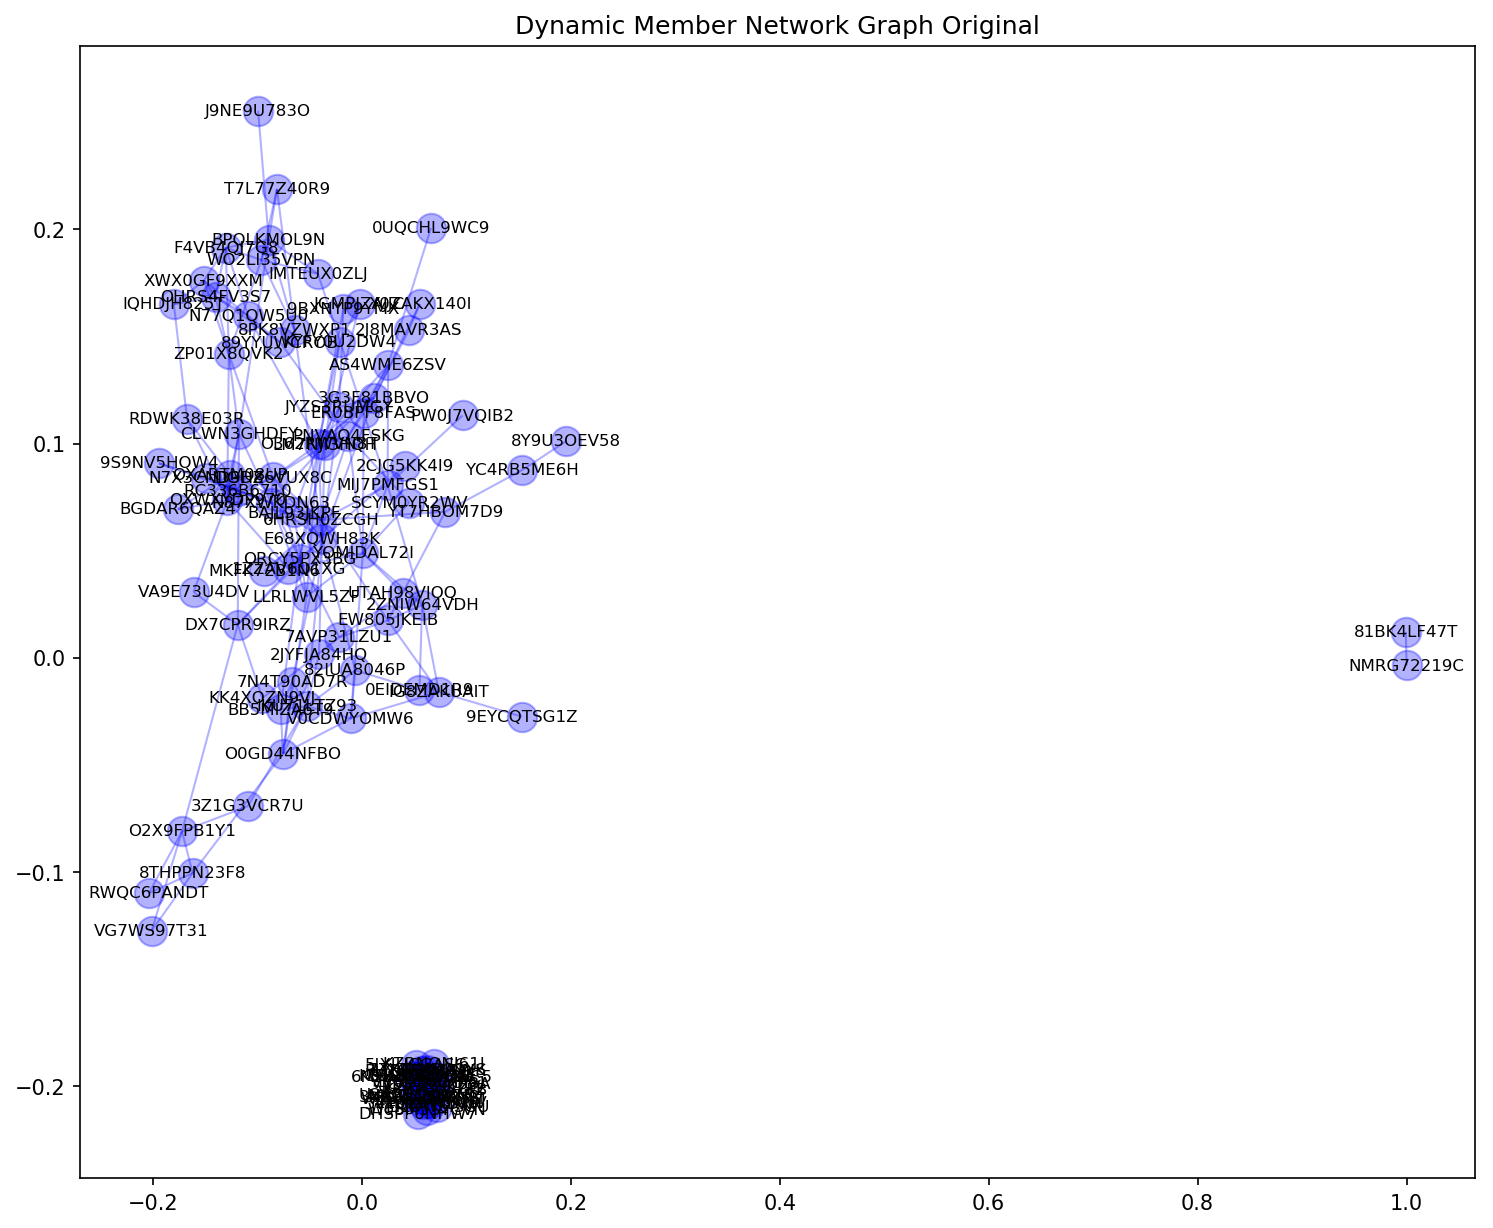

In [53]:
# Create a graph
graph=nx.from_pandas_edgelist(m2m_edges, "member1", "member2", "weight")
fig = plt.figure(figsize=(12, 10), dpi=150)
ax = plt.subplot(1,1,1)
plt.title("Dynamic Member Network Graph Original")
draw_graph(graph, graph_layout="spring",node_size=200)

# Lunch Time Analysis
Use data from lunch time to find the definition of close interaction 
This part will create a html interactive interface to identify the interactions threshold

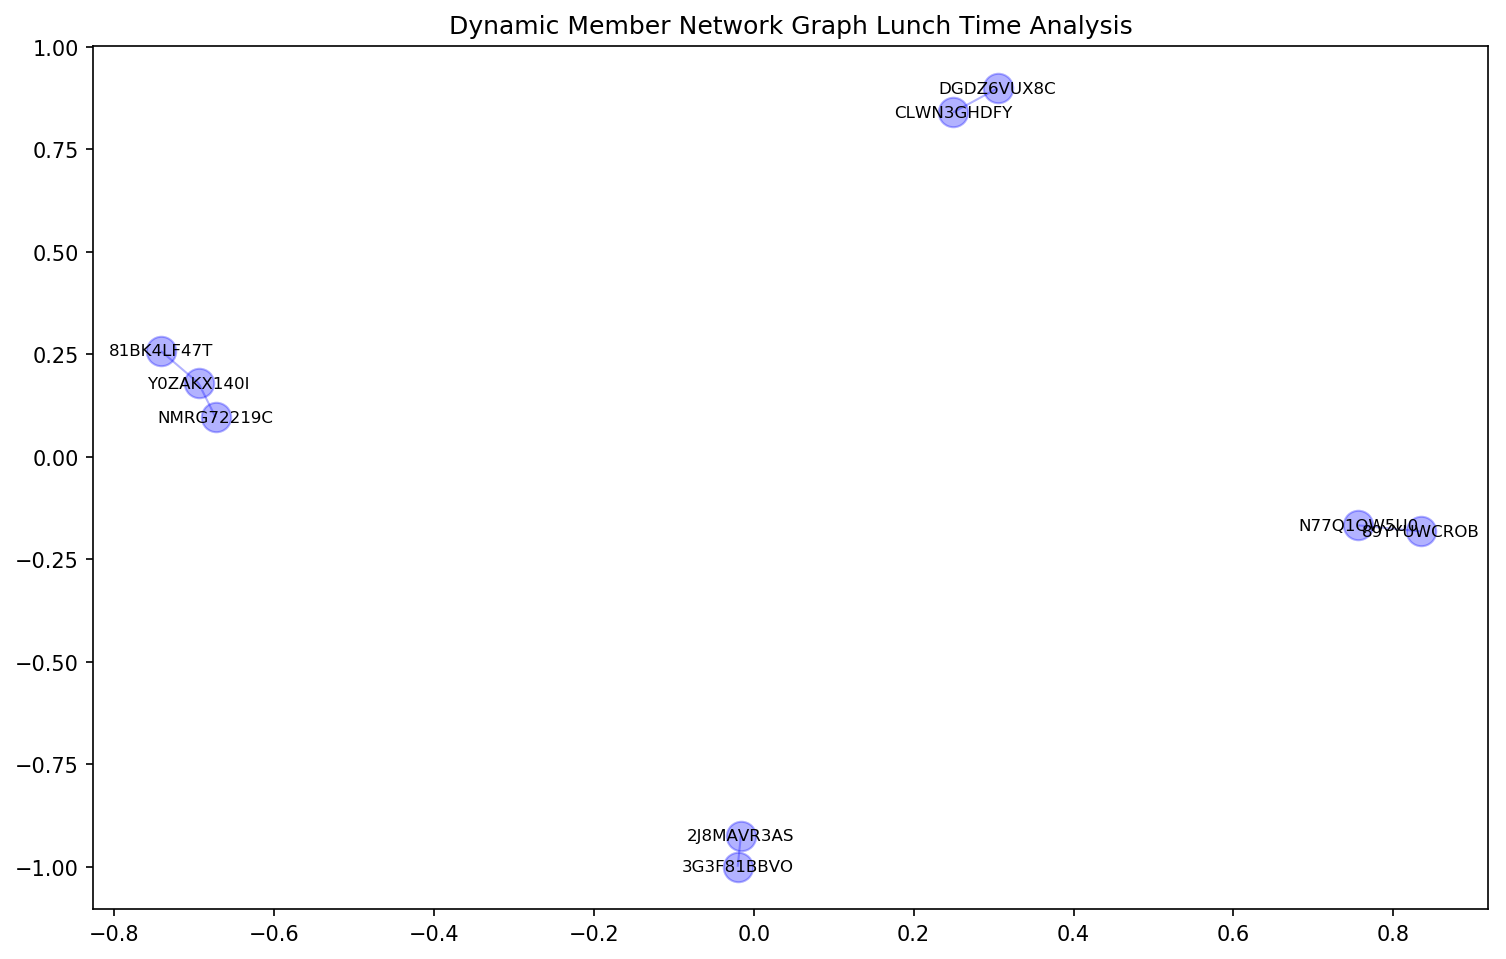

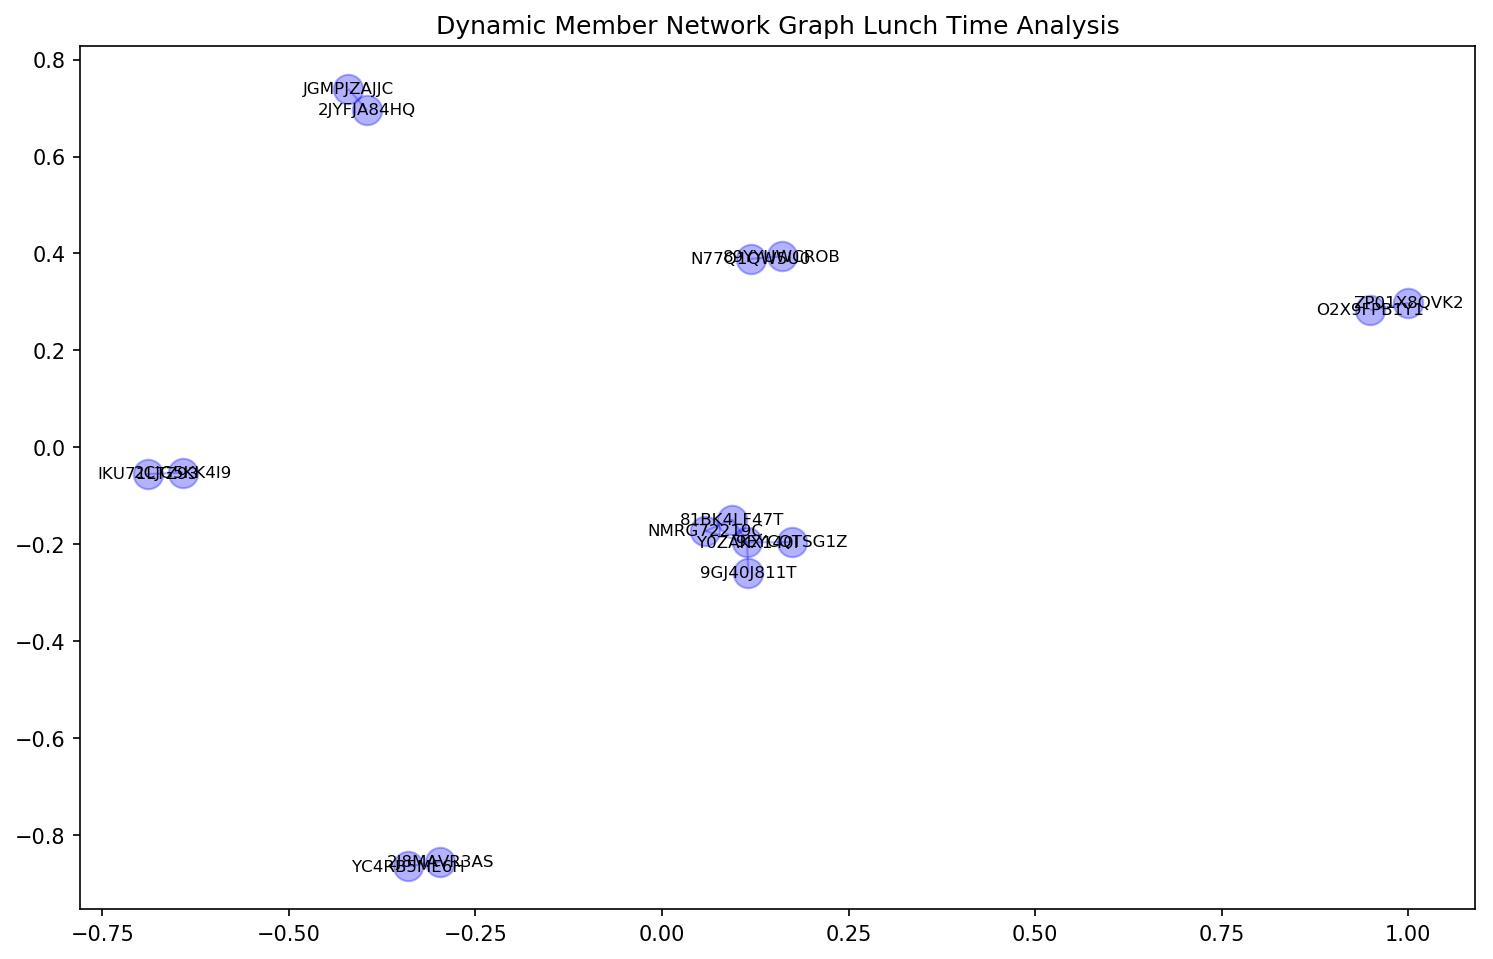

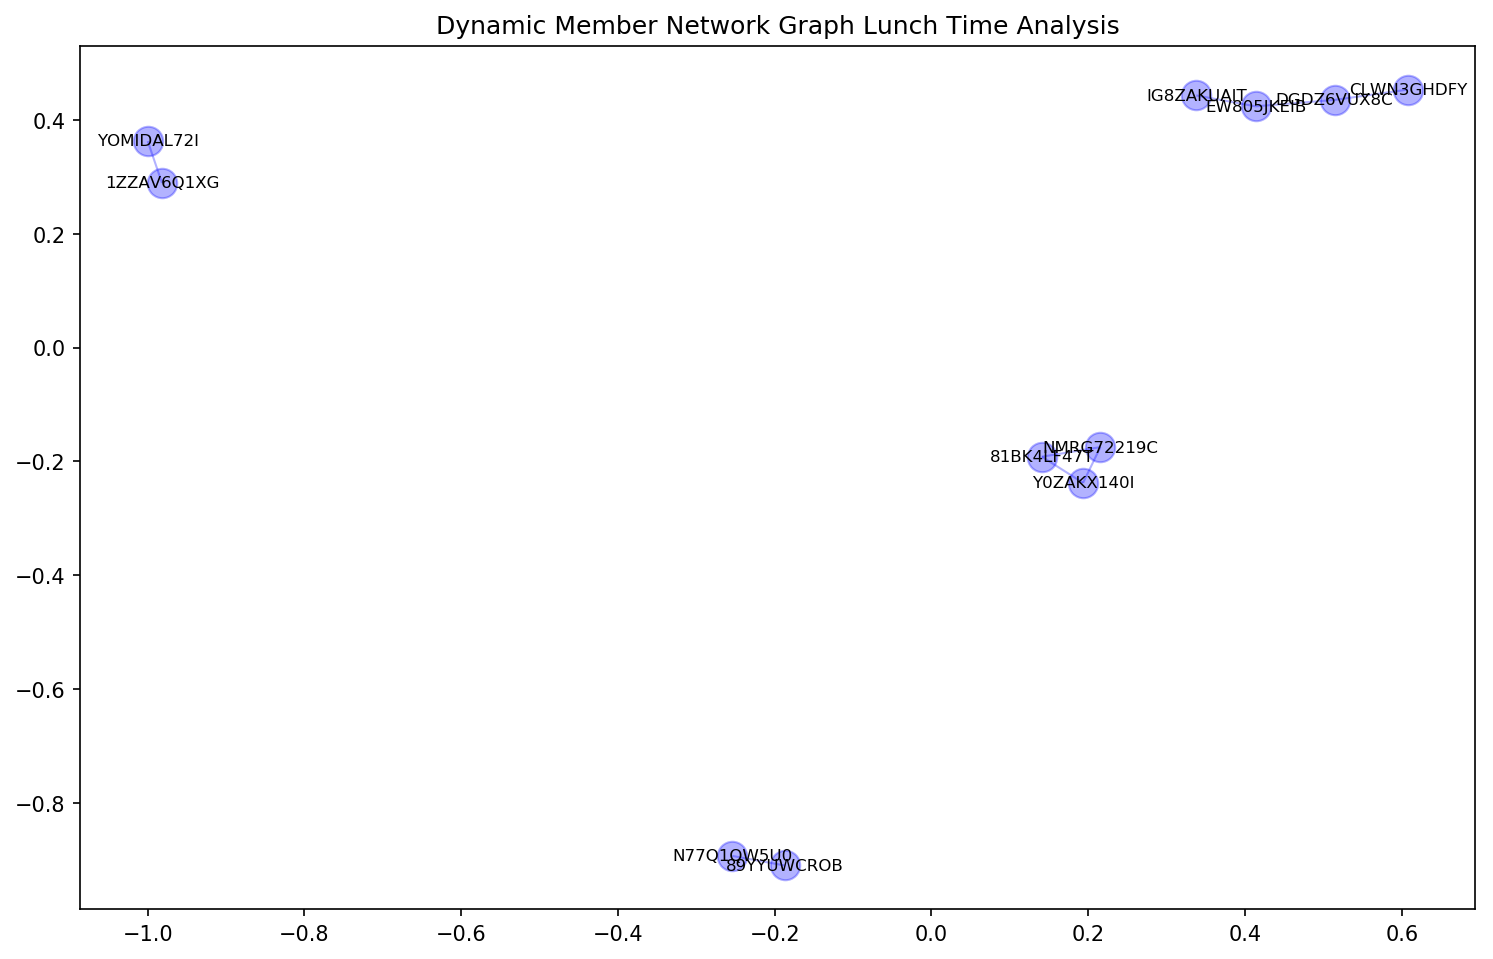

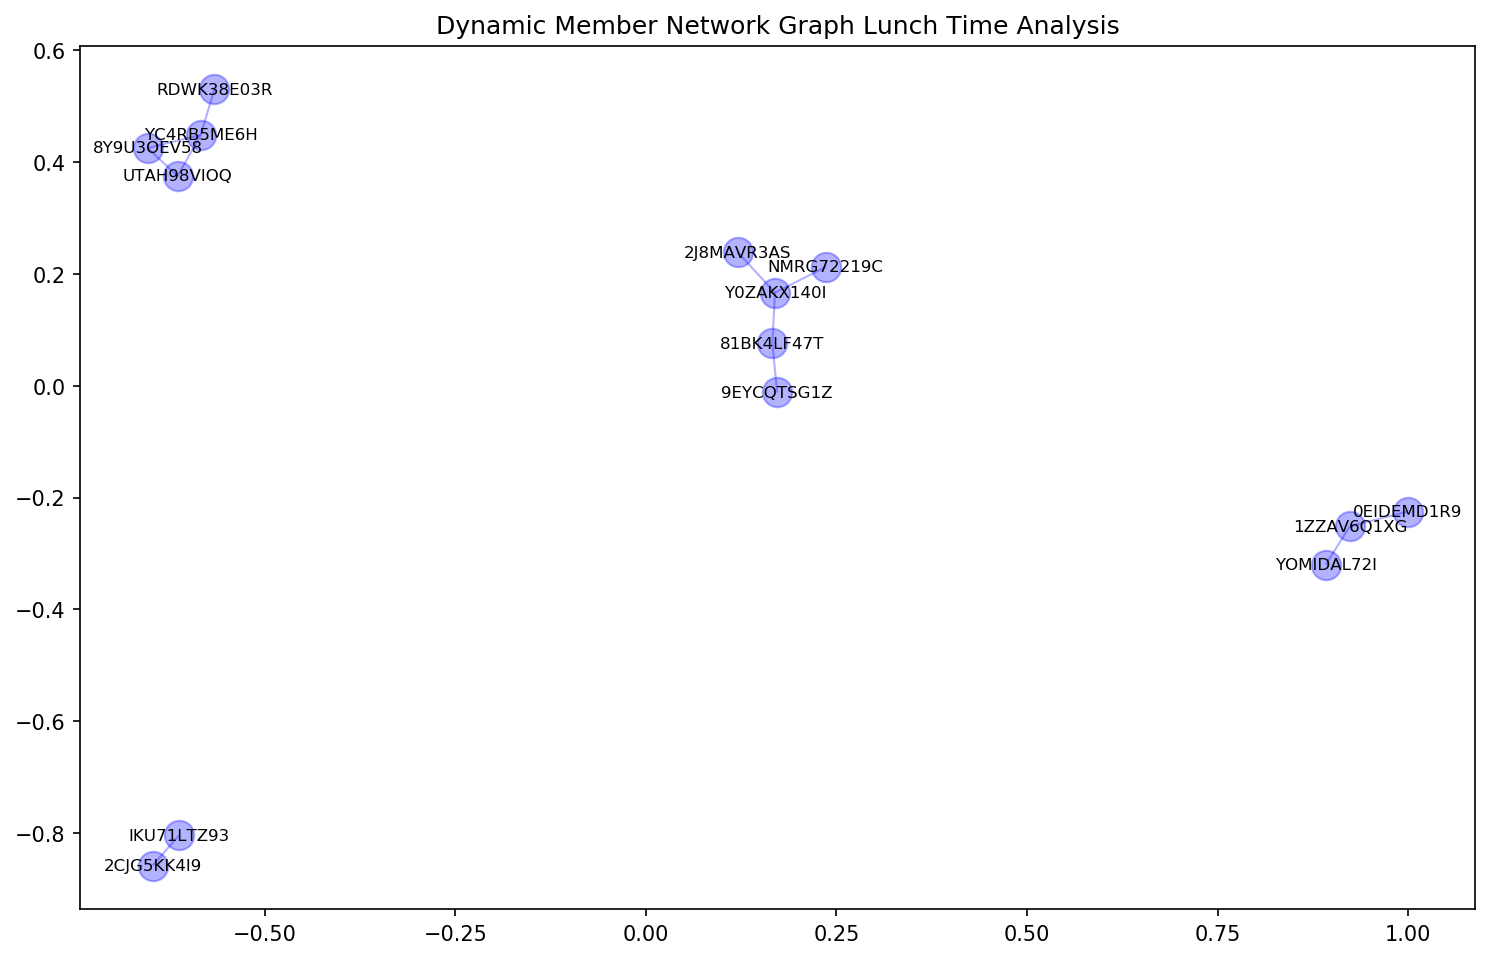

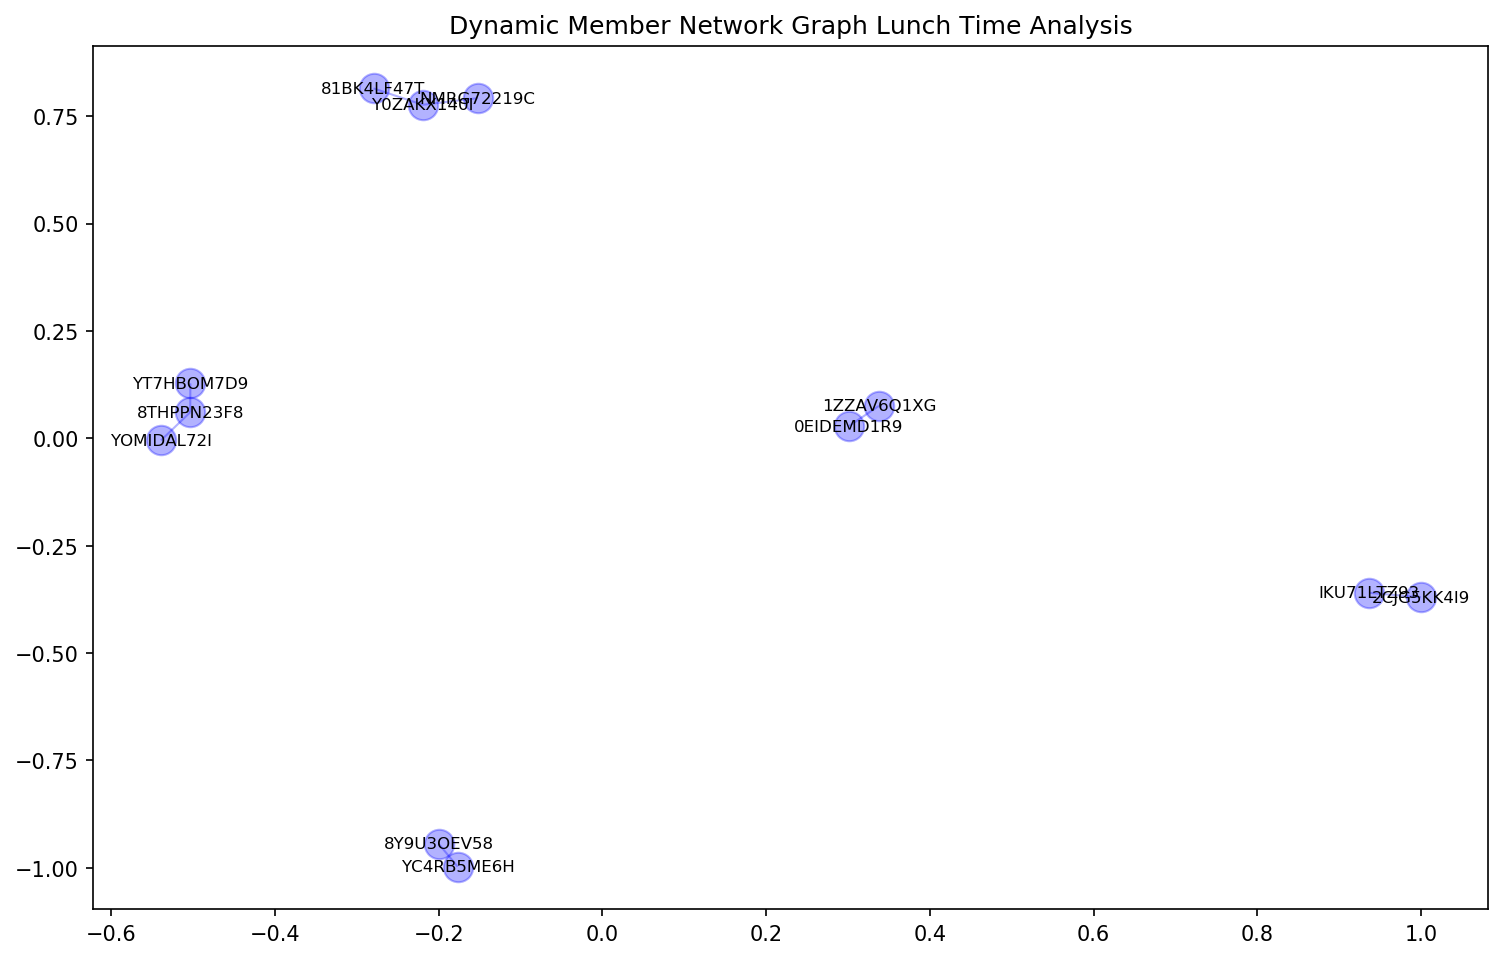

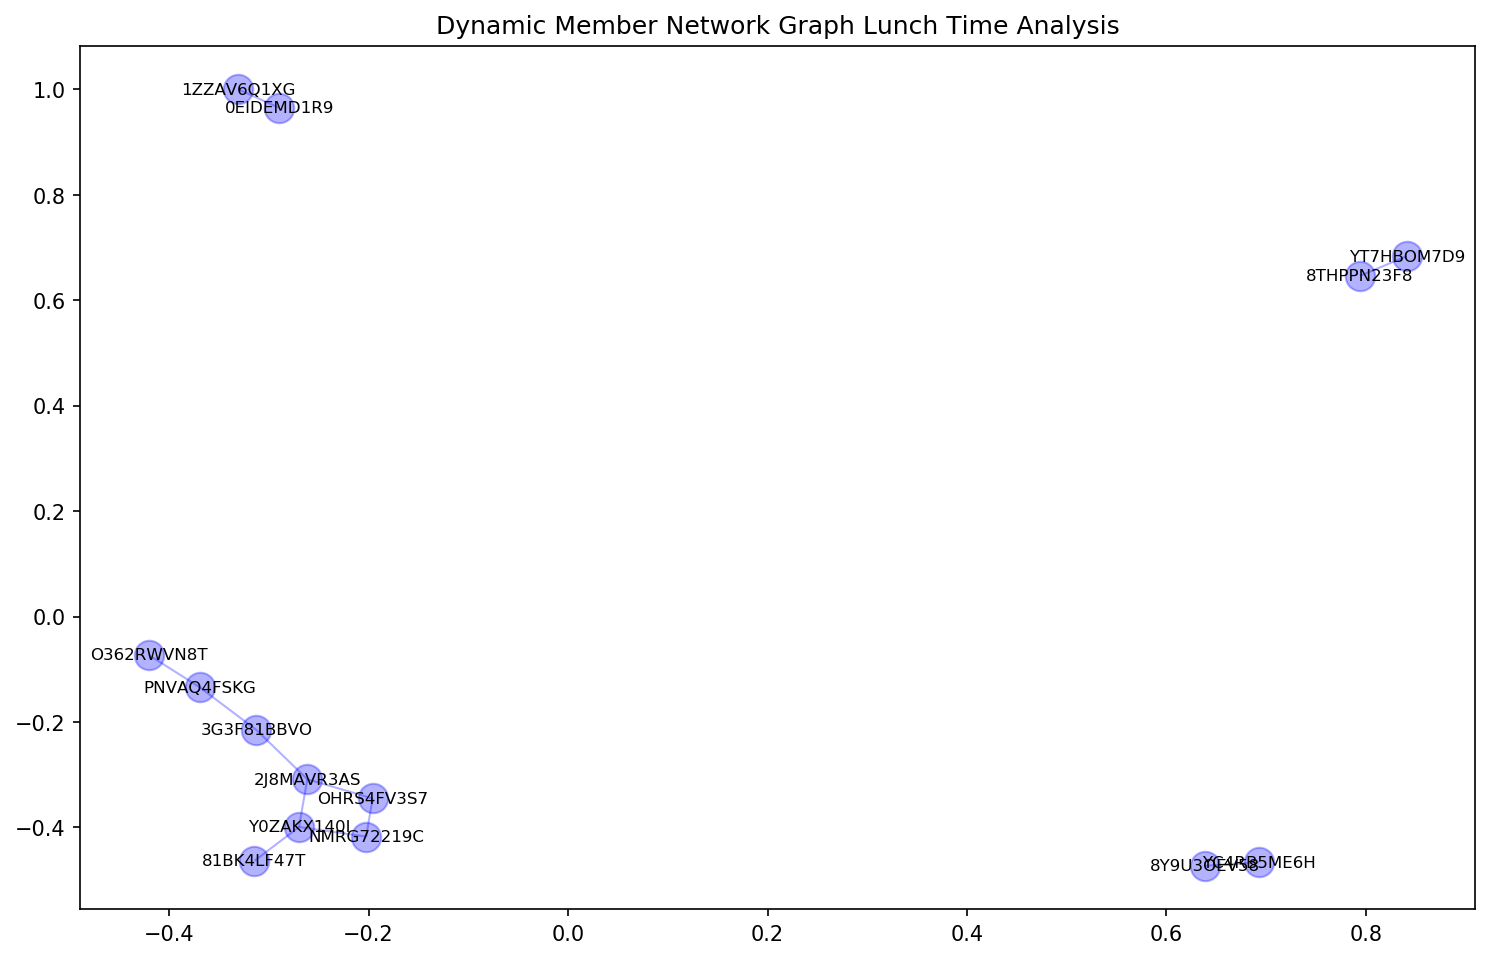

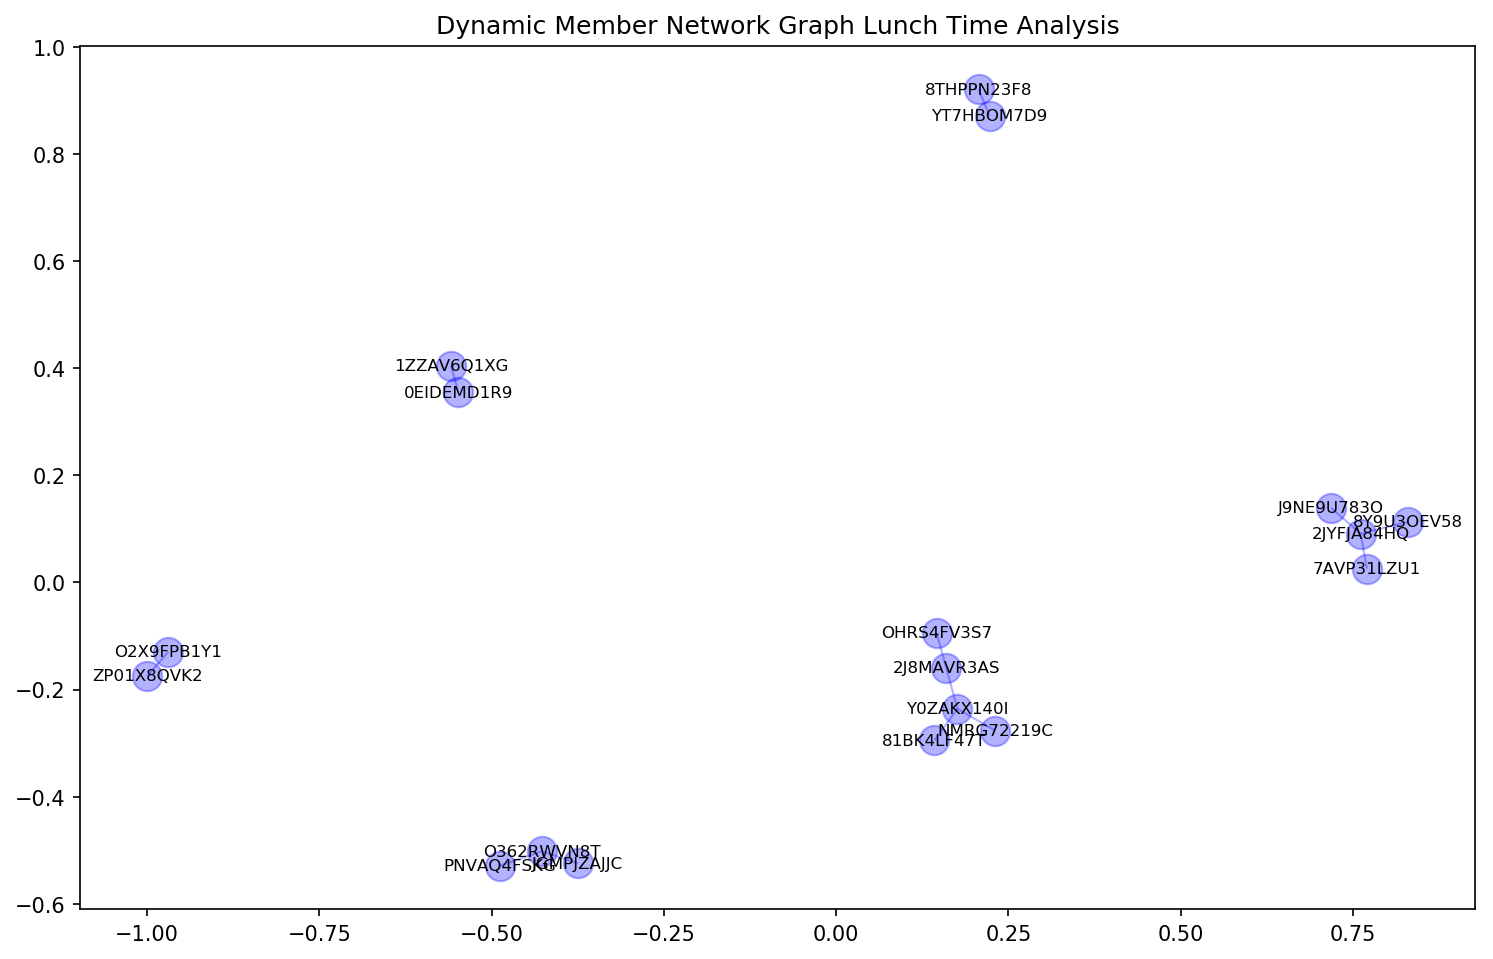

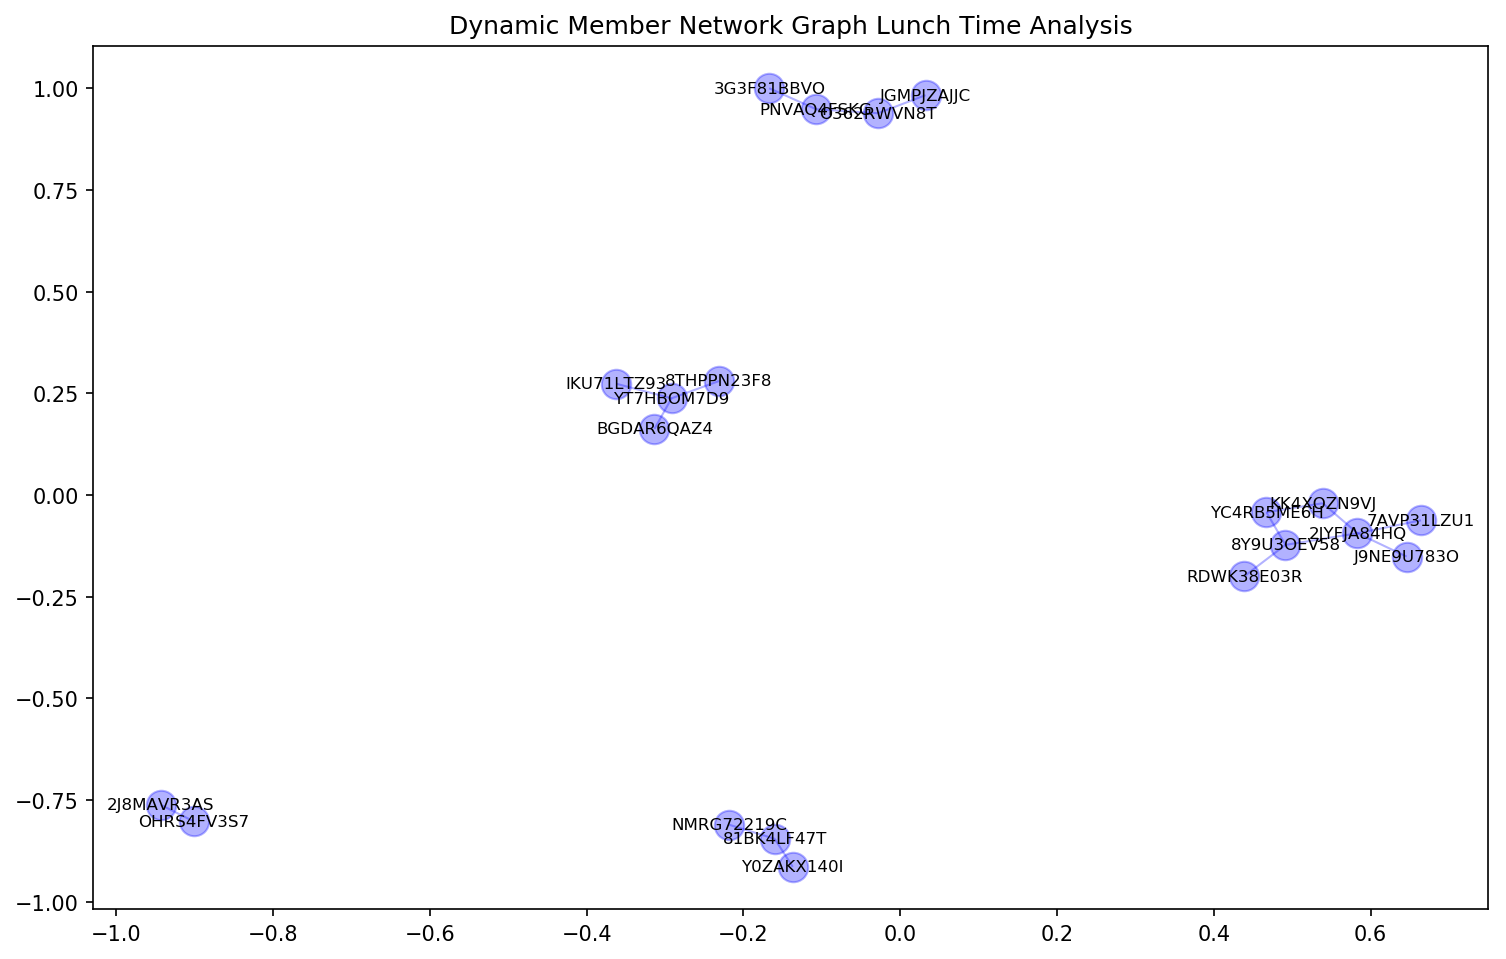

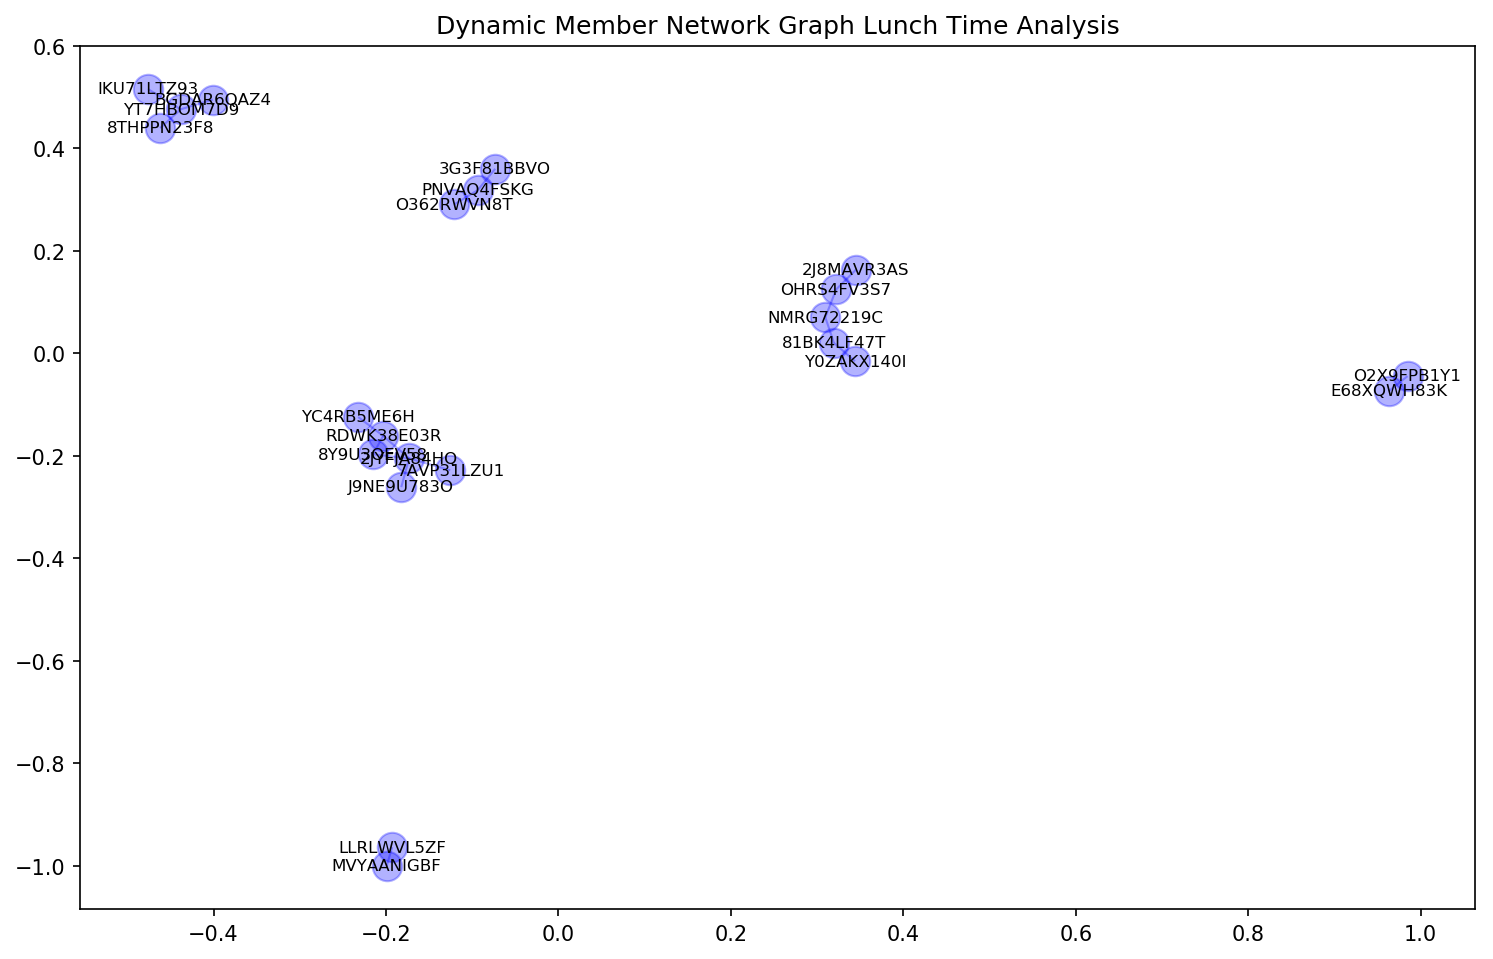

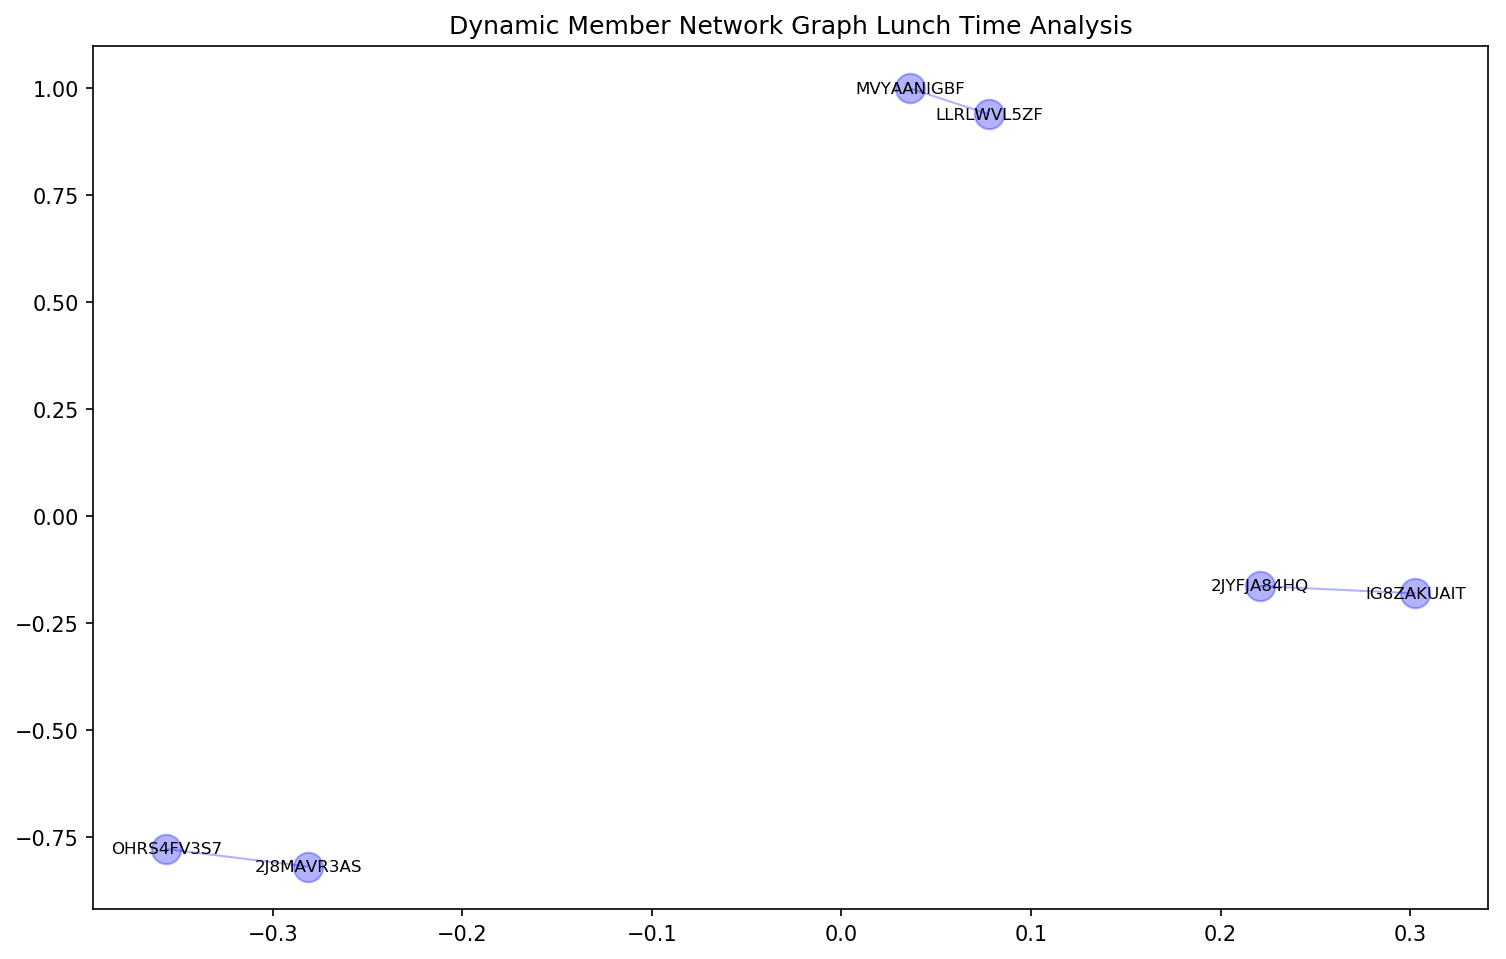

In [54]:
# try time slice iteratively
# Filter data from specific time period
time_slices=[slice('2019-06-01 11:30', '2019-06-01 11:35'),slice('2019-06-01 11:35', '2019-06-01 11:40'),
             slice('2019-06-01 11:40', '2019-06-01 11:45'),slice('2019-06-01 11:45', '2019-06-01 11:50'),
             slice('2019-06-01 11:50', '2019-06-01 11:55'),slice('2019-06-01 11:55', '2019-06-01 12:00'),
            slice('2019-06-01 12:00', '2019-06-01 12:05'),slice('2019-06-01 12:05', '2019-06-01 12:10'),
            slice('2019-06-01 12:10', '2019-06-01 12:15'),slice('2019-06-01 12:15', '2019-06-01 12:20'),]
for i in range(1,11):
    time_slice = time_slices[i-1]
    m2m_breakout = tmp_m2ms_sorted.loc[time_slice]
    # keep only instances with strong signal
    m2m_filter_rssi = m2m_breakout[m2m_breakout.rssi >= -75].copy()
    # Count number of time members were in close proximity
    # We name the count column "weight" so that networkx will use it as weight for the spring layout
    m2m_edges = m2m_filter_rssi.groupby(['member1', 'member2'])[['rssi_weighted_mean']
                                                               ].count().rename(columns={'rssi_weighted_mean':'weight'})
    m2m_edges = m2m_edges[["weight"]].reset_index()
    # Keep strongest edges (threshold set manually)
    m2m_edges = m2m_edges[m2m_edges.weight > 8]
    # Create a graph
    graph=nx.from_pandas_edgelist(m2m_edges, "member1", "member2", "weight")
    fig = plt.figure(figsize=(12,90), dpi=150)
    ax = plt.subplot(10,1,i)
    plt.title("Dynamic Member Network Graph Lunch Time Analysis")
    draw_graph(graph, graph_layout="spring",node_size=200)
   
plt.show()




# Break-out Session Analysis
Use data from lunch time to find the definition of close interaction 

391


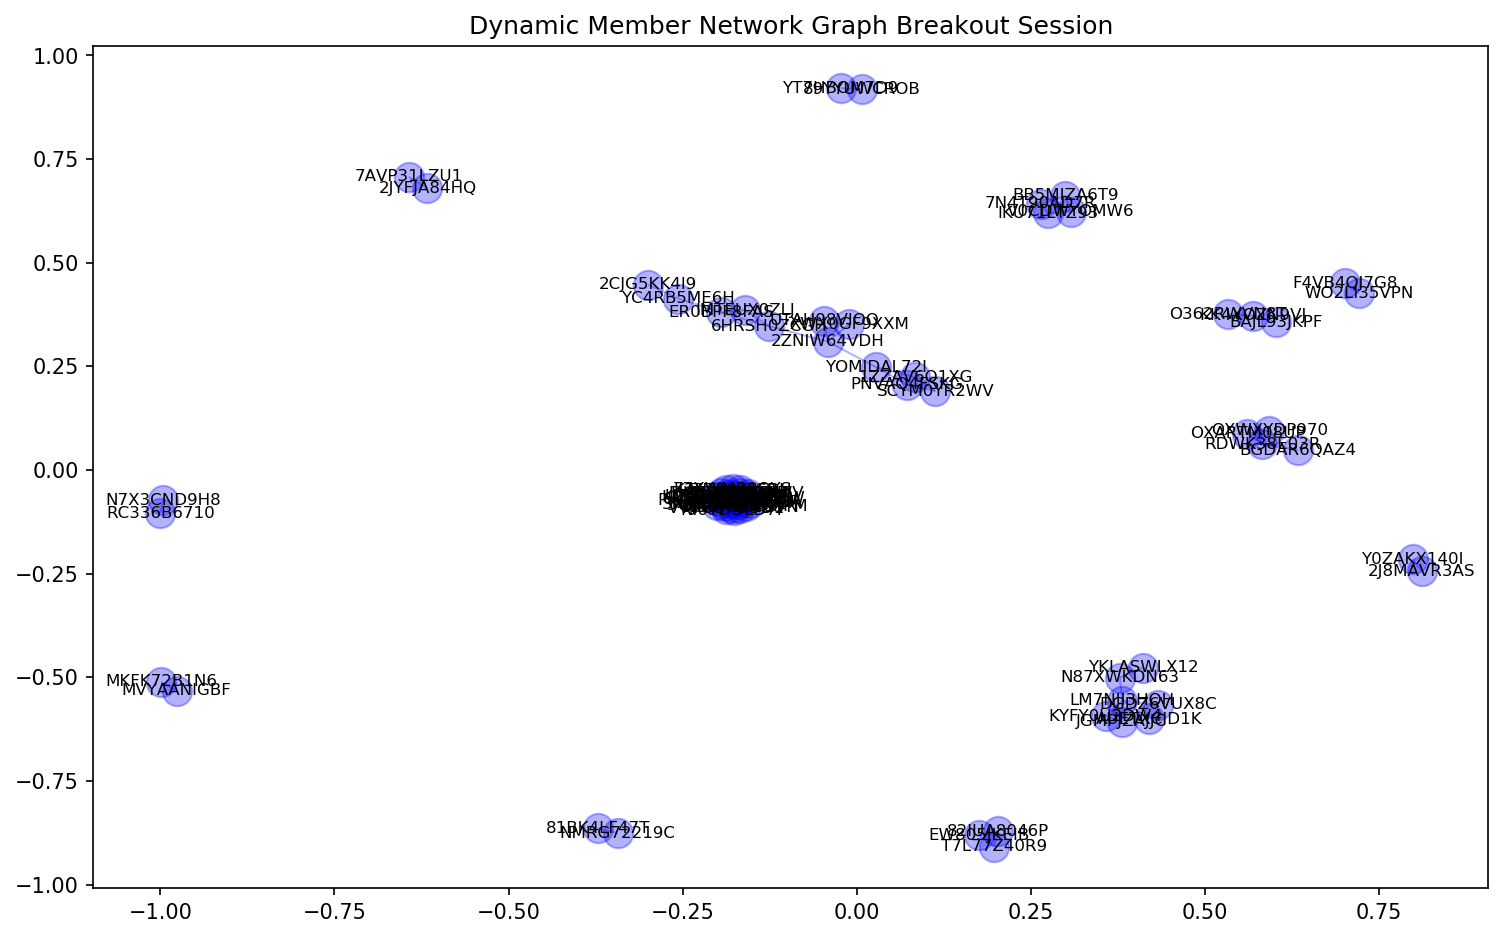

456


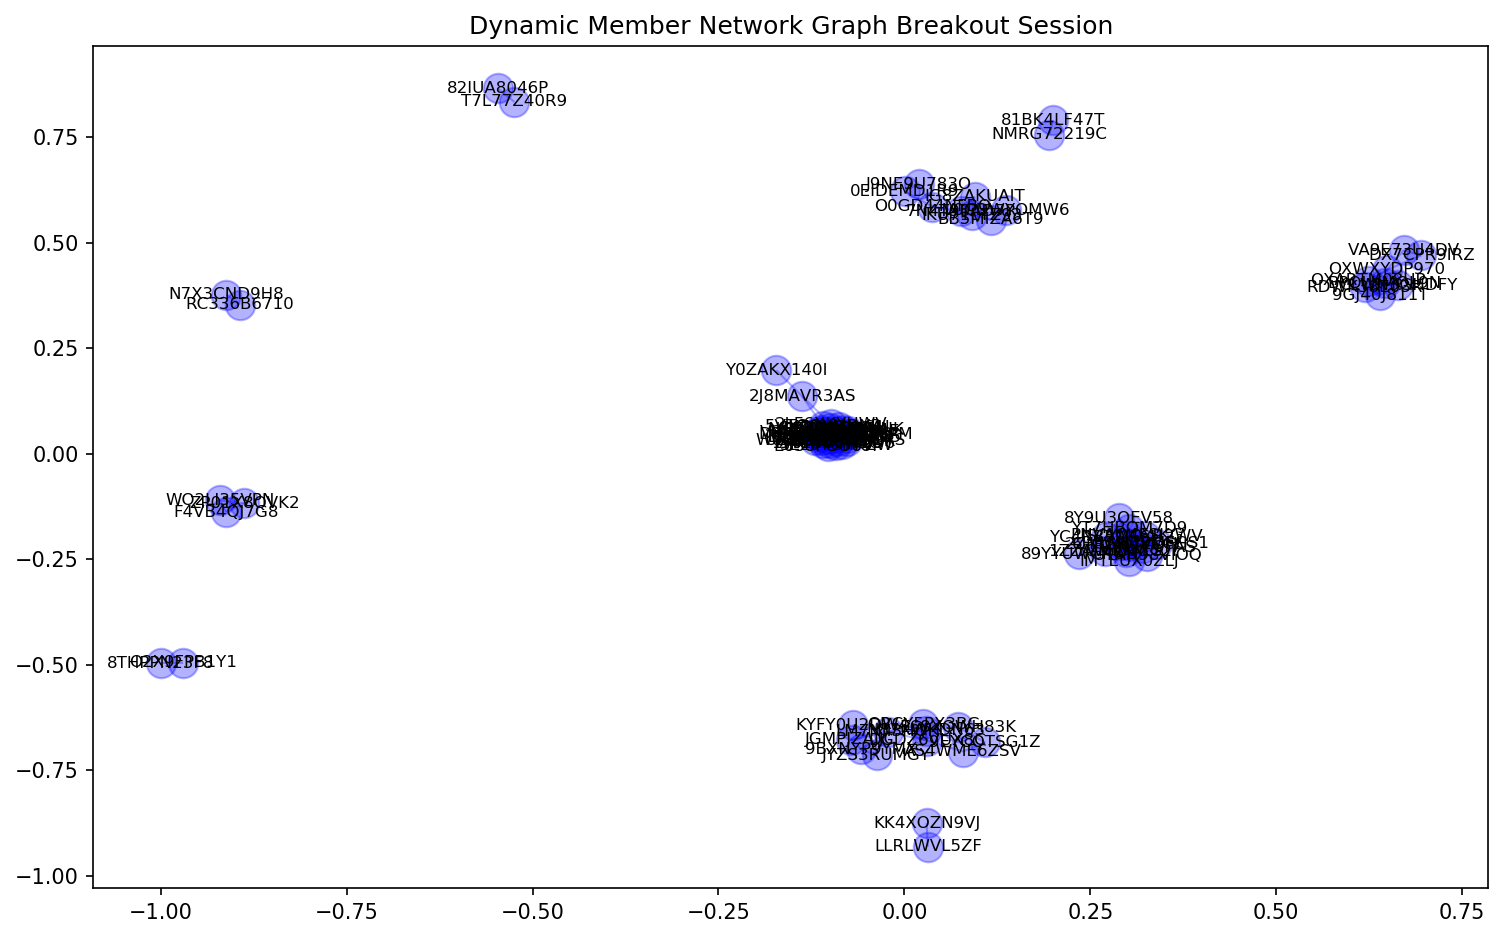

453


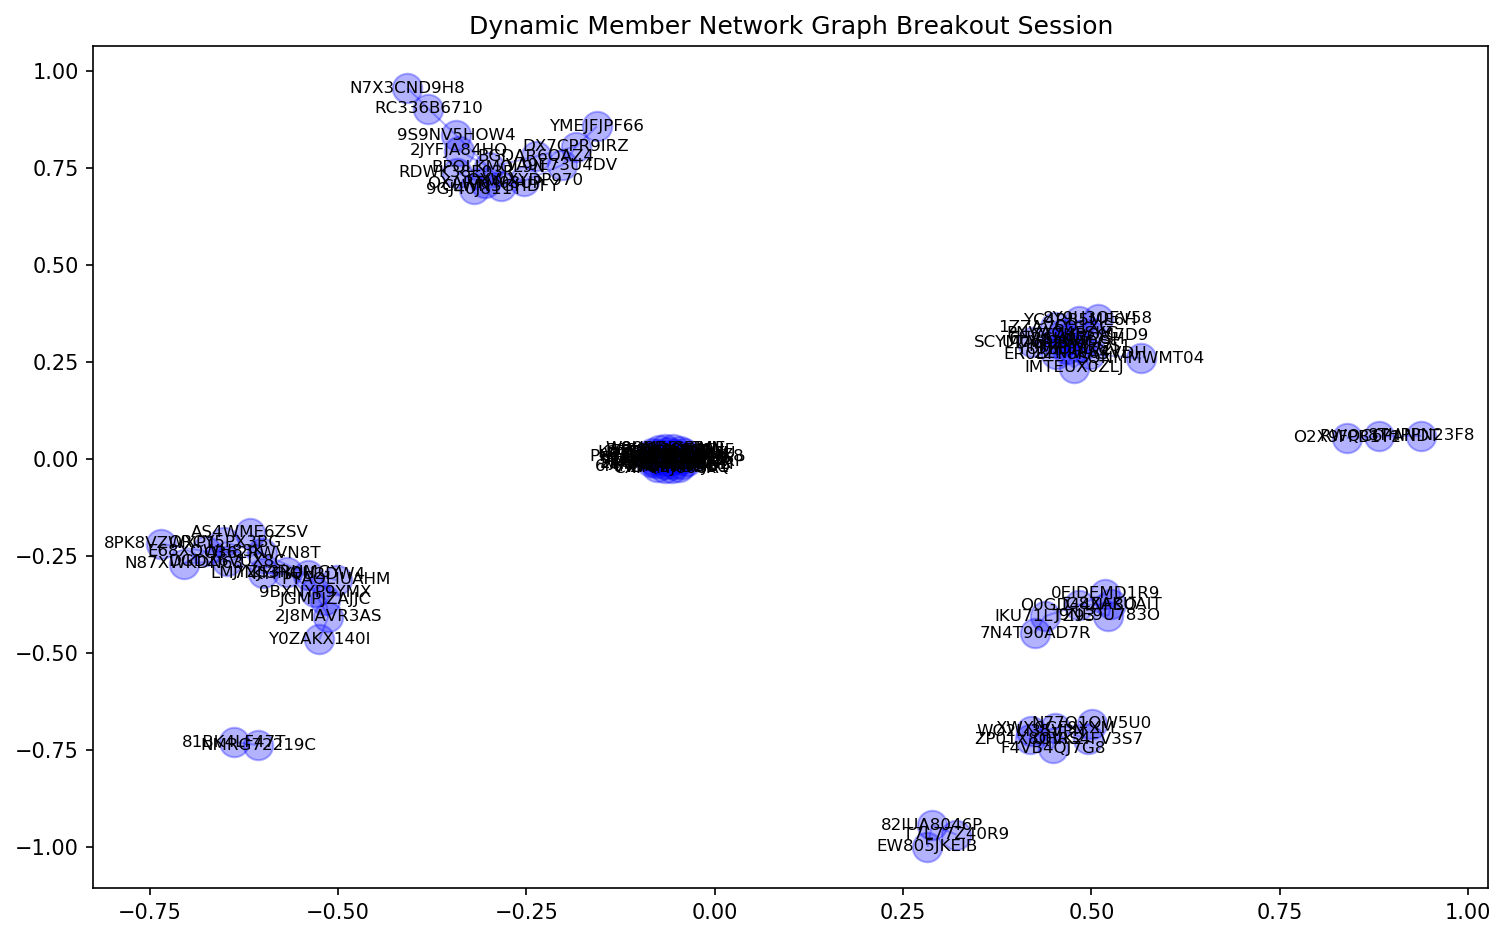

476


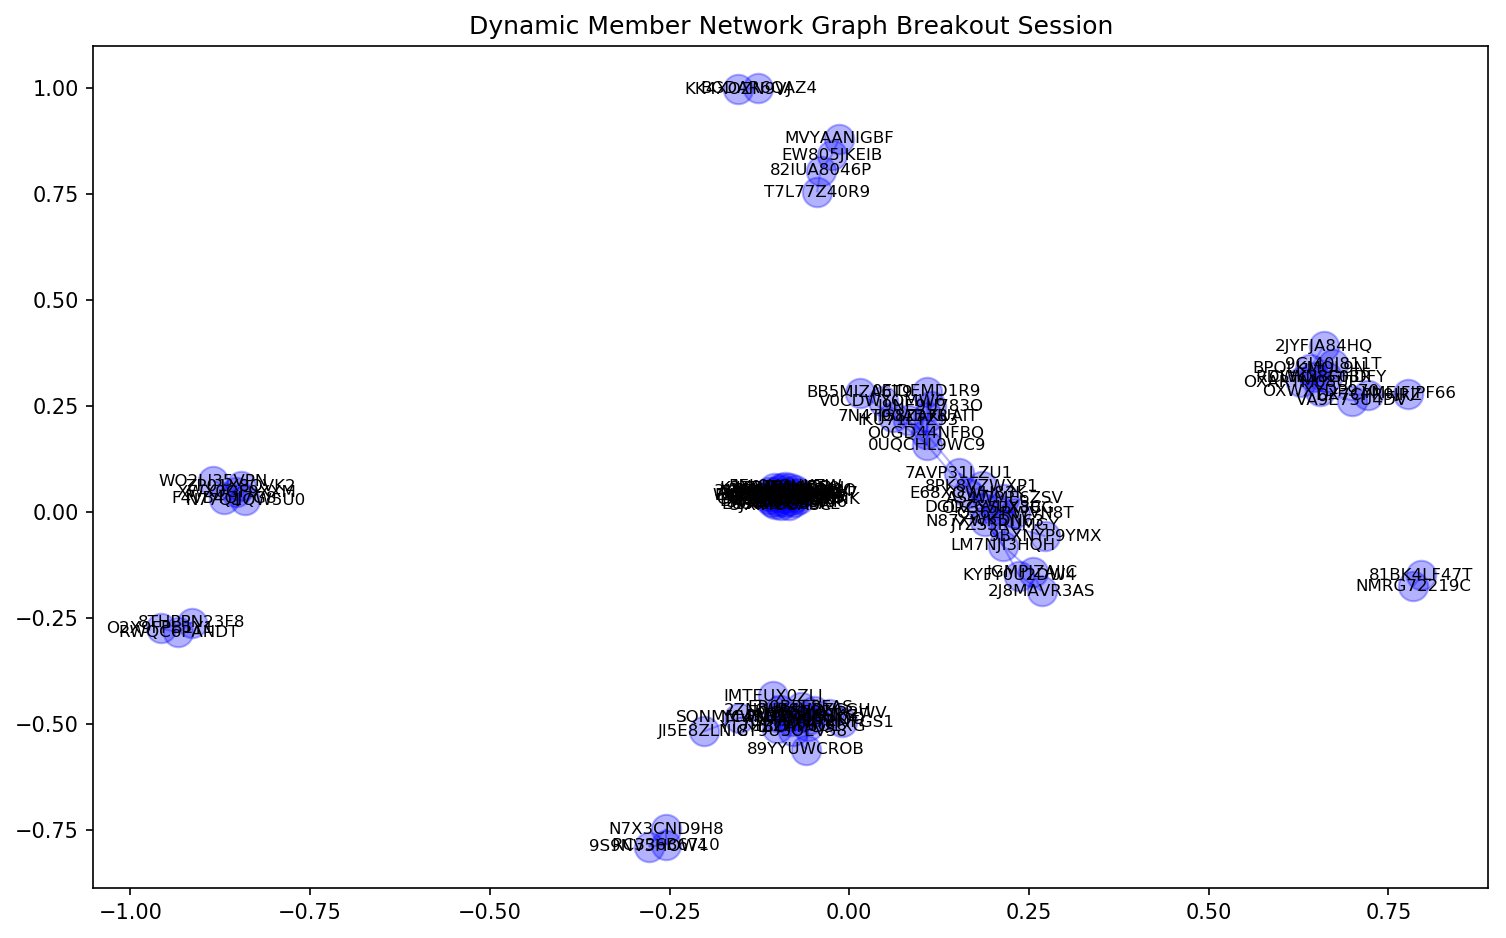

469


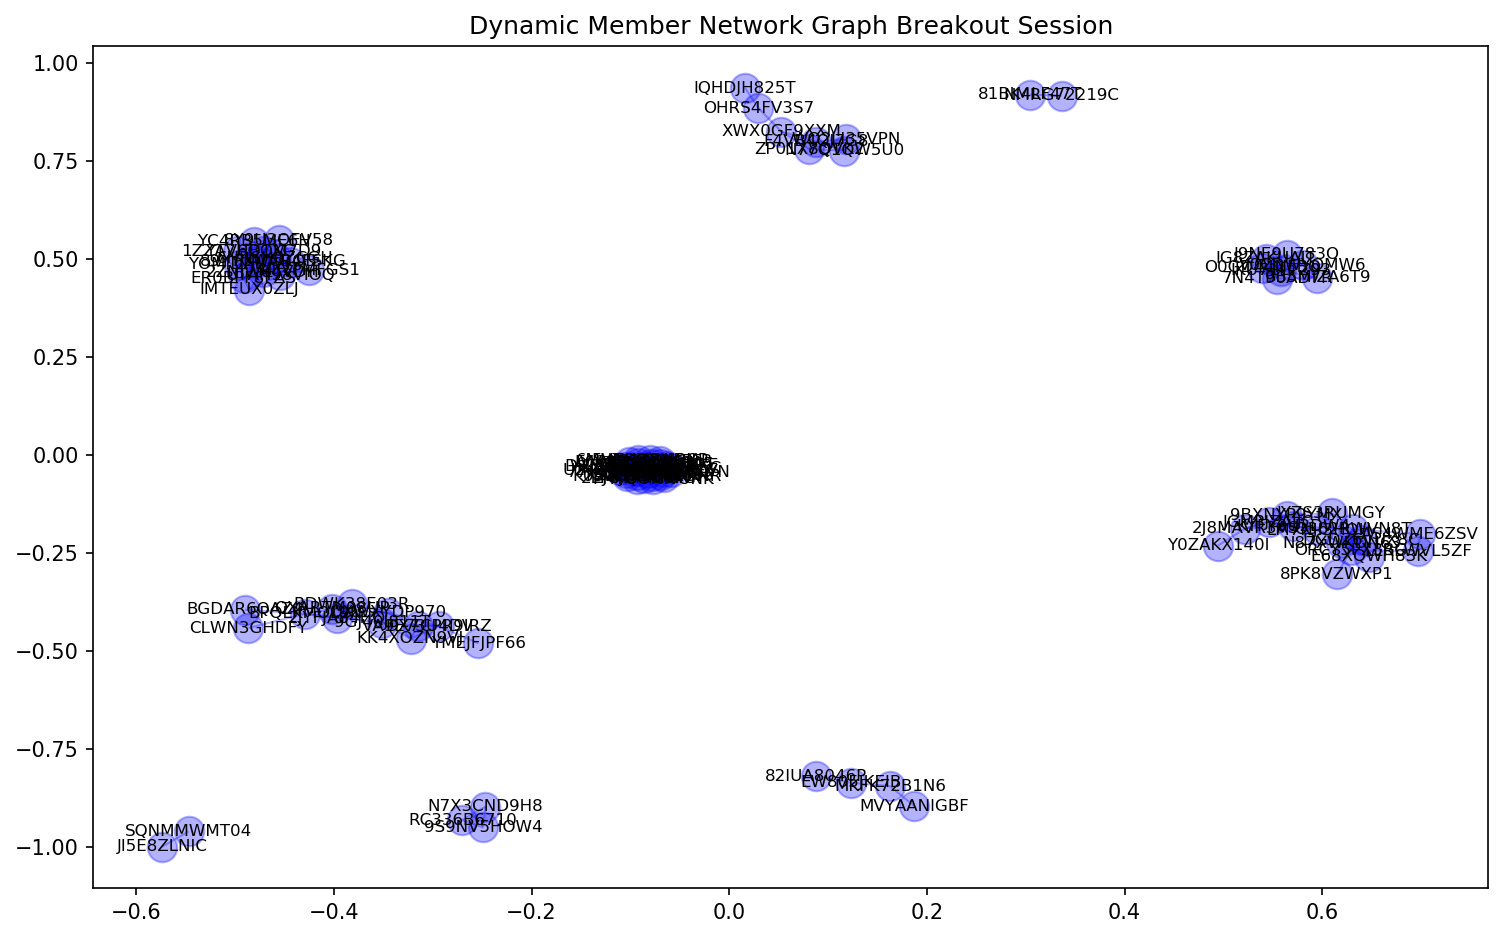

472


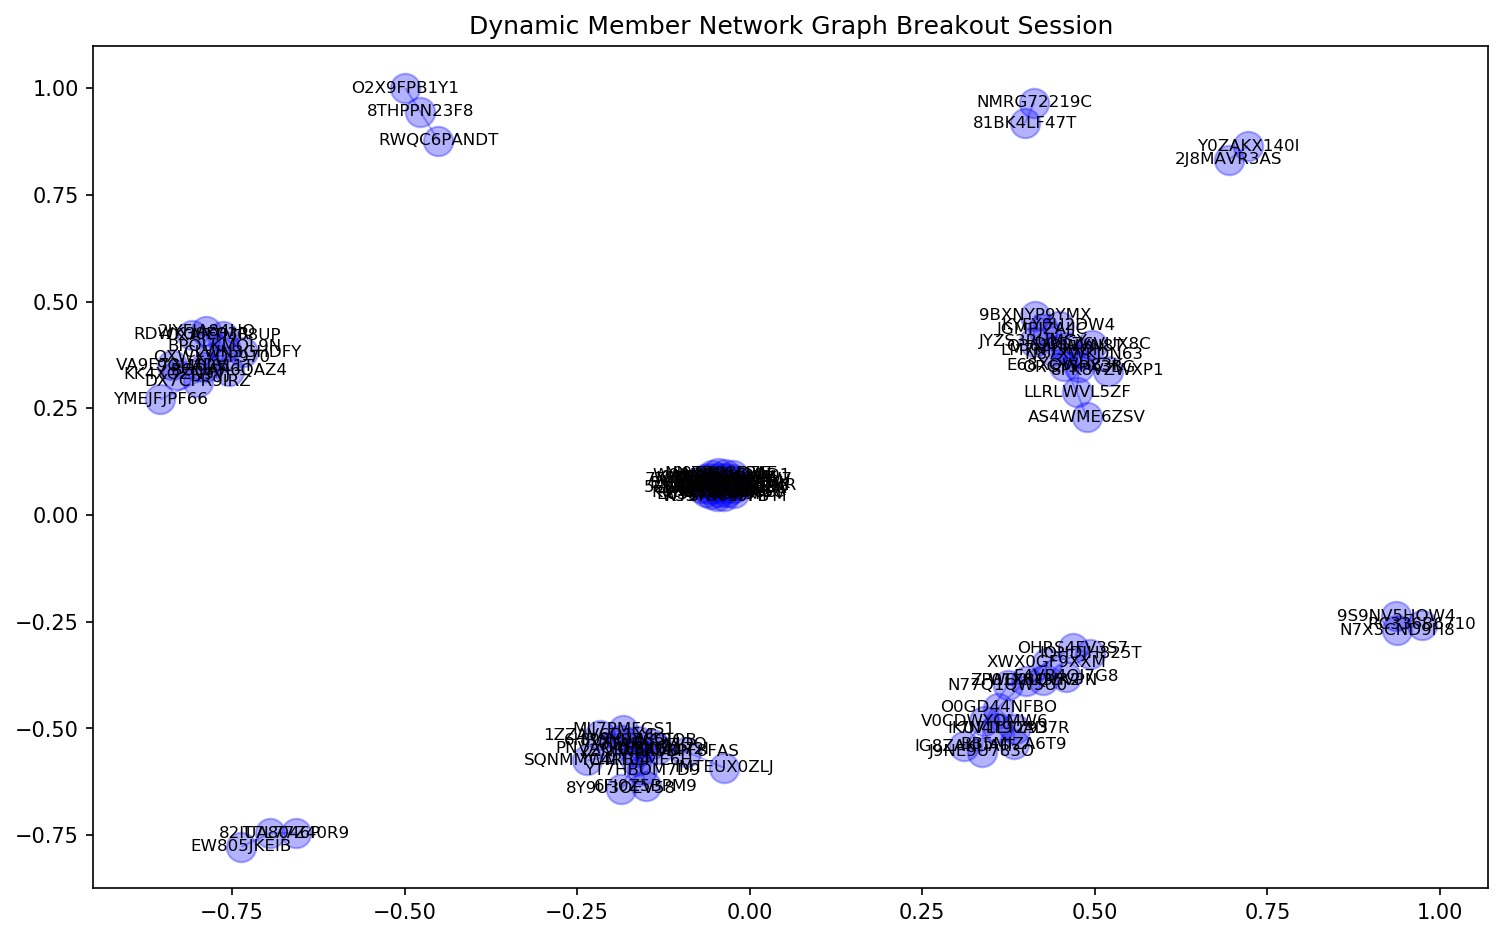

468


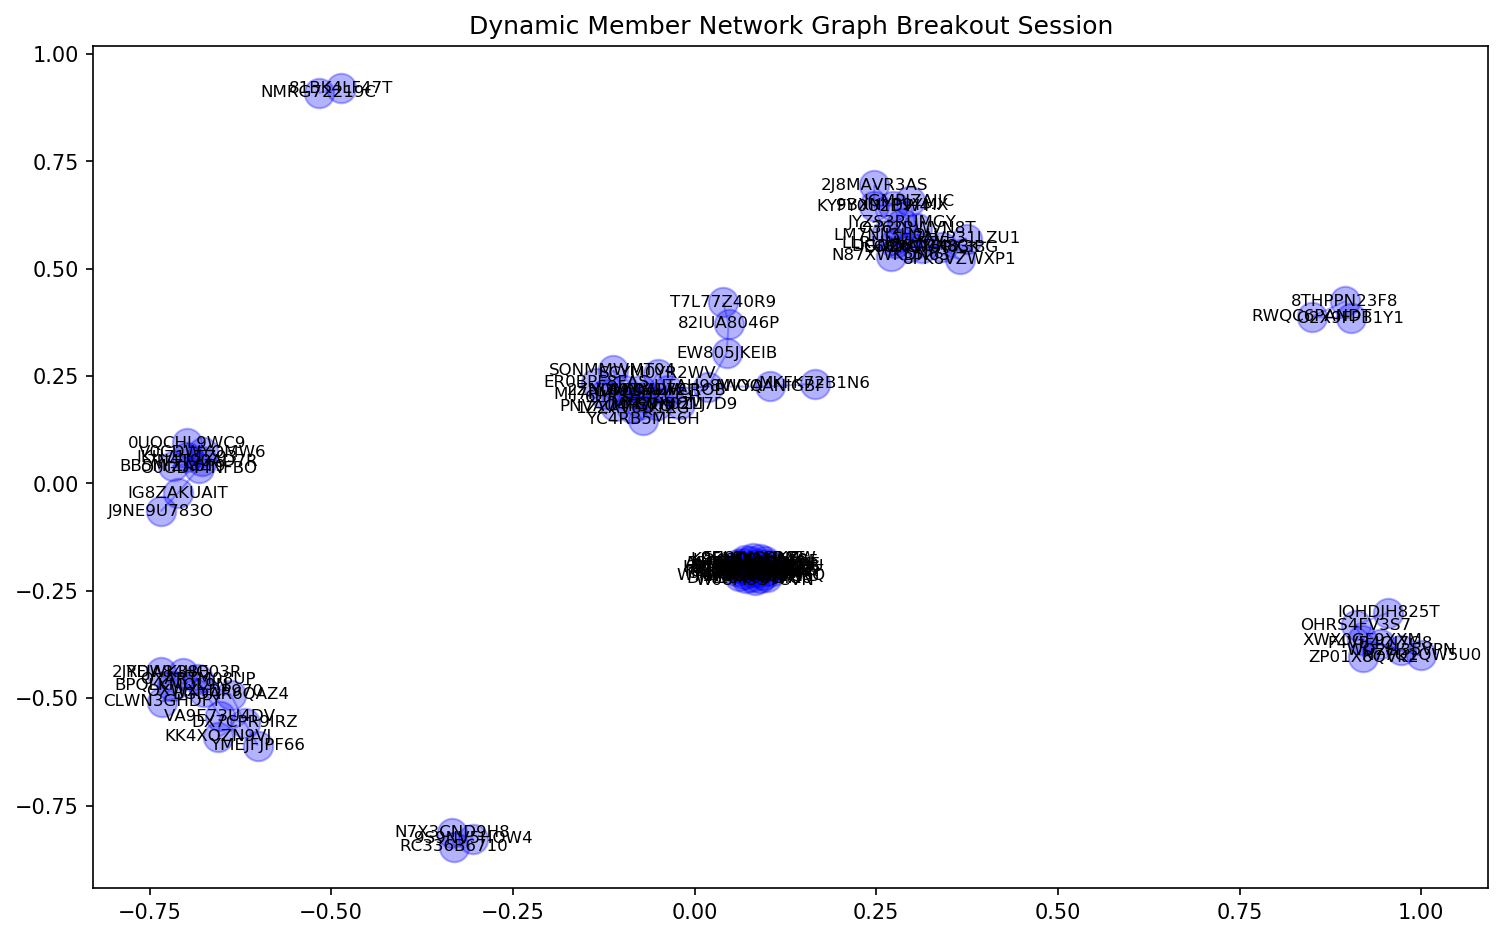

451


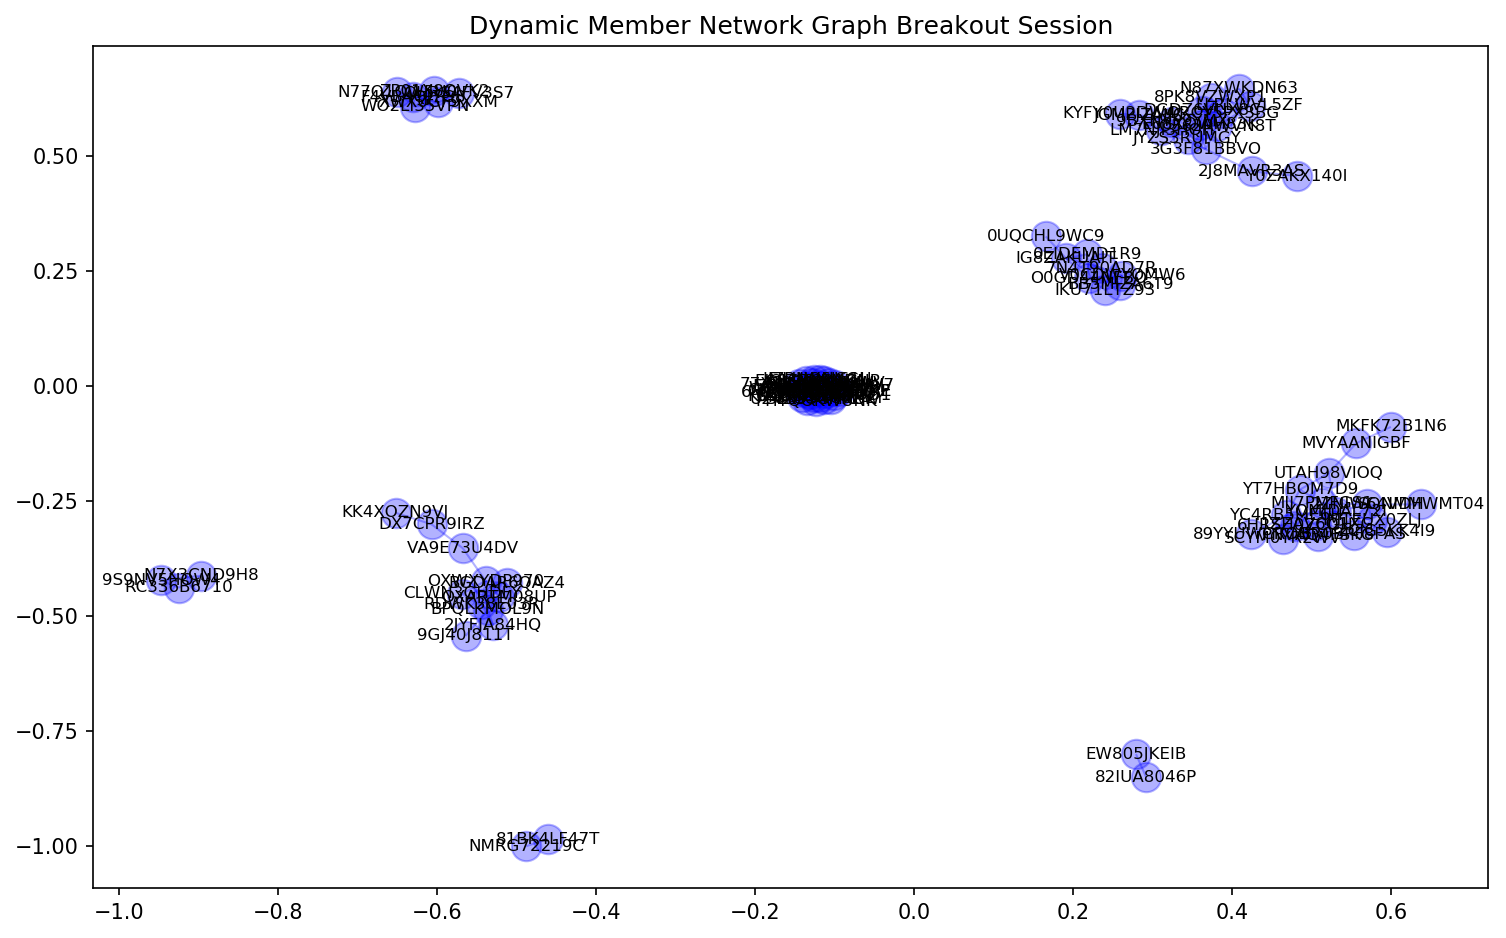

485


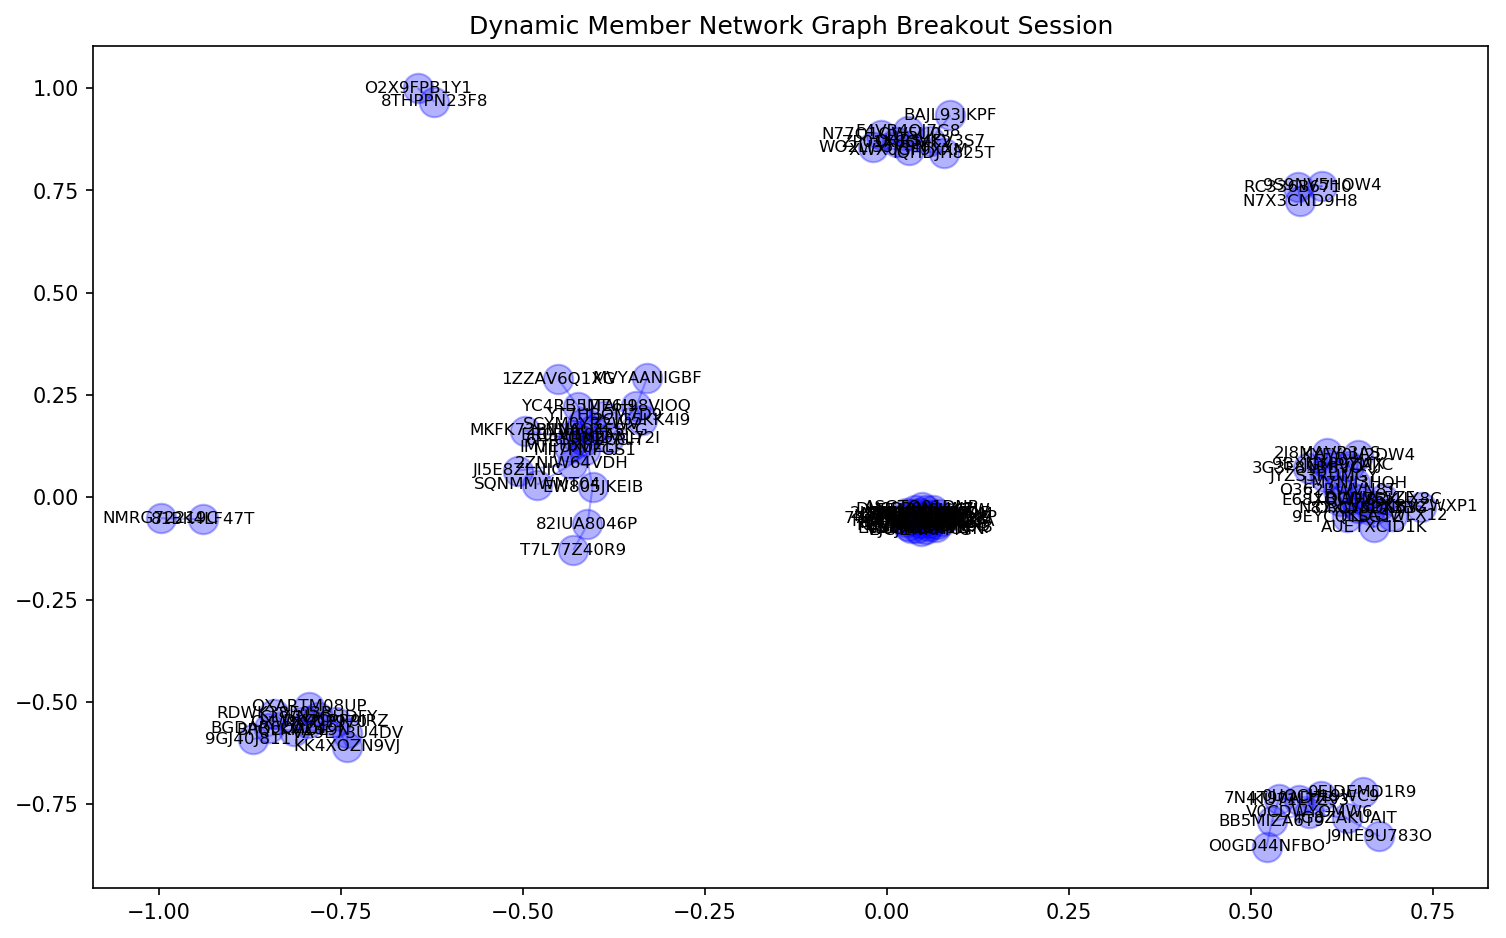

452


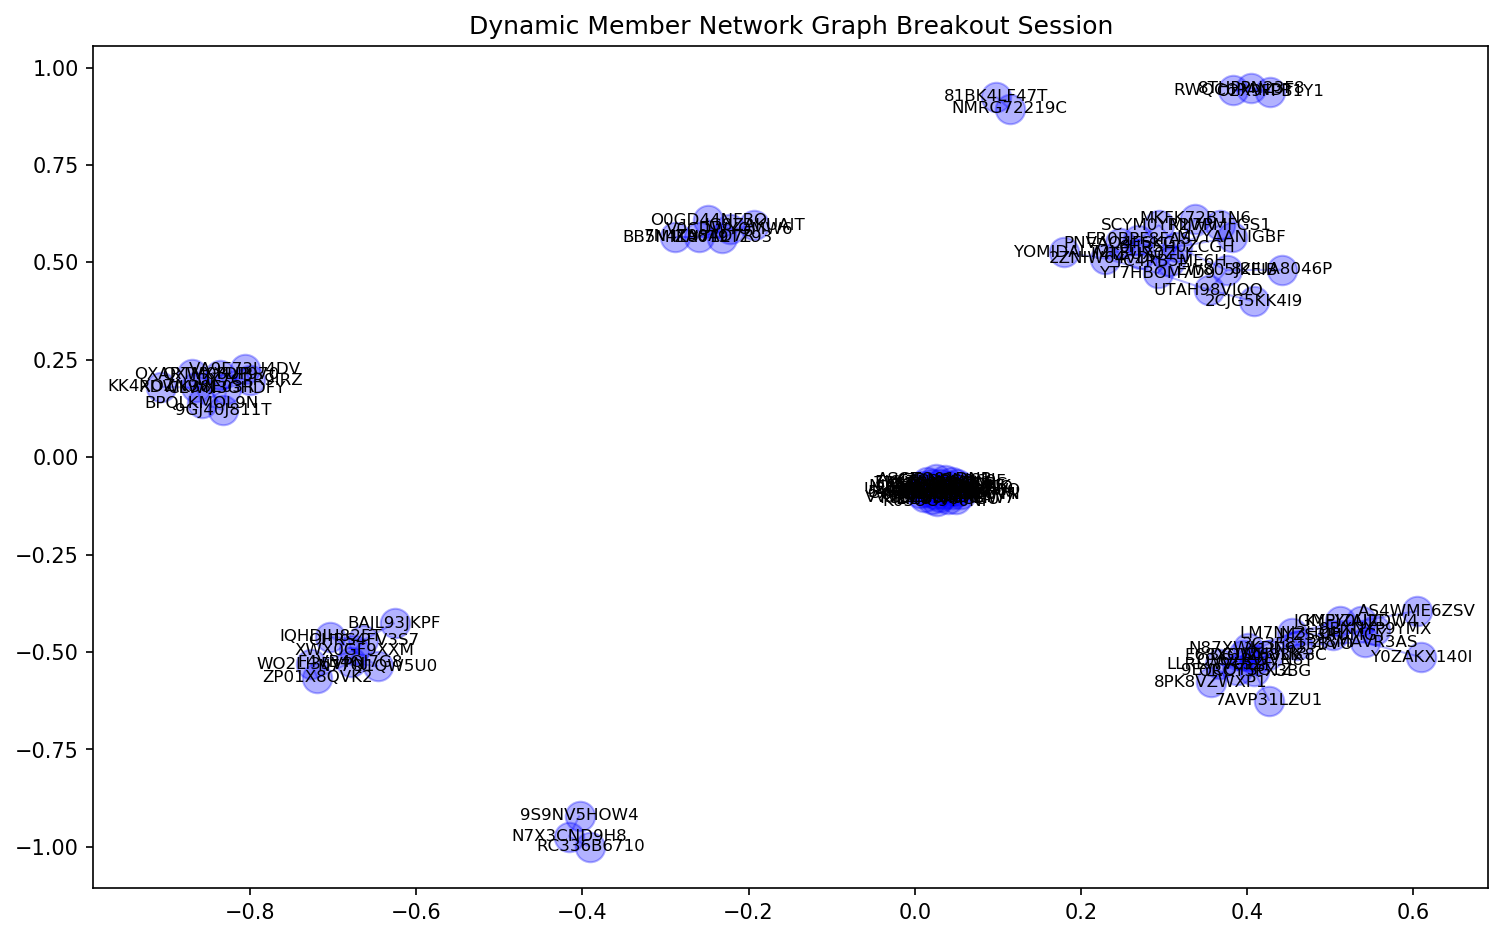

463


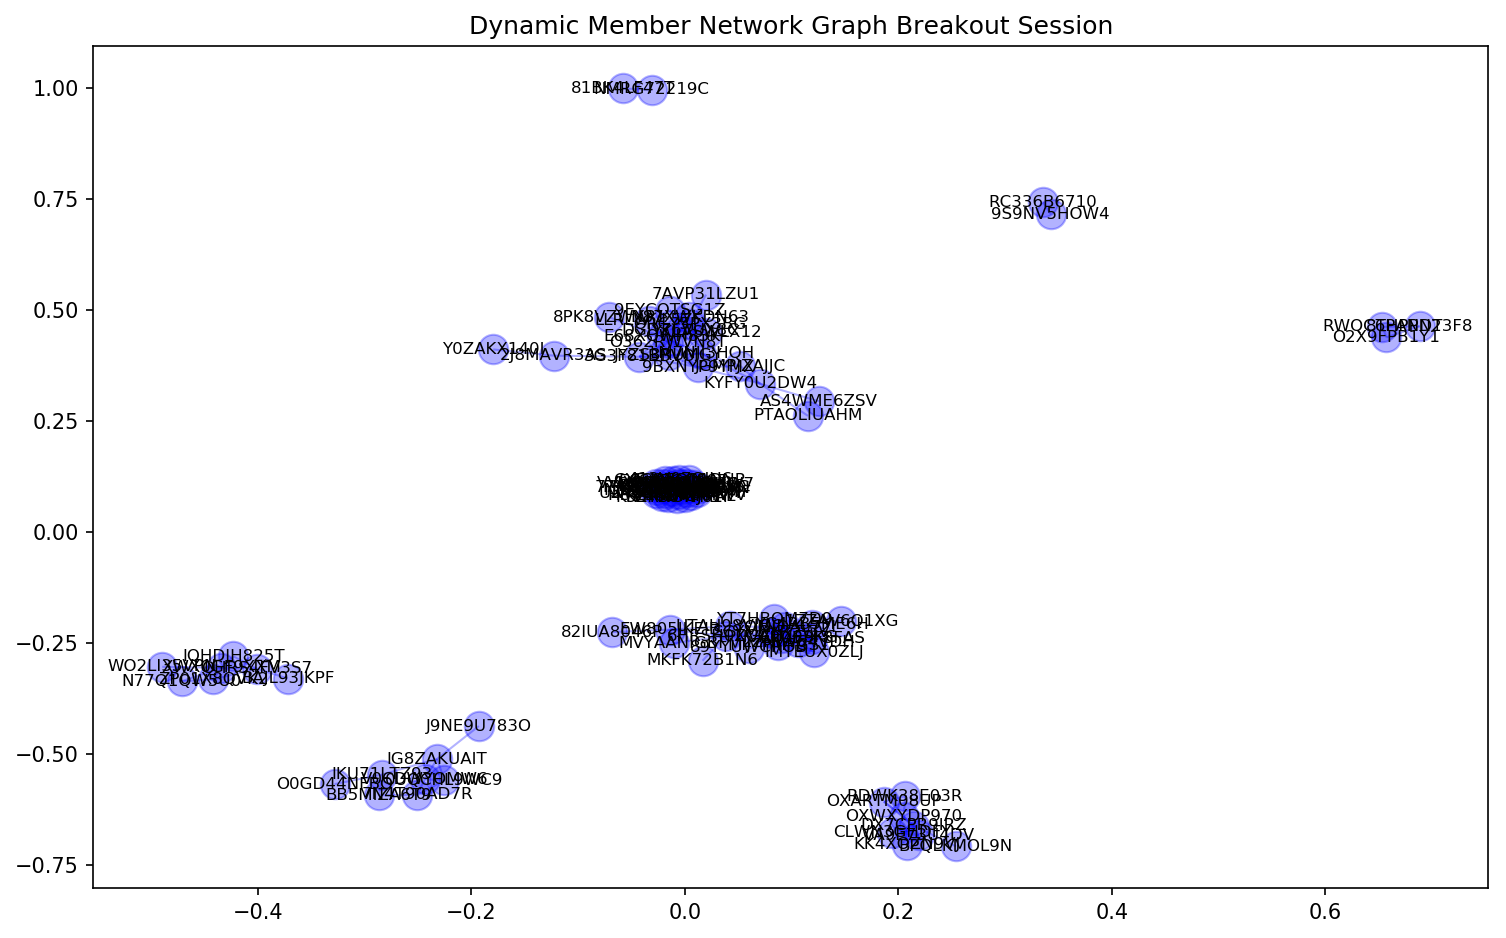

456


In [ ]:
#try time slice iteratively
# Filter data from specific time period
time_slices=generate_time_slices(9,50,11,20,interval=2)

# time slice creation


for i in range(1,46):
    time_slice = time_slices[i-1]
    m2m_breakout = tmp_m2ms_sorted.loc[time_slice]
    # keep only instances with strong signal
    m2m_filter_rssi = m2m_breakout[m2m_breakout.rssi >= -73].copy()
    # Count number of time members were in close proximity
    # We name the count column "weight" so that networkx will use it as weight for the spring layout
    m2m_edges = m2m_filter_rssi.groupby(['member1', 'member2'])[['rssi_weighted_mean']
                                                               ].count().rename(columns={'rssi_weighted_mean':'weight'})
    m2m_edges = m2m_edges[["weight"]].reset_index()
    # Keep strongest edges (threshold set manually)
    m2m_edges = m2m_edges[m2m_edges.weight > 1]
    print(len(m2m_edges))
    # Create a graph
    graph=nx.from_pandas_edgelist(m2m_edges, "member1", "member2", "weight")
    fig = plt.figure(figsize=(12,400), dpi=150)
    ax = plt.subplot(45,1,i)
    plt.title("Dynamic Member Network Graph Breakout Session")
    draw_graph(graph, graph_layout="spring",node_size=200)
   
plt.show()




# Interaction Network Graph
This tool helps find interaction between members in a certain amount of time with designated parameters, such as signal strength using the distribution of signal strength. This graph draws multiple pictures so that less detailed are lost in generalization. 

To choose a threshold for signal strength, the program analyzes the distribution of frequencies of signal strength and it will take the frequency of the peak -2. -2 for leave some room for fluctuation. 

In [33]:
time_interval_start_h=9
time_interval_start_m=50
time_interval_end_h=11
time_interval_end_m=20
interval=2
t_count_threshold = 2


bo1 = generate_time_points(time_interval_start_h, time_interval_start_m, 
                           time_interval_end_h, time_interval_end_m, interval)
freq_list_1 = []
for i in bo1:
    freq_list_1.append(tmp_m2ms.reset_index().set_index('datetime').loc[i])

hist_list_1 = []
for freq in freq_list_1:
    tmp_freq = []
    for row in freq.iterrows():
        tmp = [row[1][3]]*int(row[1][5])
        tmp_freq = tmp_freq + tmp
    hist_list_1.append(tmp_freq)


vals = {}
for i in range(len(hist_list_1)): 
    for j in hist_list_1[i]:
        if j not in vals.keys():
            vals[j]=1; 
        else: 
            vals[j]=vals[j]+1




In [47]:
import copy
vals_sorted = copy.deepcopy(sorted(vals.items(), key = 
             lambda vals:(vals[1], vals[0]),reverse = True))
sign_threshold = vals_sorted[1][0]
print(sign_threshold)

-73.0


In [46]:
time_slices=generate_time_slices(time_interval_start_h,time_interval_start_m,time_interval_end_h,
                                 time_interval_end_m,interval)

for i in range(1,len(time_slices)+1):
    time_slice = time_slices[i-1]
    m2m_breakout = tmp_m2ms_sorted.loc[time_slice]
    # keep only instances with strong signal
    m2m_filter_rssi = m2m_breakout[m2m_breakout.rssi >= sign_threshold].copy()
    # Count number of time members were in close proximity
    # We name the count column "weight" so that networkx will use it as weight for the spring layout
    m2m_edges = m2m_filter_rssi.groupby(['member1', 'member2'])[['rssi_weighted_mean']
                                                               ].count().rename(columns={'rssi_weighted_mean':'weight'})
    m2m_edges = m2m_edges[["weight"]].reset_index()
    # Keep strongest edges (threshold set manually)
    m2m_edges = m2m_edges[m2m_edges.weight > interval/2]
    if i == 1: 
        m2m_edges_count = m2m_edges.copy().assign(t_count = [1 for x in range(1,len(m2m_edges['member1'])+1)])
        m2m_edges_count = m2m_edges_count.assign(appeared = [False for x in range(1,len(m2m_edges_count)+1)])
    else: 
        for h in range(1,len(m2m_edges['member1'])):        
            for j in range(1,len(m2m_edges_count['member1'])):
                if m2m_edges.iloc[h,0]==m2m_edges_count.iloc[j,0] and m2m_edges.iloc[h,1]==m2m_edges_count.iloc[j,1]: 
                    m2m_edges_count.iloc[j,3]=m2m_edges_count.iloc[j,3]+1 
                    m2m_edges_count.iloc[j,4]=True
                elif j==len(m2m_edges_count['member1']):
                    m2m_edges_count.append({'member1':m2m_edges.iloc[h,0],'member2':m2m_edges.iloc[h,1],
                                            'weight':m2m_edges.iloc[h,2],'t_count':m2m_edges.iloc[h,3],
                                           'appeared':True})
        for j in m2m_edges_count.index.values:            
            if m2m_edges_count.loc[j,'appeared']==False:
                if m2m_edges_count.loc[j,'t_count']<t_count_threshold: 
                    m2m_edges_count.drop(j,inplace=True)
            else: 
                m2m_edges_count.loc[j,'appeared']=False


        


      member1     member2  weight  t_count  appeared
6  1Y0FTAVJTQ  3N99XO8HLY       2        1     False
      member1     member2  weight  t_count  appeared
7  1Y0FTAVJTQ  413V07OIU6       2        1     False
      member1     member2  weight  t_count  appeared
8  1Y0FTAVJTQ  5EL9YCHKZW       2        1     False
      member1     member2  weight  t_count  appeared
9  1Y0FTAVJTQ  5JXIHCGASC       2        1     False
       member1     member2  weight  t_count  appeared
10  1Y0FTAVJTQ  5VTQOYMDXP       2        1     False
       member1     member2  weight  t_count  appeared
11  1Y0FTAVJTQ  6MHNKMDN3Q       2        1     False
       member1     member2  weight  t_count  appeared
12  1Y0FTAVJTQ  77XWMB0OYS       2        1     False
       member1     member2  weight  t_count  appeared
13  1Y0FTAVJTQ  9H8DICFPAE       2        1     False
       member1     member2  weight  t_count  appeared
14  1Y0FTAVJTQ  ASGTO01DNR       2        1     False
       member1     member2  weight  

        member1     member2  weight  t_count  appeared
123  413V07OIU6  NI0TDDLD7F       2        1     False
        member1     member2  weight  t_count  appeared
124  413V07OIU6  PHTQOKWUNK       2        1     False
        member1     member2  weight  t_count  appeared
125  413V07OIU6  U242CQ4MX8       2        1     False
        member1     member2  weight  t_count  appeared
126  413V07OIU6  VVVQLVOOD1       2        1     False
        member1     member2  weight  t_count  appeared
127  413V07OIU6  W08M5SYCVN       2        1     False
        member1     member2  weight  t_count  appeared
128  413V07OIU6  W7SXW19MPM       2        1     False
        member1     member2  weight  t_count  appeared
129  5EL9YCHKZW  5JXIHCGASC       2        1     False
        member1     member2  weight  t_count  appeared
130  5EL9YCHKZW  5VTQOYMDXP       2        1     False
        member1     member2  weight  t_count  appeared
131  5EL9YCHKZW  6MHNKMDN3Q       2        1     False
        me

        member1     member2  weight  t_count  appeared
219  6MHNKMDN3Q  PHTQOKWUNK       2        1     False
        member1     member2  weight  t_count  appeared
220  6MHNKMDN3Q  U242CQ4MX8       2        1     False
        member1     member2  weight  t_count  appeared
221  6MHNKMDN3Q  VVVQLVOOD1       2        1     False
        member1     member2  weight  t_count  appeared
222  6MHNKMDN3Q  W08M5SYCVN       2        1     False
        member1     member2  weight  t_count  appeared
223  6MHNKMDN3Q  W7SXW19MPM       2        1     False
        member1     member2  weight  t_count  appeared
224  77XWMB0OYS  9H8DICFPAE       2        1     False
        member1     member2  weight  t_count  appeared
225  77XWMB0OYS  ASGTO01DNR       2        1     False
        member1     member2  weight  t_count  appeared
226  77XWMB0OYS  CXF4MJ608A       2        1     False
        member1     member2  weight  t_count  appeared
227  77XWMB0OYS  DHSPP0NHW7       2        1     False
        me

        member1     member2  weight  t_count  appeared
331  CXF4MJ608A  W7SXW19MPM       2        1     False
        member1     member2  weight  t_count  appeared
332  DGDZ6VUX8C  LM7NJI3HQH       2        1     False
        member1     member2  weight  t_count  appeared
335  DHSPP0NHW7  E6S8PGO69F       2        1     False
        member1     member2  weight  t_count  appeared
336  DHSPP0NHW7  EILUW6ISGU       2        1     False
        member1     member2  weight  t_count  appeared
337  DHSPP0NHW7  EJCJZNKPMG       2        1     False
        member1     member2  weight  t_count  appeared
338  DHSPP0NHW7  HBVNN0KU8I       2        1     False
        member1     member2  weight  t_count  appeared
339  DHSPP0NHW7  K05UC9Y0NF       2        1     False
        member1     member2  weight  t_count  appeared
340  DHSPP0NHW7  K2TE4D16C5       2        1     False
        member1     member2  weight  t_count  appeared
341  DHSPP0NHW7  K35TB04FFB       2        1     False
        me

        member1     member2  weight  t_count  appeared
436  K2TE4D16C5  W7SXW19MPM       2        1     False
        member1     member2  weight  t_count  appeared
437  K35TB04FFB  KZRNONJ61I       2        1     False
        member1     member2  weight  t_count  appeared
438  K35TB04FFB  NI0TDDLD7F       2        1     False
        member1     member2  weight  t_count  appeared
439  K35TB04FFB  PHTQOKWUNK       2        1     False
        member1     member2  weight  t_count  appeared
440  K35TB04FFB  U242CQ4MX8       2        1     False
        member1     member2  weight  t_count  appeared
441  K35TB04FFB  VVVQLVOOD1       2        1     False
        member1     member2  weight  t_count  appeared
442  K35TB04FFB  W08M5SYCVN       2        1     False
        member1     member2  weight  t_count  appeared
443  K35TB04FFB  W7SXW19MPM       2        1     False
        member1     member2  weight  t_count  appeared
444  KK4XOZN9VJ  O362RWVN8T       2        1     False
        me

       member1     member2  weight  t_count  appeared
84  3N99XO8HLY  5JXIHCGASC       2        2     False
       member1     member2  weight  t_count  appeared
85  3N99XO8HLY  5VTQOYMDXP       2        2     False
       member1     member2  weight  t_count  appeared
86  3N99XO8HLY  6MHNKMDN3Q       2        2     False
       member1     member2  weight  t_count  appeared
87  3N99XO8HLY  77XWMB0OYS       2        2     False
       member1     member2  weight  t_count  appeared
88  3N99XO8HLY  9H8DICFPAE       2        2     False
       member1     member2  weight  t_count  appeared
89  3N99XO8HLY  ASGTO01DNR       2        2     False
       member1     member2  weight  t_count  appeared
90  3N99XO8HLY  CXF4MJ608A       2        2     False
       member1     member2  weight  t_count  appeared
91  3N99XO8HLY  DHSPP0NHW7       2        2     False
       member1     member2  weight  t_count  appeared
92  3N99XO8HLY  E6S8PGO69F       2        2     False
       member1     member2  

        member1     member2  weight  t_count  appeared
167  5JXIHCGASC  PHTQOKWUNK       2        2     False
        member1     member2  weight  t_count  appeared
168  5JXIHCGASC  U242CQ4MX8       2        2     False
        member1     member2  weight  t_count  appeared
169  5JXIHCGASC  VVVQLVOOD1       2        2     False
        member1     member2  weight  t_count  appeared
170  5JXIHCGASC  W08M5SYCVN       2        2     False
        member1     member2  weight  t_count  appeared
171  5JXIHCGASC  W7SXW19MPM       2        2     False
        member1     member2  weight  t_count  appeared
172  5VTQOYMDXP  6MHNKMDN3Q       2        2     False
        member1     member2  weight  t_count  appeared
173  5VTQOYMDXP  77XWMB0OYS       2        2     False
        member1     member2  weight  t_count  appeared
174  5VTQOYMDXP  9H8DICFPAE       2        2     False
        member1     member2  weight  t_count  appeared
175  5VTQOYMDXP  ASGTO01DNR       2        2     False
        me

        member1     member2  weight  t_count  appeared
282  9H8DICFPAE  VVVQLVOOD1       2        2     False
        member1     member2  weight  t_count  appeared
283  9H8DICFPAE  W08M5SYCVN       2        2     False
        member1     member2  weight  t_count  appeared
284  9H8DICFPAE  W7SXW19MPM       2        2     False
        member1     member2  weight  t_count  appeared
287  ASGTO01DNR  CXF4MJ608A       2        2     False
        member1     member2  weight  t_count  appeared
288  ASGTO01DNR  DHSPP0NHW7       2        2     False
        member1     member2  weight  t_count  appeared
289  ASGTO01DNR  E6S8PGO69F       2        2     False
        member1     member2  weight  t_count  appeared
290  ASGTO01DNR  EILUW6ISGU       2        2     False
        member1     member2  weight  t_count  appeared
291  ASGTO01DNR  EJCJZNKPMG       2        2     False
        member1     member2  weight  t_count  appeared
292  ASGTO01DNR  HBVNN0KU8I       2        2     False
        me

        member1     member2  weight  t_count  appeared
389  EJCJZNKPMG  W7SXW19MPM       2        2     False
        member1     member2  weight  t_count  appeared
390  ER0BPF8FAS  IMTEUX0ZLJ       2        2     False
        member1     member2  weight  t_count  appeared
398  F4VB4QJ7G8  WO2LI35VPN       2        2     False
        member1     member2  weight  t_count  appeared
399  HBVNN0KU8I  K05UC9Y0NF       2        2     False
        member1     member2  weight  t_count  appeared
400  HBVNN0KU8I  K2TE4D16C5       2        2     False
        member1     member2  weight  t_count  appeared
401  HBVNN0KU8I  K35TB04FFB       2        2     False
        member1     member2  weight  t_count  appeared
402  HBVNN0KU8I  KZRNONJ61I       2        2     False
        member1     member2  weight  t_count  appeared
403  HBVNN0KU8I  NI0TDDLD7F       2        2     False
        member1     member2  weight  t_count  appeared
404  HBVNN0KU8I  PHTQOKWUNK       2        2     False
        me

       member1     member2  weight  t_count  appeared
24  1Y0FTAVJTQ  KZRNONJ61I       2        3     False
       member1     member2  weight  t_count  appeared
25  1Y0FTAVJTQ  NI0TDDLD7F       2        3     False
       member1     member2  weight  t_count  appeared
26  1Y0FTAVJTQ  PHTQOKWUNK       2        3     False
       member1     member2  weight  t_count  appeared
27  1Y0FTAVJTQ  U242CQ4MX8       2        3     False
       member1     member2  weight  t_count  appeared
28  1Y0FTAVJTQ  VVVQLVOOD1       2        3     False
       member1     member2  weight  t_count  appeared
29  1Y0FTAVJTQ  W08M5SYCVN       2        3     False
       member1     member2  weight  t_count  appeared
30  1Y0FTAVJTQ  W7SXW19MPM       2        3     False
       member1     member2  weight  t_count  appeared
35  1ZZAV6Q1XG  PNVAQ4FSKG       2        3     False
       member1     member2  weight  t_count  appeared
39  1ZZAV6Q1XG  YOMIDAL72I       2        3     False
       member1     member2  

        member1     member2  weight  t_count  appeared
132  5EL9YCHKZW  77XWMB0OYS       2        3     False
        member1     member2  weight  t_count  appeared
133  5EL9YCHKZW  9H8DICFPAE       2        3     False
        member1     member2  weight  t_count  appeared
134  5EL9YCHKZW  ASGTO01DNR       2        3     False
        member1     member2  weight  t_count  appeared
135  5EL9YCHKZW  CXF4MJ608A       2        3     False
        member1     member2  weight  t_count  appeared
136  5EL9YCHKZW  DHSPP0NHW7       2        3     False
        member1     member2  weight  t_count  appeared
137  5EL9YCHKZW  E6S8PGO69F       2        3     False
        member1     member2  weight  t_count  appeared
138  5EL9YCHKZW  EILUW6ISGU       2        3     False
        member1     member2  weight  t_count  appeared
139  5EL9YCHKZW  EJCJZNKPMG       2        3     False
        member1     member2  weight  t_count  appeared
140  5EL9YCHKZW  HBVNN0KU8I       2        3     False
        me

        member1     member2  weight  t_count  appeared
225  77XWMB0OYS  ASGTO01DNR       2        3     False
        member1     member2  weight  t_count  appeared
226  77XWMB0OYS  CXF4MJ608A       2        3     False
        member1     member2  weight  t_count  appeared
227  77XWMB0OYS  DHSPP0NHW7       2        3     False
        member1     member2  weight  t_count  appeared
228  77XWMB0OYS  E6S8PGO69F       2        3     False
        member1     member2  weight  t_count  appeared
229  77XWMB0OYS  EILUW6ISGU       2        3     False
        member1     member2  weight  t_count  appeared
230  77XWMB0OYS  EJCJZNKPMG       2        3     False
        member1     member2  weight  t_count  appeared
231  77XWMB0OYS  HBVNN0KU8I       2        3     False
        member1     member2  weight  t_count  appeared
232  77XWMB0OYS  K05UC9Y0NF       2        3     False
        member1     member2  weight  t_count  appeared
233  77XWMB0OYS  K2TE4D16C5       2        3     False
        me

        member1     member2  weight  t_count  appeared
345  DHSPP0NHW7  U242CQ4MX8       2        3     False
        member1     member2  weight  t_count  appeared
346  DHSPP0NHW7  VVVQLVOOD1       2        3     False
        member1     member2  weight  t_count  appeared
347  DHSPP0NHW7  W08M5SYCVN       2        3     False
        member1     member2  weight  t_count  appeared
348  DHSPP0NHW7  W7SXW19MPM       2        3     False
        member1     member2  weight  t_count  appeared
354  E6S8PGO69F  EILUW6ISGU       2        3     False
        member1     member2  weight  t_count  appeared
355  E6S8PGO69F  EJCJZNKPMG       2        3     False
        member1     member2  weight  t_count  appeared
356  E6S8PGO69F  HBVNN0KU8I       2        3     False
        member1     member2  weight  t_count  appeared
357  E6S8PGO69F  K05UC9Y0NF       2        3     False
        member1     member2  weight  t_count  appeared
358  E6S8PGO69F  K2TE4D16C5       2        3     False
        me

        member1     member2  weight  t_count  appeared
451  KZRNONJ61I  VVVQLVOOD1       2        3     False
        member1     member2  weight  t_count  appeared
452  KZRNONJ61I  W08M5SYCVN       2        3     False
        member1     member2  weight  t_count  appeared
453  KZRNONJ61I  W7SXW19MPM       2        3     False
        member1     member2  weight  t_count  appeared
454  LM7NJI3HQH  N87XWKDN63       2        2     False
        member1     member2  weight  t_count  appeared
460  N7X3CND9H8  RC336B6710       2        3     False
        member1     member2  weight  t_count  appeared
462  NI0TDDLD7F  PHTQOKWUNK       2        3     False
        member1     member2  weight  t_count  appeared
463  NI0TDDLD7F  U242CQ4MX8       2        3     False
        member1     member2  weight  t_count  appeared
464  NI0TDDLD7F  VVVQLVOOD1       2        3     False
        member1     member2  weight  t_count  appeared
465  NI0TDDLD7F  W08M5SYCVN       2        3     False
        me

       member1     member2  weight  t_count  appeared
78  2ZNIW64VDH  UTAH98VIOQ       2        4     False
       member1     member2  weight  t_count  appeared
81  2ZNIW64VDH  YOMIDAL72I       2        4     False
       member1     member2  weight  t_count  appeared
82  3N99XO8HLY  413V07OIU6       2        4     False
       member1     member2  weight  t_count  appeared
83  3N99XO8HLY  5EL9YCHKZW       2        4     False
       member1     member2  weight  t_count  appeared
84  3N99XO8HLY  5JXIHCGASC       2        4     False
       member1     member2  weight  t_count  appeared
85  3N99XO8HLY  5VTQOYMDXP       2        4     False
       member1     member2  weight  t_count  appeared
86  3N99XO8HLY  6MHNKMDN3Q       2        4     False
       member1     member2  weight  t_count  appeared
87  3N99XO8HLY  77XWMB0OYS       2        4     False
       member1     member2  weight  t_count  appeared
88  3N99XO8HLY  9H8DICFPAE       2        4     False
       member1     member2  

161  5JXIHCGASC  HBVNN0KU8I       2        4     False
        member1     member2  weight  t_count  appeared
162  5JXIHCGASC  K05UC9Y0NF       2        4     False
        member1     member2  weight  t_count  appeared
163  5JXIHCGASC  K2TE4D16C5       2        4     False
        member1     member2  weight  t_count  appeared
165  5JXIHCGASC  KZRNONJ61I       2        4     False
        member1     member2  weight  t_count  appeared
166  5JXIHCGASC  NI0TDDLD7F       2        4     False
        member1     member2  weight  t_count  appeared
167  5JXIHCGASC  PHTQOKWUNK       2        4     False
        member1     member2  weight  t_count  appeared
168  5JXIHCGASC  U242CQ4MX8       2        4     False
        member1     member2  weight  t_count  appeared
169  5JXIHCGASC  VVVQLVOOD1       2        4     False
        member1     member2  weight  t_count  appeared
170  5JXIHCGASC  W08M5SYCVN       2        4     False
        member1     member2  weight  t_count  appeared
171  5JXIH

        member1     member2  weight  t_count  appeared
275  9H8DICFPAE  K05UC9Y0NF       2        4     False
        member1     member2  weight  t_count  appeared
276  9H8DICFPAE  K2TE4D16C5       2        4     False
        member1     member2  weight  t_count  appeared
277  9H8DICFPAE  K35TB04FFB       2        4     False
        member1     member2  weight  t_count  appeared
278  9H8DICFPAE  KZRNONJ61I       2        4     False
        member1     member2  weight  t_count  appeared
279  9H8DICFPAE  NI0TDDLD7F       2        4     False
        member1     member2  weight  t_count  appeared
280  9H8DICFPAE  PHTQOKWUNK       2        4     False
        member1     member2  weight  t_count  appeared
281  9H8DICFPAE  U242CQ4MX8       2        4     False
        member1     member2  weight  t_count  appeared
282  9H8DICFPAE  VVVQLVOOD1       2        4     False
        member1     member2  weight  t_count  appeared
283  9H8DICFPAE  W08M5SYCVN       2        4     False
        me

        member1     member2  weight  t_count  appeared
384  EJCJZNKPMG  NI0TDDLD7F       2        4     False
        member1     member2  weight  t_count  appeared
385  EJCJZNKPMG  PHTQOKWUNK       2        4     False
        member1     member2  weight  t_count  appeared
386  EJCJZNKPMG  U242CQ4MX8       2        4     False
        member1     member2  weight  t_count  appeared
387  EJCJZNKPMG  VVVQLVOOD1       2        4     False
        member1     member2  weight  t_count  appeared
388  EJCJZNKPMG  W08M5SYCVN       2        4     False
        member1     member2  weight  t_count  appeared
389  EJCJZNKPMG  W7SXW19MPM       2        4     False
        member1     member2  weight  t_count  appeared
390  ER0BPF8FAS  IMTEUX0ZLJ       2        4     False
        member1     member2  weight  t_count  appeared
398  F4VB4QJ7G8  WO2LI35VPN       2        2     False
        member1     member2  weight  t_count  appeared
399  HBVNN0KU8I  K05UC9Y0NF       2        4     False
        me

48  2LF6XKYHWV  5JXIHCGASC       2        5     False
       member1     member2  weight  t_count  appeared
49  2LF6XKYHWV  5VTQOYMDXP       2        5     False
       member1     member2  weight  t_count  appeared
50  2LF6XKYHWV  6MHNKMDN3Q       2        5     False
       member1     member2  weight  t_count  appeared
51  2LF6XKYHWV  77XWMB0OYS       2        5     False
       member1     member2  weight  t_count  appeared
52  2LF6XKYHWV  9H8DICFPAE       2        5     False
       member1     member2  weight  t_count  appeared
53  2LF6XKYHWV  ASGTO01DNR       2        5     False
       member1     member2  weight  t_count  appeared
54  2LF6XKYHWV  CXF4MJ608A       2        5     False
       member1     member2  weight  t_count  appeared
55  2LF6XKYHWV  DHSPP0NHW7       2        5     False
       member1     member2  weight  t_count  appeared
56  2LF6XKYHWV  E6S8PGO69F       2        5     False
       member1     member2  weight  t_count  appeared
57  2LF6XKYHWV  EILUW6ISGU  

        member1     member2  weight  t_count  appeared
139  5EL9YCHKZW  EJCJZNKPMG       2        5     False
        member1     member2  weight  t_count  appeared
140  5EL9YCHKZW  HBVNN0KU8I       2        5     False
        member1     member2  weight  t_count  appeared
141  5EL9YCHKZW  K05UC9Y0NF       2        5     False
        member1     member2  weight  t_count  appeared
142  5EL9YCHKZW  K2TE4D16C5       2        5     False
        member1     member2  weight  t_count  appeared
143  5EL9YCHKZW  K35TB04FFB       2        5     False
        member1     member2  weight  t_count  appeared
144  5EL9YCHKZW  KZRNONJ61I       2        5     False
        member1     member2  weight  t_count  appeared
145  5EL9YCHKZW  NI0TDDLD7F       2        5     False
        member1     member2  weight  t_count  appeared
146  5EL9YCHKZW  PHTQOKWUNK       2        5     False
        member1     member2  weight  t_count  appeared
147  5EL9YCHKZW  U242CQ4MX8       2        5     False
        me

226  77XWMB0OYS  CXF4MJ608A       2        5     False
        member1     member2  weight  t_count  appeared
227  77XWMB0OYS  DHSPP0NHW7       2        5     False
        member1     member2  weight  t_count  appeared
228  77XWMB0OYS  E6S8PGO69F       2        5     False
        member1     member2  weight  t_count  appeared
229  77XWMB0OYS  EILUW6ISGU       2        5     False
        member1     member2  weight  t_count  appeared
230  77XWMB0OYS  EJCJZNKPMG       2        5     False
        member1     member2  weight  t_count  appeared
231  77XWMB0OYS  HBVNN0KU8I       2        5     False
        member1     member2  weight  t_count  appeared
232  77XWMB0OYS  K05UC9Y0NF       2        5     False
        member1     member2  weight  t_count  appeared
233  77XWMB0OYS  K2TE4D16C5       2        5     False
        member1     member2  weight  t_count  appeared
234  77XWMB0OYS  K35TB04FFB       2        5     False
        member1     member2  weight  t_count  appeared
235  77XWM

        member1     member2  weight  t_count  appeared
359  E6S8PGO69F  K35TB04FFB       2        5     False
        member1     member2  weight  t_count  appeared
360  E6S8PGO69F  KZRNONJ61I       2        5     False
        member1     member2  weight  t_count  appeared
361  E6S8PGO69F  NI0TDDLD7F       2        5     False
        member1     member2  weight  t_count  appeared
362  E6S8PGO69F  PHTQOKWUNK       2        5     False
        member1     member2  weight  t_count  appeared
363  E6S8PGO69F  U242CQ4MX8       2        5     False
        member1     member2  weight  t_count  appeared
364  E6S8PGO69F  VVVQLVOOD1       2        5     False
        member1     member2  weight  t_count  appeared
365  E6S8PGO69F  W08M5SYCVN       2        5     False
        member1     member2  weight  t_count  appeared
366  E6S8PGO69F  W7SXW19MPM       2        5     False
        member1     member2  weight  t_count  appeared
367  EILUW6ISGU  EJCJZNKPMG       2        5     False
        me

        member1     member2  weight  t_count  appeared
454  LM7NJI3HQH  N87XWKDN63       2        4     False
        member1     member2  weight  t_count  appeared
460  N7X3CND9H8  RC336B6710       2        5     False
        member1     member2  weight  t_count  appeared
462  NI0TDDLD7F  PHTQOKWUNK       2        5     False
        member1     member2  weight  t_count  appeared
463  NI0TDDLD7F  U242CQ4MX8       2        5     False
        member1     member2  weight  t_count  appeared
464  NI0TDDLD7F  VVVQLVOOD1       2        5     False
        member1     member2  weight  t_count  appeared
465  NI0TDDLD7F  W08M5SYCVN       2        5     False
        member1     member2  weight  t_count  appeared
466  NI0TDDLD7F  W7SXW19MPM       2        5     False
        member1     member2  weight  t_count  appeared
468  OXARTM08UP  OXWXYDP970       2        5     False
        member1     member2  weight  t_count  appeared
469  OXARTM08UP  RDWK38E03R       2        5     False
        me

       member1     member2  weight  t_count  appeared
82  3N99XO8HLY  413V07OIU6       2        6     False
       member1     member2  weight  t_count  appeared
83  3N99XO8HLY  5EL9YCHKZW       2        6     False
       member1     member2  weight  t_count  appeared
84  3N99XO8HLY  5JXIHCGASC       2        6     False
       member1     member2  weight  t_count  appeared
85  3N99XO8HLY  5VTQOYMDXP       2        6     False
       member1     member2  weight  t_count  appeared
86  3N99XO8HLY  6MHNKMDN3Q       2        6     False
       member1     member2  weight  t_count  appeared
87  3N99XO8HLY  77XWMB0OYS       2        6     False
       member1     member2  weight  t_count  appeared
88  3N99XO8HLY  9H8DICFPAE       2        6     False
       member1     member2  weight  t_count  appeared
89  3N99XO8HLY  ASGTO01DNR       2        6     False
       member1     member2  weight  t_count  appeared
90  3N99XO8HLY  CXF4MJ608A       2        6     False
       member1     member2  

        member1     member2  weight  t_count  appeared
160  5JXIHCGASC  EJCJZNKPMG       2        6     False
        member1     member2  weight  t_count  appeared
161  5JXIHCGASC  HBVNN0KU8I       2        6     False
        member1     member2  weight  t_count  appeared
162  5JXIHCGASC  K05UC9Y0NF       2        6     False
        member1     member2  weight  t_count  appeared
163  5JXIHCGASC  K2TE4D16C5       2        6     False
        member1     member2  weight  t_count  appeared
165  5JXIHCGASC  KZRNONJ61I       2        6     False
        member1     member2  weight  t_count  appeared
166  5JXIHCGASC  NI0TDDLD7F       2        6     False
        member1     member2  weight  t_count  appeared
167  5JXIHCGASC  PHTQOKWUNK       2        6     False
        member1     member2  weight  t_count  appeared
168  5JXIHCGASC  U242CQ4MX8       2        6     False
        member1     member2  weight  t_count  appeared
169  5JXIHCGASC  VVVQLVOOD1       2        6     False
        me

299  ASGTO01DNR  U242CQ4MX8       2        6     False
        member1     member2  weight  t_count  appeared
300  ASGTO01DNR  VVVQLVOOD1       2        6     False
        member1     member2  weight  t_count  appeared
301  ASGTO01DNR  W08M5SYCVN       2        6     False
        member1     member2  weight  t_count  appeared
302  ASGTO01DNR  W7SXW19MPM       2        6     False
        member1     member2  weight  t_count  appeared
309  BB5MIZA6T9  V0CDWYOMW6       2        4     False
        member1     member2  weight  t_count  appeared
317  CXF4MJ608A  DHSPP0NHW7       2        6     False
        member1     member2  weight  t_count  appeared
318  CXF4MJ608A  E6S8PGO69F       2        6     False
        member1     member2  weight  t_count  appeared
319  CXF4MJ608A  EILUW6ISGU       2        6     False
        member1     member2  weight  t_count  appeared
320  CXF4MJ608A  EJCJZNKPMG       2        6     False
        member1     member2  weight  t_count  appeared
321  CXF4M

        member1     member2  weight  t_count  appeared
401  HBVNN0KU8I  K35TB04FFB       2        6     False
        member1     member2  weight  t_count  appeared
402  HBVNN0KU8I  KZRNONJ61I       2        6     False
        member1     member2  weight  t_count  appeared
403  HBVNN0KU8I  NI0TDDLD7F       2        6     False
        member1     member2  weight  t_count  appeared
404  HBVNN0KU8I  PHTQOKWUNK       2        6     False
        member1     member2  weight  t_count  appeared
405  HBVNN0KU8I  U242CQ4MX8       2        6     False
        member1     member2  weight  t_count  appeared
406  HBVNN0KU8I  VVVQLVOOD1       2        6     False
        member1     member2  weight  t_count  appeared
407  HBVNN0KU8I  W08M5SYCVN       2        6     False
        member1     member2  weight  t_count  appeared
408  HBVNN0KU8I  W7SXW19MPM       2        6     False
        member1     member2  weight  t_count  appeared
410  IKU71LTZ93  V0CDWYOMW6       2        5     False
        me

       member1     member2  weight  t_count  appeared
39  1ZZAV6Q1XG  YOMIDAL72I       2        6     False
       member1     member2  weight  t_count  appeared
43  2J8MAVR3AS  Y0ZAKX140I       2        5     False
       member1     member2  weight  t_count  appeared
45  2LF6XKYHWV  3N99XO8HLY       2        7     False
       member1     member2  weight  t_count  appeared
46  2LF6XKYHWV  413V07OIU6       2        7     False
       member1     member2  weight  t_count  appeared
47  2LF6XKYHWV  5EL9YCHKZW       2        7     False
       member1     member2  weight  t_count  appeared
48  2LF6XKYHWV  5JXIHCGASC       2        7     False
       member1     member2  weight  t_count  appeared
49  2LF6XKYHWV  5VTQOYMDXP       2        7     False
       member1     member2  weight  t_count  appeared
50  2LF6XKYHWV  6MHNKMDN3Q       2        7     False
       member1     member2  weight  t_count  appeared
51  2LF6XKYHWV  77XWMB0OYS       2        7     False
       member1     member2  

        member1     member2  weight  t_count  appeared
136  5EL9YCHKZW  DHSPP0NHW7       2        7     False
        member1     member2  weight  t_count  appeared
137  5EL9YCHKZW  E6S8PGO69F       2        7     False
        member1     member2  weight  t_count  appeared
138  5EL9YCHKZW  EILUW6ISGU       2        7     False
        member1     member2  weight  t_count  appeared
139  5EL9YCHKZW  EJCJZNKPMG       2        7     False
        member1     member2  weight  t_count  appeared
140  5EL9YCHKZW  HBVNN0KU8I       2        7     False
        member1     member2  weight  t_count  appeared
141  5EL9YCHKZW  K05UC9Y0NF       2        7     False
        member1     member2  weight  t_count  appeared
142  5EL9YCHKZW  K2TE4D16C5       2        7     False
        member1     member2  weight  t_count  appeared
143  5EL9YCHKZW  K35TB04FFB       2        7     False
        member1     member2  weight  t_count  appeared
144  5EL9YCHKZW  KZRNONJ61I       2        7     False
        me

        member1     member2  weight  t_count  appeared
229  77XWMB0OYS  EILUW6ISGU       2        7     False
        member1     member2  weight  t_count  appeared
230  77XWMB0OYS  EJCJZNKPMG       2        7     False
        member1     member2  weight  t_count  appeared
231  77XWMB0OYS  HBVNN0KU8I       2        7     False
        member1     member2  weight  t_count  appeared
232  77XWMB0OYS  K05UC9Y0NF       2        7     False
        member1     member2  weight  t_count  appeared
233  77XWMB0OYS  K2TE4D16C5       2        7     False
        member1     member2  weight  t_count  appeared
234  77XWMB0OYS  K35TB04FFB       2        7     False
        member1     member2  weight  t_count  appeared
235  77XWMB0OYS  KZRNONJ61I       2        7     False
        member1     member2  weight  t_count  appeared
236  77XWMB0OYS  NI0TDDLD7F       2        7     False
        member1     member2  weight  t_count  appeared
237  77XWMB0OYS  PHTQOKWUNK       2        7     False
        me

        member1     member2  weight  t_count  appeared
359  E6S8PGO69F  K35TB04FFB       2        7     False
        member1     member2  weight  t_count  appeared
360  E6S8PGO69F  KZRNONJ61I       2        7     False
        member1     member2  weight  t_count  appeared
361  E6S8PGO69F  NI0TDDLD7F       2        7     False
        member1     member2  weight  t_count  appeared
362  E6S8PGO69F  PHTQOKWUNK       2        7     False
        member1     member2  weight  t_count  appeared
363  E6S8PGO69F  U242CQ4MX8       2        7     False
        member1     member2  weight  t_count  appeared
364  E6S8PGO69F  VVVQLVOOD1       2        7     False
        member1     member2  weight  t_count  appeared
365  E6S8PGO69F  W08M5SYCVN       2        7     False
        member1     member2  weight  t_count  appeared
366  E6S8PGO69F  W7SXW19MPM       2        7     False
        member1     member2  weight  t_count  appeared
367  EILUW6ISGU  EJCJZNKPMG       2        7     False
        me

        member1     member2  weight  t_count  appeared
475  PNVAQ4FSKG  SCYM0YR2WV       2        4     False
        member1     member2  weight  t_count  appeared
478  PNVAQ4FSKG  YOMIDAL72I       2        7     False
        member1     member2  weight  t_count  appeared
484  U242CQ4MX8  VVVQLVOOD1       2        7     False
        member1     member2  weight  t_count  appeared
485  U242CQ4MX8  W08M5SYCVN       2        7     False
        member1     member2  weight  t_count  appeared
486  U242CQ4MX8  W7SXW19MPM       2        7     False
        member1     member2  weight  t_count  appeared
492  VVVQLVOOD1  W08M5SYCVN       2        7     False
        member1     member2  weight  t_count  appeared
493  VVVQLVOOD1  W7SXW19MPM       2        7     False
        member1     member2  weight  t_count  appeared
494  W08M5SYCVN  W7SXW19MPM       2        7     False
      member1     member2  weight  t_count  appeared
7  1Y0FTAVJTQ  413V07OIU6       2        8     False
      member1 

        member1     member2  weight  t_count  appeared
109  413V07OIU6  6MHNKMDN3Q       2        8     False
        member1     member2  weight  t_count  appeared
110  413V07OIU6  77XWMB0OYS       2        8     False
        member1     member2  weight  t_count  appeared
111  413V07OIU6  9H8DICFPAE       2        8     False
        member1     member2  weight  t_count  appeared
112  413V07OIU6  ASGTO01DNR       2        8     False
        member1     member2  weight  t_count  appeared
113  413V07OIU6  CXF4MJ608A       2        8     False
        member1     member2  weight  t_count  appeared
114  413V07OIU6  DHSPP0NHW7       2        8     False
        member1     member2  weight  t_count  appeared
115  413V07OIU6  E6S8PGO69F       2        8     False
        member1     member2  weight  t_count  appeared
116  413V07OIU6  EILUW6ISGU       2        8     False
        member1     member2  weight  t_count  appeared
117  413V07OIU6  EJCJZNKPMG       2        8     False
        me

        member1     member2  weight  t_count  appeared
206  6MHNKMDN3Q  9H8DICFPAE       2        8     False
        member1     member2  weight  t_count  appeared
207  6MHNKMDN3Q  ASGTO01DNR       2        8     False
        member1     member2  weight  t_count  appeared
208  6MHNKMDN3Q  CXF4MJ608A       2        8     False
        member1     member2  weight  t_count  appeared
209  6MHNKMDN3Q  DHSPP0NHW7       2        8     False
        member1     member2  weight  t_count  appeared
210  6MHNKMDN3Q  E6S8PGO69F       2        8     False
        member1     member2  weight  t_count  appeared
211  6MHNKMDN3Q  EILUW6ISGU       2        8     False
        member1     member2  weight  t_count  appeared
212  6MHNKMDN3Q  EJCJZNKPMG       2        8     False
        member1     member2  weight  t_count  appeared
213  6MHNKMDN3Q  HBVNN0KU8I       2        8     False
        member1     member2  weight  t_count  appeared
214  6MHNKMDN3Q  K05UC9Y0NF       2        8     False
        me

        member1     member2  weight  t_count  appeared
331  CXF4MJ608A  W7SXW19MPM       2        8     False
        member1     member2  weight  t_count  appeared
332  DGDZ6VUX8C  LM7NJI3HQH       2        8     False
        member1     member2  weight  t_count  appeared
335  DHSPP0NHW7  E6S8PGO69F       2        8     False
        member1     member2  weight  t_count  appeared
336  DHSPP0NHW7  EILUW6ISGU       2        8     False
        member1     member2  weight  t_count  appeared
337  DHSPP0NHW7  EJCJZNKPMG       2        8     False
        member1     member2  weight  t_count  appeared
338  DHSPP0NHW7  HBVNN0KU8I       2        8     False
        member1     member2  weight  t_count  appeared
339  DHSPP0NHW7  K05UC9Y0NF       2        8     False
        member1     member2  weight  t_count  appeared
340  DHSPP0NHW7  K2TE4D16C5       2        8     False
        member1     member2  weight  t_count  appeared
341  DHSPP0NHW7  K35TB04FFB       2        8     False
        me

        member1     member2  weight  t_count  appeared
451  KZRNONJ61I  VVVQLVOOD1       2        8     False
        member1     member2  weight  t_count  appeared
452  KZRNONJ61I  W08M5SYCVN       2        8     False
        member1     member2  weight  t_count  appeared
453  KZRNONJ61I  W7SXW19MPM       2        8     False
        member1     member2  weight  t_count  appeared
454  LM7NJI3HQH  N87XWKDN63       2        6     False
        member1     member2  weight  t_count  appeared
460  N7X3CND9H8  RC336B6710       2        8     False
        member1     member2  weight  t_count  appeared
462  NI0TDDLD7F  PHTQOKWUNK       2        8     False
        member1     member2  weight  t_count  appeared
463  NI0TDDLD7F  U242CQ4MX8       2        8     False
        member1     member2  weight  t_count  appeared
464  NI0TDDLD7F  VVVQLVOOD1       2        8     False
        member1     member2  weight  t_count  appeared
465  NI0TDDLD7F  W08M5SYCVN       2        8     False
        me

       member1     member2  weight  t_count  appeared
78  2ZNIW64VDH  UTAH98VIOQ       2        6     False
       member1     member2  weight  t_count  appeared
81  2ZNIW64VDH  YOMIDAL72I       2        9     False
       member1     member2  weight  t_count  appeared
82  3N99XO8HLY  413V07OIU6       2        9     False
       member1     member2  weight  t_count  appeared
83  3N99XO8HLY  5EL9YCHKZW       2        9     False
       member1     member2  weight  t_count  appeared
84  3N99XO8HLY  5JXIHCGASC       2        9     False
       member1     member2  weight  t_count  appeared
85  3N99XO8HLY  5VTQOYMDXP       2        9     False
       member1     member2  weight  t_count  appeared
86  3N99XO8HLY  6MHNKMDN3Q       2        9     False
       member1     member2  weight  t_count  appeared
87  3N99XO8HLY  77XWMB0OYS       2        9     False
       member1     member2  weight  t_count  appeared
88  3N99XO8HLY  9H8DICFPAE       2        9     False
       member1     member2  

        member1     member2  weight  t_count  appeared
181  5VTQOYMDXP  HBVNN0KU8I       2        9     False
        member1     member2  weight  t_count  appeared
182  5VTQOYMDXP  K05UC9Y0NF       2        9     False
        member1     member2  weight  t_count  appeared
183  5VTQOYMDXP  K2TE4D16C5       2        9     False
        member1     member2  weight  t_count  appeared
184  5VTQOYMDXP  K35TB04FFB       2        9     False
        member1     member2  weight  t_count  appeared
185  5VTQOYMDXP  KZRNONJ61I       2        9     False
        member1     member2  weight  t_count  appeared
186  5VTQOYMDXP  NI0TDDLD7F       2        9     False
        member1     member2  weight  t_count  appeared
187  5VTQOYMDXP  PHTQOKWUNK       2        9     False
        member1     member2  weight  t_count  appeared
188  5VTQOYMDXP  U242CQ4MX8       2        9     False
        member1     member2  weight  t_count  appeared
189  5VTQOYMDXP  VVVQLVOOD1       2        9     False
        me

        member1     member2  weight  t_count  appeared
296  ASGTO01DNR  KZRNONJ61I       2        9     False
        member1     member2  weight  t_count  appeared
297  ASGTO01DNR  NI0TDDLD7F       2        9     False
        member1     member2  weight  t_count  appeared
298  ASGTO01DNR  PHTQOKWUNK       2        9     False
        member1     member2  weight  t_count  appeared
299  ASGTO01DNR  U242CQ4MX8       2        9     False
        member1     member2  weight  t_count  appeared
300  ASGTO01DNR  VVVQLVOOD1       2        9     False
        member1     member2  weight  t_count  appeared
301  ASGTO01DNR  W08M5SYCVN       2        9     False
        member1     member2  weight  t_count  appeared
302  ASGTO01DNR  W7SXW19MPM       2        9     False
        member1     member2  weight  t_count  appeared
309  BB5MIZA6T9  V0CDWYOMW6       2        6     False
        member1     member2  weight  t_count  appeared
317  CXF4MJ608A  DHSPP0NHW7       2        9     False
        me

        member1     member2  weight  t_count  appeared
410  IKU71LTZ93  V0CDWYOMW6       2        8     False
        member1     member2  weight  t_count  appeared
417  JGMPJZAJJC  LM7NJI3HQH       2        7     False
        member1     member2  weight  t_count  appeared
420  K05UC9Y0NF  K2TE4D16C5       2        9     False
        member1     member2  weight  t_count  appeared
421  K05UC9Y0NF  K35TB04FFB       2        9     False
        member1     member2  weight  t_count  appeared
422  K05UC9Y0NF  KZRNONJ61I       2        9     False
        member1     member2  weight  t_count  appeared
423  K05UC9Y0NF  NI0TDDLD7F       2        9     False
        member1     member2  weight  t_count  appeared
424  K05UC9Y0NF  PHTQOKWUNK       2        9     False
        member1     member2  weight  t_count  appeared
425  K05UC9Y0NF  U242CQ4MX8       2        9     False
        member1     member2  weight  t_count  appeared
426  K05UC9Y0NF  VVVQLVOOD1       2        9     False
        me

       member1     member2  weight  t_count  appeared
49  2LF6XKYHWV  5VTQOYMDXP       2       10     False
       member1     member2  weight  t_count  appeared
50  2LF6XKYHWV  6MHNKMDN3Q       2       10     False
       member1     member2  weight  t_count  appeared
51  2LF6XKYHWV  77XWMB0OYS       2       10     False
       member1     member2  weight  t_count  appeared
52  2LF6XKYHWV  9H8DICFPAE       2       10     False
       member1     member2  weight  t_count  appeared
53  2LF6XKYHWV  ASGTO01DNR       2       10     False
       member1     member2  weight  t_count  appeared
54  2LF6XKYHWV  CXF4MJ608A       2       10     False
       member1     member2  weight  t_count  appeared
55  2LF6XKYHWV  DHSPP0NHW7       2       10     False
       member1     member2  weight  t_count  appeared
56  2LF6XKYHWV  E6S8PGO69F       2       10     False
       member1     member2  weight  t_count  appeared
57  2LF6XKYHWV  EILUW6ISGU       2       10     False
       member1     member2  

        member1     member2  weight  t_count  appeared
143  5EL9YCHKZW  K35TB04FFB       2       10     False
        member1     member2  weight  t_count  appeared
144  5EL9YCHKZW  KZRNONJ61I       2       10     False
        member1     member2  weight  t_count  appeared
145  5EL9YCHKZW  NI0TDDLD7F       2       10     False
        member1     member2  weight  t_count  appeared
146  5EL9YCHKZW  PHTQOKWUNK       2       10     False
        member1     member2  weight  t_count  appeared
147  5EL9YCHKZW  U242CQ4MX8       2       10     False
        member1     member2  weight  t_count  appeared
148  5EL9YCHKZW  VVVQLVOOD1       2       10     False
        member1     member2  weight  t_count  appeared
149  5EL9YCHKZW  W08M5SYCVN       2       10     False
        member1     member2  weight  t_count  appeared
150  5EL9YCHKZW  W7SXW19MPM       2       10     False
        member1     member2  weight  t_count  appeared
151  5JXIHCGASC  5VTQOYMDXP       2       10     False
        me

        member1     member2  weight  t_count  appeared
236  77XWMB0OYS  NI0TDDLD7F       2       10     False
        member1     member2  weight  t_count  appeared
237  77XWMB0OYS  PHTQOKWUNK       2       10     False
        member1     member2  weight  t_count  appeared
238  77XWMB0OYS  U242CQ4MX8       2       10     False
        member1     member2  weight  t_count  appeared
239  77XWMB0OYS  VVVQLVOOD1       2       10     False
        member1     member2  weight  t_count  appeared
240  77XWMB0OYS  W08M5SYCVN       2       10     False
        member1     member2  weight  t_count  appeared
241  77XWMB0OYS  W7SXW19MPM       2       10     False
        member1     member2  weight  t_count  appeared
242  7N4T90AD7R  BB5MIZA6T9       2        9     False
        member1     member2  weight  t_count  appeared
243  7N4T90AD7R  IKU71LTZ93       4        9     False
        member1     member2  weight  t_count  appeared
246  81BK4LF47T  NMRG72219C       2       10     False
        me

        member1     member2  weight  t_count  appeared
358  E6S8PGO69F  K2TE4D16C5       2       10     False
        member1     member2  weight  t_count  appeared
359  E6S8PGO69F  K35TB04FFB       2       10     False
        member1     member2  weight  t_count  appeared
360  E6S8PGO69F  KZRNONJ61I       2       10     False
        member1     member2  weight  t_count  appeared
361  E6S8PGO69F  NI0TDDLD7F       2       10     False
        member1     member2  weight  t_count  appeared
362  E6S8PGO69F  PHTQOKWUNK       2       10     False
        member1     member2  weight  t_count  appeared
363  E6S8PGO69F  U242CQ4MX8       2       10     False
        member1     member2  weight  t_count  appeared
364  E6S8PGO69F  VVVQLVOOD1       2       10     False
        member1     member2  weight  t_count  appeared
365  E6S8PGO69F  W08M5SYCVN       2       10     False
        member1     member2  weight  t_count  appeared
366  E6S8PGO69F  W7SXW19MPM       2       10     False
        me

        member1     member2  weight  t_count  appeared
471  PHTQOKWUNK  U242CQ4MX8       2       10     False
        member1     member2  weight  t_count  appeared
472  PHTQOKWUNK  VVVQLVOOD1       2       10     False
        member1     member2  weight  t_count  appeared
473  PHTQOKWUNK  W08M5SYCVN       2       10     False
        member1     member2  weight  t_count  appeared
474  PHTQOKWUNK  W7SXW19MPM       2       10     False
        member1     member2  weight  t_count  appeared
475  PNVAQ4FSKG  SCYM0YR2WV       2        6     False
        member1     member2  weight  t_count  appeared
478  PNVAQ4FSKG  YOMIDAL72I       2        9     False
        member1     member2  weight  t_count  appeared
484  U242CQ4MX8  VVVQLVOOD1       2       10     False
        member1     member2  weight  t_count  appeared
485  U242CQ4MX8  W08M5SYCVN       2       10     False
        member1     member2  weight  t_count  appeared
486  U242CQ4MX8  W7SXW19MPM       2       10     False
        me

        member1     member2  weight  t_count  appeared
100  3N99XO8HLY  NI0TDDLD7F       2       11     False
        member1     member2  weight  t_count  appeared
101  3N99XO8HLY  PHTQOKWUNK       2       11     False
        member1     member2  weight  t_count  appeared
102  3N99XO8HLY  U242CQ4MX8       2       11     False
        member1     member2  weight  t_count  appeared
103  3N99XO8HLY  VVVQLVOOD1       2       11     False
        member1     member2  weight  t_count  appeared
104  3N99XO8HLY  W08M5SYCVN       2       11     False
        member1     member2  weight  t_count  appeared
105  3N99XO8HLY  W7SXW19MPM       2       11     False
        member1     member2  weight  t_count  appeared
106  413V07OIU6  5EL9YCHKZW       2       11     False
        member1     member2  weight  t_count  appeared
107  413V07OIU6  5JXIHCGASC       2       11     False
        member1     member2  weight  t_count  appeared
108  413V07OIU6  5VTQOYMDXP       2       11     False
        me

        member1     member2  weight  t_count  appeared
179  5VTQOYMDXP  EILUW6ISGU       2       11     False
        member1     member2  weight  t_count  appeared
180  5VTQOYMDXP  EJCJZNKPMG       2       11     False
        member1     member2  weight  t_count  appeared
181  5VTQOYMDXP  HBVNN0KU8I       2       11     False
        member1     member2  weight  t_count  appeared
182  5VTQOYMDXP  K05UC9Y0NF       2       11     False
        member1     member2  weight  t_count  appeared
183  5VTQOYMDXP  K2TE4D16C5       2       11     False
        member1     member2  weight  t_count  appeared
184  5VTQOYMDXP  K35TB04FFB       2       11     False
        member1     member2  weight  t_count  appeared
185  5VTQOYMDXP  KZRNONJ61I       2       11     False
        member1     member2  weight  t_count  appeared
186  5VTQOYMDXP  NI0TDDLD7F       2       11     False
        member1     member2  weight  t_count  appeared
187  5VTQOYMDXP  PHTQOKWUNK       2       11     False
        me

        member1     member2  weight  t_count  appeared
300  ASGTO01DNR  VVVQLVOOD1       2       11     False
        member1     member2  weight  t_count  appeared
301  ASGTO01DNR  W08M5SYCVN       2       11     False
        member1     member2  weight  t_count  appeared
302  ASGTO01DNR  W7SXW19MPM       2       11     False
        member1     member2  weight  t_count  appeared
309  BB5MIZA6T9  V0CDWYOMW6       2        6     False
        member1     member2  weight  t_count  appeared
317  CXF4MJ608A  DHSPP0NHW7       2       11     False
        member1     member2  weight  t_count  appeared
318  CXF4MJ608A  E6S8PGO69F       2       11     False
        member1     member2  weight  t_count  appeared
319  CXF4MJ608A  EILUW6ISGU       2       11     False
        member1     member2  weight  t_count  appeared
320  CXF4MJ608A  EJCJZNKPMG       2       11     False
        member1     member2  weight  t_count  appeared
321  CXF4MJ608A  HBVNN0KU8I       2       11     False
        me

        member1     member2  weight  t_count  appeared
429  K2TE4D16C5  K35TB04FFB       2       11     False
        member1     member2  weight  t_count  appeared
430  K2TE4D16C5  KZRNONJ61I       2       11     False
        member1     member2  weight  t_count  appeared
431  K2TE4D16C5  NI0TDDLD7F       2       11     False
        member1     member2  weight  t_count  appeared
432  K2TE4D16C5  PHTQOKWUNK       2       11     False
        member1     member2  weight  t_count  appeared
433  K2TE4D16C5  U242CQ4MX8       2       11     False
        member1     member2  weight  t_count  appeared
434  K2TE4D16C5  VVVQLVOOD1       2       11     False
        member1     member2  weight  t_count  appeared
435  K2TE4D16C5  W08M5SYCVN       2       11     False
        member1     member2  weight  t_count  appeared
436  K2TE4D16C5  W7SXW19MPM       2       11     False
        member1     member2  weight  t_count  appeared
437  K35TB04FFB  KZRNONJ61I       2       11     False
        me

       member1     member2  weight  t_count  appeared
52  2LF6XKYHWV  9H8DICFPAE       2       12     False
       member1     member2  weight  t_count  appeared
53  2LF6XKYHWV  ASGTO01DNR       2       12     False
       member1     member2  weight  t_count  appeared
54  2LF6XKYHWV  CXF4MJ608A       2       12     False
       member1     member2  weight  t_count  appeared
55  2LF6XKYHWV  DHSPP0NHW7       2       12     False
       member1     member2  weight  t_count  appeared
56  2LF6XKYHWV  E6S8PGO69F       2       12     False
       member1     member2  weight  t_count  appeared
57  2LF6XKYHWV  EILUW6ISGU       2       12     False
       member1     member2  weight  t_count  appeared
58  2LF6XKYHWV  EJCJZNKPMG       2       12     False
       member1     member2  weight  t_count  appeared
59  2LF6XKYHWV  HBVNN0KU8I       2       12     False
       member1     member2  weight  t_count  appeared
60  2LF6XKYHWV  K05UC9Y0NF       2       12     False
       member1     member2  

        member1     member2  weight  t_count  appeared
148  5EL9YCHKZW  VVVQLVOOD1       2       12     False
        member1     member2  weight  t_count  appeared
149  5EL9YCHKZW  W08M5SYCVN       2       12     False
        member1     member2  weight  t_count  appeared
150  5EL9YCHKZW  W7SXW19MPM       2       12     False
        member1     member2  weight  t_count  appeared
151  5JXIHCGASC  5VTQOYMDXP       2       12     False
        member1     member2  weight  t_count  appeared
152  5JXIHCGASC  6MHNKMDN3Q       2       12     False
        member1     member2  weight  t_count  appeared
153  5JXIHCGASC  77XWMB0OYS       2       12     False
        member1     member2  weight  t_count  appeared
154  5JXIHCGASC  9H8DICFPAE       2       12     False
        member1     member2  weight  t_count  appeared
155  5JXIHCGASC  ASGTO01DNR       2       12     False
        member1     member2  weight  t_count  appeared
156  5JXIHCGASC  CXF4MJ608A       2       12     False
        me

        member1     member2  weight  t_count  appeared
236  77XWMB0OYS  NI0TDDLD7F       2       12     False
        member1     member2  weight  t_count  appeared
237  77XWMB0OYS  PHTQOKWUNK       2       12     False
        member1     member2  weight  t_count  appeared
238  77XWMB0OYS  U242CQ4MX8       2       12     False
        member1     member2  weight  t_count  appeared
239  77XWMB0OYS  VVVQLVOOD1       2       12     False
        member1     member2  weight  t_count  appeared
240  77XWMB0OYS  W08M5SYCVN       2       12     False
        member1     member2  weight  t_count  appeared
241  77XWMB0OYS  W7SXW19MPM       2       12     False
        member1     member2  weight  t_count  appeared
242  7N4T90AD7R  BB5MIZA6T9       2       11     False
        member1     member2  weight  t_count  appeared
243  7N4T90AD7R  IKU71LTZ93       4        9     False
        member1     member2  weight  t_count  appeared
246  81BK4LF47T  NMRG72219C       2       12     False
        me

371  EILUW6ISGU  K35TB04FFB       2       12     False
        member1     member2  weight  t_count  appeared
372  EILUW6ISGU  KZRNONJ61I       2       12     False
        member1     member2  weight  t_count  appeared
373  EILUW6ISGU  NI0TDDLD7F       2       12     False
        member1     member2  weight  t_count  appeared
374  EILUW6ISGU  PHTQOKWUNK       2       12     False
        member1     member2  weight  t_count  appeared
375  EILUW6ISGU  U242CQ4MX8       2       12     False
        member1     member2  weight  t_count  appeared
376  EILUW6ISGU  VVVQLVOOD1       2       12     False
        member1     member2  weight  t_count  appeared
377  EILUW6ISGU  W08M5SYCVN       2       12     False
        member1     member2  weight  t_count  appeared
378  EILUW6ISGU  W7SXW19MPM       2       12     False
        member1     member2  weight  t_count  appeared
379  EJCJZNKPMG  HBVNN0KU8I       2       12     False
        member1     member2  weight  t_count  appeared
380  EJCJZ

        member1     member2  weight  t_count  appeared
474  PHTQOKWUNK  W7SXW19MPM       2       12     False
        member1     member2  weight  t_count  appeared
475  PNVAQ4FSKG  SCYM0YR2WV       2        7     False
        member1     member2  weight  t_count  appeared
478  PNVAQ4FSKG  YOMIDAL72I       2       11     False
        member1     member2  weight  t_count  appeared
484  U242CQ4MX8  VVVQLVOOD1       2       12     False
        member1     member2  weight  t_count  appeared
485  U242CQ4MX8  W08M5SYCVN       2       12     False
        member1     member2  weight  t_count  appeared
486  U242CQ4MX8  W7SXW19MPM       2       12     False
        member1     member2  weight  t_count  appeared
492  VVVQLVOOD1  W08M5SYCVN       2       12     False
        member1     member2  weight  t_count  appeared
493  VVVQLVOOD1  W7SXW19MPM       2       12     False
        member1     member2  weight  t_count  appeared
494  W08M5SYCVN  W7SXW19MPM       2       12     False
      memb

        member1     member2  weight  t_count  appeared
119  413V07OIU6  K05UC9Y0NF       2       13     False
        member1     member2  weight  t_count  appeared
120  413V07OIU6  K2TE4D16C5       2       13     False
        member1     member2  weight  t_count  appeared
121  413V07OIU6  K35TB04FFB       2       13     False
        member1     member2  weight  t_count  appeared
122  413V07OIU6  KZRNONJ61I       2       13     False
        member1     member2  weight  t_count  appeared
123  413V07OIU6  NI0TDDLD7F       2       13     False
        member1     member2  weight  t_count  appeared
124  413V07OIU6  PHTQOKWUNK       2       13     False
        member1     member2  weight  t_count  appeared
125  413V07OIU6  U242CQ4MX8       2       13     False
        member1     member2  weight  t_count  appeared
126  413V07OIU6  VVVQLVOOD1       2       13     False
        member1     member2  weight  t_count  appeared
127  413V07OIU6  W08M5SYCVN       2       13     False
        me

        member1     member2  weight  t_count  appeared
222  6MHNKMDN3Q  W08M5SYCVN       2       13     False
        member1     member2  weight  t_count  appeared
223  6MHNKMDN3Q  W7SXW19MPM       2       13     False
        member1     member2  weight  t_count  appeared
224  77XWMB0OYS  9H8DICFPAE       2       11     False
        member1     member2  weight  t_count  appeared
225  77XWMB0OYS  ASGTO01DNR       2       13     False
        member1     member2  weight  t_count  appeared
226  77XWMB0OYS  CXF4MJ608A       2       13     False
        member1     member2  weight  t_count  appeared
227  77XWMB0OYS  DHSPP0NHW7       2       13     False
        member1     member2  weight  t_count  appeared
228  77XWMB0OYS  E6S8PGO69F       2       13     False
        member1     member2  weight  t_count  appeared
229  77XWMB0OYS  EILUW6ISGU       2       13     False
        member1     member2  weight  t_count  appeared
230  77XWMB0OYS  EJCJZNKPMG       2       13     False
        me

        member1     member2  weight  t_count  appeared
344  DHSPP0NHW7  PHTQOKWUNK       2       13     False
        member1     member2  weight  t_count  appeared
345  DHSPP0NHW7  U242CQ4MX8       2       13     False
        member1     member2  weight  t_count  appeared
346  DHSPP0NHW7  VVVQLVOOD1       2       13     False
        member1     member2  weight  t_count  appeared
347  DHSPP0NHW7  W08M5SYCVN       2       13     False
        member1     member2  weight  t_count  appeared
348  DHSPP0NHW7  W7SXW19MPM       2       13     False
        member1     member2  weight  t_count  appeared
354  E6S8PGO69F  EILUW6ISGU       2       13     False
        member1     member2  weight  t_count  appeared
355  E6S8PGO69F  EJCJZNKPMG       2       13     False
        member1     member2  weight  t_count  appeared
356  E6S8PGO69F  HBVNN0KU8I       2       13     False
        member1     member2  weight  t_count  appeared
357  E6S8PGO69F  K05UC9Y0NF       2       13     False
        me

        member1     member2  weight  t_count  appeared
452  KZRNONJ61I  W08M5SYCVN       2       13     False
        member1     member2  weight  t_count  appeared
453  KZRNONJ61I  W7SXW19MPM       2       13     False
        member1     member2  weight  t_count  appeared
454  LM7NJI3HQH  N87XWKDN63       2       10     False
        member1     member2  weight  t_count  appeared
460  N7X3CND9H8  RC336B6710       2       11     False
        member1     member2  weight  t_count  appeared
462  NI0TDDLD7F  PHTQOKWUNK       2       13     False
        member1     member2  weight  t_count  appeared
463  NI0TDDLD7F  U242CQ4MX8       2       13     False
        member1     member2  weight  t_count  appeared
464  NI0TDDLD7F  VVVQLVOOD1       2       13     False
        member1     member2  weight  t_count  appeared
465  NI0TDDLD7F  W08M5SYCVN       2       13     False
        member1     member2  weight  t_count  appeared
466  NI0TDDLD7F  W7SXW19MPM       2       13     False
        me

        member1     member2  weight  t_count  appeared
107  413V07OIU6  5JXIHCGASC       2       14     False
        member1     member2  weight  t_count  appeared
108  413V07OIU6  5VTQOYMDXP       2       14     False
        member1     member2  weight  t_count  appeared
109  413V07OIU6  6MHNKMDN3Q       2       14     False
        member1     member2  weight  t_count  appeared
110  413V07OIU6  77XWMB0OYS       2       14     False
        member1     member2  weight  t_count  appeared
111  413V07OIU6  9H8DICFPAE       2       14     False
        member1     member2  weight  t_count  appeared
112  413V07OIU6  ASGTO01DNR       2       13     False
        member1     member2  weight  t_count  appeared
113  413V07OIU6  CXF4MJ608A       2       14     False
        member1     member2  weight  t_count  appeared
114  413V07OIU6  DHSPP0NHW7       2       14     False
        member1     member2  weight  t_count  appeared
115  413V07OIU6  E6S8PGO69F       2       14     False
        me

        member1     member2  weight  t_count  appeared
188  5VTQOYMDXP  U242CQ4MX8       2       14     False
        member1     member2  weight  t_count  appeared
189  5VTQOYMDXP  VVVQLVOOD1       2       14     False
        member1     member2  weight  t_count  appeared
190  5VTQOYMDXP  W08M5SYCVN       2       14     False
        member1     member2  weight  t_count  appeared
191  5VTQOYMDXP  W7SXW19MPM       2       14     False
        member1     member2  weight  t_count  appeared
194  6HRSH0ZCGH  ER0BPF8FAS       2        8     False
        member1     member2  weight  t_count  appeared
195  6HRSH0ZCGH  IMTEUX0ZLJ       2        4     False
        member1     member2  weight  t_count  appeared
205  6MHNKMDN3Q  77XWMB0OYS       2       14     False
        member1     member2  weight  t_count  appeared
206  6MHNKMDN3Q  9H8DICFPAE       2       14     False
        member1     member2  weight  t_count  appeared
207  6MHNKMDN3Q  ASGTO01DNR       2       14     False
        me

        member1     member2  weight  t_count  appeared
327  CXF4MJ608A  PHTQOKWUNK       2       14     False
        member1     member2  weight  t_count  appeared
328  CXF4MJ608A  U242CQ4MX8       2       14     False
        member1     member2  weight  t_count  appeared
329  CXF4MJ608A  VVVQLVOOD1       2       14     False
        member1     member2  weight  t_count  appeared
330  CXF4MJ608A  W08M5SYCVN       2       14     False
        member1     member2  weight  t_count  appeared
331  CXF4MJ608A  W7SXW19MPM       2       14     False
        member1     member2  weight  t_count  appeared
332  DGDZ6VUX8C  LM7NJI3HQH       2       13     False
        member1     member2  weight  t_count  appeared
335  DHSPP0NHW7  E6S8PGO69F       2       14     False
        member1     member2  weight  t_count  appeared
336  DHSPP0NHW7  EILUW6ISGU       2       14     False
        member1     member2  weight  t_count  appeared
337  DHSPP0NHW7  EJCJZNKPMG       2       14     False
        me

        member1     member2  weight  t_count  appeared
431  K2TE4D16C5  NI0TDDLD7F       2       14     False
        member1     member2  weight  t_count  appeared
432  K2TE4D16C5  PHTQOKWUNK       2       14     False
        member1     member2  weight  t_count  appeared
433  K2TE4D16C5  U242CQ4MX8       2       14     False
        member1     member2  weight  t_count  appeared
434  K2TE4D16C5  VVVQLVOOD1       2       14     False
        member1     member2  weight  t_count  appeared
435  K2TE4D16C5  W08M5SYCVN       2       14     False
        member1     member2  weight  t_count  appeared
436  K2TE4D16C5  W7SXW19MPM       2       14     False
        member1     member2  weight  t_count  appeared
437  K35TB04FFB  KZRNONJ61I       2       14     False
        member1     member2  weight  t_count  appeared
438  K35TB04FFB  NI0TDDLD7F       2       14     False
        member1     member2  weight  t_count  appeared
439  K35TB04FFB  PHTQOKWUNK       2       14     False
        me

       member1     member2  weight  t_count  appeared
60  2LF6XKYHWV  K05UC9Y0NF       2       15     False
       member1     member2  weight  t_count  appeared
61  2LF6XKYHWV  K2TE4D16C5       2       15     False
       member1     member2  weight  t_count  appeared
62  2LF6XKYHWV  K35TB04FFB       2       15     False
       member1     member2  weight  t_count  appeared
63  2LF6XKYHWV  KZRNONJ61I       2       15     False
       member1     member2  weight  t_count  appeared
64  2LF6XKYHWV  NI0TDDLD7F       2       15     False
       member1     member2  weight  t_count  appeared
65  2LF6XKYHWV  PHTQOKWUNK       2       15     False
       member1     member2  weight  t_count  appeared
66  2LF6XKYHWV  U242CQ4MX8       2       13     False
       member1     member2  weight  t_count  appeared
67  2LF6XKYHWV  VVVQLVOOD1       2       15     False
       member1     member2  weight  t_count  appeared
68  2LF6XKYHWV  W08M5SYCVN       2       15     False
       member1     member2  

        member1     member2  weight  t_count  appeared
161  5JXIHCGASC  HBVNN0KU8I       2       15     False
        member1     member2  weight  t_count  appeared
162  5JXIHCGASC  K05UC9Y0NF       2       15     False
        member1     member2  weight  t_count  appeared
163  5JXIHCGASC  K2TE4D16C5       2       15     False
        member1     member2  weight  t_count  appeared
165  5JXIHCGASC  KZRNONJ61I       2       15     False
        member1     member2  weight  t_count  appeared
166  5JXIHCGASC  NI0TDDLD7F       2       15     False
        member1     member2  weight  t_count  appeared
167  5JXIHCGASC  PHTQOKWUNK       2       15     False
        member1     member2  weight  t_count  appeared
168  5JXIHCGASC  U242CQ4MX8       2       15     False
        member1     member2  weight  t_count  appeared
169  5JXIHCGASC  VVVQLVOOD1       2       15     False
        member1     member2  weight  t_count  appeared
170  5JXIHCGASC  W08M5SYCVN       2       15     False
        me

274  9H8DICFPAE  HBVNN0KU8I       2       15     False
        member1     member2  weight  t_count  appeared
275  9H8DICFPAE  K05UC9Y0NF       2       15     False
        member1     member2  weight  t_count  appeared
276  9H8DICFPAE  K2TE4D16C5       2       15     False
        member1     member2  weight  t_count  appeared
277  9H8DICFPAE  K35TB04FFB       2       14     False
        member1     member2  weight  t_count  appeared
278  9H8DICFPAE  KZRNONJ61I       2       15     False
        member1     member2  weight  t_count  appeared
279  9H8DICFPAE  NI0TDDLD7F       2       15     False
        member1     member2  weight  t_count  appeared
280  9H8DICFPAE  PHTQOKWUNK       2       15     False
        member1     member2  weight  t_count  appeared
281  9H8DICFPAE  U242CQ4MX8       2       15     False
        member1     member2  weight  t_count  appeared
282  9H8DICFPAE  VVVQLVOOD1       2       15     False
        member1     member2  weight  t_count  appeared
283  9H8DI

        member1     member2  weight  t_count  appeared
387  EJCJZNKPMG  VVVQLVOOD1       2       15     False
        member1     member2  weight  t_count  appeared
388  EJCJZNKPMG  W08M5SYCVN       2       15     False
        member1     member2  weight  t_count  appeared
389  EJCJZNKPMG  W7SXW19MPM       2       15     False
        member1     member2  weight  t_count  appeared
390  ER0BPF8FAS  IMTEUX0ZLJ       2       14     False
        member1     member2  weight  t_count  appeared
398  F4VB4QJ7G8  WO2LI35VPN       2        5     False
        member1     member2  weight  t_count  appeared
399  HBVNN0KU8I  K05UC9Y0NF       2       15     False
        member1     member2  weight  t_count  appeared
400  HBVNN0KU8I  K2TE4D16C5       2       15     False
        member1     member2  weight  t_count  appeared
401  HBVNN0KU8I  K35TB04FFB       2       15     False
        member1     member2  weight  t_count  appeared
402  HBVNN0KU8I  KZRNONJ61I       2       15     False
        me

       member1     member2  weight  t_count  appeared
49  2LF6XKYHWV  5VTQOYMDXP       2       16     False
       member1     member2  weight  t_count  appeared
50  2LF6XKYHWV  6MHNKMDN3Q       2       16     False
       member1     member2  weight  t_count  appeared
51  2LF6XKYHWV  77XWMB0OYS       2       16     False
       member1     member2  weight  t_count  appeared
52  2LF6XKYHWV  9H8DICFPAE       2       16     False
       member1     member2  weight  t_count  appeared
53  2LF6XKYHWV  ASGTO01DNR       2       16     False
       member1     member2  weight  t_count  appeared
54  2LF6XKYHWV  CXF4MJ608A       2       16     False
       member1     member2  weight  t_count  appeared
55  2LF6XKYHWV  DHSPP0NHW7       2       16     False
       member1     member2  weight  t_count  appeared
56  2LF6XKYHWV  E6S8PGO69F       2       16     False
       member1     member2  weight  t_count  appeared
57  2LF6XKYHWV  EILUW6ISGU       2       16     False
       member1     member2  

        member1     member2  weight  t_count  appeared
151  5JXIHCGASC  5VTQOYMDXP       2       16     False
        member1     member2  weight  t_count  appeared
152  5JXIHCGASC  6MHNKMDN3Q       2       16     False
        member1     member2  weight  t_count  appeared
153  5JXIHCGASC  77XWMB0OYS       2       16     False
        member1     member2  weight  t_count  appeared
154  5JXIHCGASC  9H8DICFPAE       2       16     False
        member1     member2  weight  t_count  appeared
155  5JXIHCGASC  ASGTO01DNR       2       16     False
        member1     member2  weight  t_count  appeared
156  5JXIHCGASC  CXF4MJ608A       2       16     False
        member1     member2  weight  t_count  appeared
157  5JXIHCGASC  DHSPP0NHW7       2       16     False
        member1     member2  weight  t_count  appeared
158  5JXIHCGASC  E6S8PGO69F       2       16     False
        member1     member2  weight  t_count  appeared
159  5JXIHCGASC  EILUW6ISGU       2       16     False
        me

        member1     member2  weight  t_count  appeared
239  77XWMB0OYS  VVVQLVOOD1       2       16     False
        member1     member2  weight  t_count  appeared
240  77XWMB0OYS  W08M5SYCVN       2       16     False
        member1     member2  weight  t_count  appeared
241  77XWMB0OYS  W7SXW19MPM       2       16     False
        member1     member2  weight  t_count  appeared
242  7N4T90AD7R  BB5MIZA6T9       2       13     False
        member1     member2  weight  t_count  appeared
243  7N4T90AD7R  IKU71LTZ93       4       12     False
        member1     member2  weight  t_count  appeared
246  81BK4LF47T  NMRG72219C       2       16     False
        member1     member2  weight  t_count  appeared
249  82IUA8046P  T7L77Z40R9       2        7     False
        member1     member2  weight  t_count  appeared
268  9H8DICFPAE  ASGTO01DNR       2       16     False
        member1     member2  weight  t_count  appeared
269  9H8DICFPAE  CXF4MJ608A       2       16     False
        me

        member1     member2  weight  t_count  appeared
361  E6S8PGO69F  NI0TDDLD7F       2       16     False
        member1     member2  weight  t_count  appeared
362  E6S8PGO69F  PHTQOKWUNK       2       16     False
        member1     member2  weight  t_count  appeared
363  E6S8PGO69F  U242CQ4MX8       2       16     False
        member1     member2  weight  t_count  appeared
364  E6S8PGO69F  VVVQLVOOD1       2       16     False
        member1     member2  weight  t_count  appeared
365  E6S8PGO69F  W08M5SYCVN       2       16     False
        member1     member2  weight  t_count  appeared
366  E6S8PGO69F  W7SXW19MPM       2       16     False
        member1     member2  weight  t_count  appeared
367  EILUW6ISGU  EJCJZNKPMG       2       16     False
        member1     member2  weight  t_count  appeared
368  EILUW6ISGU  HBVNN0KU8I       2       16     False
        member1     member2  weight  t_count  appeared
369  EILUW6ISGU  K05UC9Y0NF       2       16     False
        me

      member1     member2  weight  t_count  appeared
7  1Y0FTAVJTQ  413V07OIU6       2       17     False
      member1     member2  weight  t_count  appeared
8  1Y0FTAVJTQ  5EL9YCHKZW       2       17     False
      member1     member2  weight  t_count  appeared
9  1Y0FTAVJTQ  5JXIHCGASC       2       17     False
       member1     member2  weight  t_count  appeared
10  1Y0FTAVJTQ  5VTQOYMDXP       2       17     False
       member1     member2  weight  t_count  appeared
11  1Y0FTAVJTQ  6MHNKMDN3Q       2       17     False
       member1     member2  weight  t_count  appeared
12  1Y0FTAVJTQ  77XWMB0OYS       2       17     False
       member1     member2  weight  t_count  appeared
13  1Y0FTAVJTQ  9H8DICFPAE       2       17     False
       member1     member2  weight  t_count  appeared
14  1Y0FTAVJTQ  ASGTO01DNR       2       17     False
       member1     member2  weight  t_count  appeared
15  1Y0FTAVJTQ  CXF4MJ608A       2       17     False
       member1     member2  weight

        member1     member2  weight  t_count  appeared
109  413V07OIU6  6MHNKMDN3Q       2       17     False
        member1     member2  weight  t_count  appeared
110  413V07OIU6  77XWMB0OYS       2       17     False
        member1     member2  weight  t_count  appeared
111  413V07OIU6  9H8DICFPAE       2       17     False
        member1     member2  weight  t_count  appeared
112  413V07OIU6  ASGTO01DNR       2       16     False
        member1     member2  weight  t_count  appeared
113  413V07OIU6  CXF4MJ608A       2       17     False
        member1     member2  weight  t_count  appeared
114  413V07OIU6  DHSPP0NHW7       2       17     False
        member1     member2  weight  t_count  appeared
115  413V07OIU6  E6S8PGO69F       2       17     False
        member1     member2  weight  t_count  appeared
116  413V07OIU6  EILUW6ISGU       2       17     False
        member1     member2  weight  t_count  appeared
117  413V07OIU6  EJCJZNKPMG       2       17     False
        me

        member1     member2  weight  t_count  appeared
212  6MHNKMDN3Q  EJCJZNKPMG       2       17     False
        member1     member2  weight  t_count  appeared
213  6MHNKMDN3Q  HBVNN0KU8I       2       17     False
        member1     member2  weight  t_count  appeared
214  6MHNKMDN3Q  K05UC9Y0NF       2       17     False
        member1     member2  weight  t_count  appeared
215  6MHNKMDN3Q  K2TE4D16C5       2       17     False
        member1     member2  weight  t_count  appeared
216  6MHNKMDN3Q  K35TB04FFB       2       17     False
        member1     member2  weight  t_count  appeared
217  6MHNKMDN3Q  KZRNONJ61I       2       17     False
        member1     member2  weight  t_count  appeared
218  6MHNKMDN3Q  NI0TDDLD7F       2       17     False
        member1     member2  weight  t_count  appeared
219  6MHNKMDN3Q  PHTQOKWUNK       2       17     False
        member1     member2  weight  t_count  appeared
220  6MHNKMDN3Q  U242CQ4MX8       2       17     False
        me

        member1     member2  weight  t_count  appeared
354  E6S8PGO69F  EILUW6ISGU       2       17     False
        member1     member2  weight  t_count  appeared
355  E6S8PGO69F  EJCJZNKPMG       2       17     False
        member1     member2  weight  t_count  appeared
356  E6S8PGO69F  HBVNN0KU8I       2       17     False
        member1     member2  weight  t_count  appeared
357  E6S8PGO69F  K05UC9Y0NF       2       17     False
        member1     member2  weight  t_count  appeared
358  E6S8PGO69F  K2TE4D16C5       2       17     False
        member1     member2  weight  t_count  appeared
359  E6S8PGO69F  K35TB04FFB       2       17     False
        member1     member2  weight  t_count  appeared
360  E6S8PGO69F  KZRNONJ61I       2       17     False
        member1     member2  weight  t_count  appeared
361  E6S8PGO69F  NI0TDDLD7F       2       17     False
        member1     member2  weight  t_count  appeared
362  E6S8PGO69F  PHTQOKWUNK       2       17     False
        me

469  OXARTM08UP  RDWK38E03R       2       17     False
        member1     member2  weight  t_count  appeared
470  OXWXYDP970  RDWK38E03R       2       15     False
        member1     member2  weight  t_count  appeared
471  PHTQOKWUNK  U242CQ4MX8       2       17     False
        member1     member2  weight  t_count  appeared
472  PHTQOKWUNK  VVVQLVOOD1       2       17     False
        member1     member2  weight  t_count  appeared
473  PHTQOKWUNK  W08M5SYCVN       2       17     False
        member1     member2  weight  t_count  appeared
474  PHTQOKWUNK  W7SXW19MPM       2       17     False
        member1     member2  weight  t_count  appeared
475  PNVAQ4FSKG  SCYM0YR2WV       2       12     False
        member1     member2  weight  t_count  appeared
478  PNVAQ4FSKG  YOMIDAL72I       2       15     False
        member1     member2  weight  t_count  appeared
484  U242CQ4MX8  VVVQLVOOD1       2       17     False
        member1     member2  weight  t_count  appeared
485  U242C

        member1     member2  weight  t_count  appeared
100  3N99XO8HLY  NI0TDDLD7F       2       18     False
        member1     member2  weight  t_count  appeared
101  3N99XO8HLY  PHTQOKWUNK       2       18     False
        member1     member2  weight  t_count  appeared
102  3N99XO8HLY  U242CQ4MX8       2       18     False
        member1     member2  weight  t_count  appeared
103  3N99XO8HLY  VVVQLVOOD1       2       18     False
        member1     member2  weight  t_count  appeared
104  3N99XO8HLY  W08M5SYCVN       2       18     False
        member1     member2  weight  t_count  appeared
105  3N99XO8HLY  W7SXW19MPM       2       18     False
        member1     member2  weight  t_count  appeared
106  413V07OIU6  5EL9YCHKZW       2       18     False
        member1     member2  weight  t_count  appeared
107  413V07OIU6  5JXIHCGASC       2       18     False
        member1     member2  weight  t_count  appeared
108  413V07OIU6  5VTQOYMDXP       2       18     False
        me

        member1     member2  weight  t_count  appeared
185  5VTQOYMDXP  KZRNONJ61I       2       18     False
        member1     member2  weight  t_count  appeared
186  5VTQOYMDXP  NI0TDDLD7F       2       18     False
        member1     member2  weight  t_count  appeared
187  5VTQOYMDXP  PHTQOKWUNK       2       18     False
        member1     member2  weight  t_count  appeared
188  5VTQOYMDXP  U242CQ4MX8       2       18     False
        member1     member2  weight  t_count  appeared
189  5VTQOYMDXP  VVVQLVOOD1       2       18     False
        member1     member2  weight  t_count  appeared
190  5VTQOYMDXP  W08M5SYCVN       2       18     False
        member1     member2  weight  t_count  appeared
191  5VTQOYMDXP  W7SXW19MPM       2       18     False
        member1     member2  weight  t_count  appeared
194  6HRSH0ZCGH  ER0BPF8FAS       2        9     False
        member1     member2  weight  t_count  appeared
195  6HRSH0ZCGH  IMTEUX0ZLJ       2        5     False
        me

        member1     member2  weight  t_count  appeared
296  ASGTO01DNR  KZRNONJ61I       2       18     False
        member1     member2  weight  t_count  appeared
297  ASGTO01DNR  NI0TDDLD7F       2       18     False
        member1     member2  weight  t_count  appeared
298  ASGTO01DNR  PHTQOKWUNK       2       18     False
        member1     member2  weight  t_count  appeared
299  ASGTO01DNR  U242CQ4MX8       2       18     False
        member1     member2  weight  t_count  appeared
300  ASGTO01DNR  VVVQLVOOD1       2       18     False
        member1     member2  weight  t_count  appeared
301  ASGTO01DNR  W08M5SYCVN       2       18     False
        member1     member2  weight  t_count  appeared
302  ASGTO01DNR  W7SXW19MPM       2       18     False
        member1     member2  weight  t_count  appeared
309  BB5MIZA6T9  V0CDWYOMW6       2        6     False
        member1     member2  weight  t_count  appeared
317  CXF4MJ608A  DHSPP0NHW7       2       18     False
        me

        member1     member2  weight  t_count  appeared
399  HBVNN0KU8I  K05UC9Y0NF       2       18     False
        member1     member2  weight  t_count  appeared
400  HBVNN0KU8I  K2TE4D16C5       2       18     False
        member1     member2  weight  t_count  appeared
401  HBVNN0KU8I  K35TB04FFB       2       18     False
        member1     member2  weight  t_count  appeared
402  HBVNN0KU8I  KZRNONJ61I       2       18     False
        member1     member2  weight  t_count  appeared
403  HBVNN0KU8I  NI0TDDLD7F       2       18     False
        member1     member2  weight  t_count  appeared
404  HBVNN0KU8I  PHTQOKWUNK       2       18     False
        member1     member2  weight  t_count  appeared
405  HBVNN0KU8I  U242CQ4MX8       2       18     False
        member1     member2  weight  t_count  appeared
406  HBVNN0KU8I  VVVQLVOOD1       2       18     False
        member1     member2  weight  t_count  appeared
407  HBVNN0KU8I  W08M5SYCVN       2       18     False
        me

       member1     member2  weight  t_count  appeared
50  2LF6XKYHWV  6MHNKMDN3Q       2       19     False
       member1     member2  weight  t_count  appeared
51  2LF6XKYHWV  77XWMB0OYS       2       19     False
       member1     member2  weight  t_count  appeared
52  2LF6XKYHWV  9H8DICFPAE       2       19     False
       member1     member2  weight  t_count  appeared
53  2LF6XKYHWV  ASGTO01DNR       2       19     False
       member1     member2  weight  t_count  appeared
54  2LF6XKYHWV  CXF4MJ608A       2       19     False
       member1     member2  weight  t_count  appeared
55  2LF6XKYHWV  DHSPP0NHW7       2       19     False
       member1     member2  weight  t_count  appeared
56  2LF6XKYHWV  E6S8PGO69F       2       19     False
       member1     member2  weight  t_count  appeared
57  2LF6XKYHWV  EILUW6ISGU       2       19     False
       member1     member2  weight  t_count  appeared
58  2LF6XKYHWV  EJCJZNKPMG       2       19     False
       member1     member2  

        member1     member2  weight  t_count  appeared
155  5JXIHCGASC  ASGTO01DNR       2       19     False
        member1     member2  weight  t_count  appeared
156  5JXIHCGASC  CXF4MJ608A       2       19     False
        member1     member2  weight  t_count  appeared
157  5JXIHCGASC  DHSPP0NHW7       2       19     False
        member1     member2  weight  t_count  appeared
158  5JXIHCGASC  E6S8PGO69F       2       19     False
        member1     member2  weight  t_count  appeared
159  5JXIHCGASC  EILUW6ISGU       2       19     False
        member1     member2  weight  t_count  appeared
160  5JXIHCGASC  EJCJZNKPMG       2       19     False
        member1     member2  weight  t_count  appeared
161  5JXIHCGASC  HBVNN0KU8I       2       19     False
        member1     member2  weight  t_count  appeared
162  5JXIHCGASC  K05UC9Y0NF       2       19     False
        member1     member2  weight  t_count  appeared
163  5JXIHCGASC  K2TE4D16C5       2       19     False
        me

        member1     member2  weight  t_count  appeared
268  9H8DICFPAE  ASGTO01DNR       2       19     False
        member1     member2  weight  t_count  appeared
269  9H8DICFPAE  CXF4MJ608A       2       19     False
        member1     member2  weight  t_count  appeared
270  9H8DICFPAE  DHSPP0NHW7       2       18     False
        member1     member2  weight  t_count  appeared
271  9H8DICFPAE  E6S8PGO69F       2       19     False
        member1     member2  weight  t_count  appeared
272  9H8DICFPAE  EILUW6ISGU       2       19     False
        member1     member2  weight  t_count  appeared
273  9H8DICFPAE  EJCJZNKPMG       2       19     False
        member1     member2  weight  t_count  appeared
274  9H8DICFPAE  HBVNN0KU8I       2       19     False
        member1     member2  weight  t_count  appeared
275  9H8DICFPAE  K05UC9Y0NF       2       19     False
        member1     member2  weight  t_count  appeared
276  9H8DICFPAE  K2TE4D16C5       2       19     False
        me

        member1     member2  weight  t_count  appeared
381  EJCJZNKPMG  K2TE4D16C5       2       19     False
        member1     member2  weight  t_count  appeared
382  EJCJZNKPMG  K35TB04FFB       2       19     False
        member1     member2  weight  t_count  appeared
383  EJCJZNKPMG  KZRNONJ61I       2       19     False
        member1     member2  weight  t_count  appeared
384  EJCJZNKPMG  NI0TDDLD7F       2       19     False
        member1     member2  weight  t_count  appeared
385  EJCJZNKPMG  PHTQOKWUNK       2       19     False
        member1     member2  weight  t_count  appeared
386  EJCJZNKPMG  U242CQ4MX8       2       19     False
        member1     member2  weight  t_count  appeared
387  EJCJZNKPMG  VVVQLVOOD1       2       19     False
        member1     member2  weight  t_count  appeared
388  EJCJZNKPMG  W08M5SYCVN       2       19     False
        member1     member2  weight  t_count  appeared
389  EJCJZNKPMG  W7SXW19MPM       2       19     False
        me

      member1     member2  weight  t_count  appeared
7  1Y0FTAVJTQ  413V07OIU6       2       20     False
      member1     member2  weight  t_count  appeared
8  1Y0FTAVJTQ  5EL9YCHKZW       2       20     False
      member1     member2  weight  t_count  appeared
9  1Y0FTAVJTQ  5JXIHCGASC       2       20     False
       member1     member2  weight  t_count  appeared
10  1Y0FTAVJTQ  5VTQOYMDXP       2       20     False
       member1     member2  weight  t_count  appeared
11  1Y0FTAVJTQ  6MHNKMDN3Q       2       20     False
       member1     member2  weight  t_count  appeared
12  1Y0FTAVJTQ  77XWMB0OYS       2       20     False
       member1     member2  weight  t_count  appeared
13  1Y0FTAVJTQ  9H8DICFPAE       2       20     False
       member1     member2  weight  t_count  appeared
14  1Y0FTAVJTQ  ASGTO01DNR       2       20     False
       member1     member2  weight  t_count  appeared
15  1Y0FTAVJTQ  CXF4MJ608A       2       20     False
       member1     member2  weight

        member1     member2  weight  t_count  appeared
132  5EL9YCHKZW  77XWMB0OYS       2       20     False
        member1     member2  weight  t_count  appeared
133  5EL9YCHKZW  9H8DICFPAE       2       20     False
        member1     member2  weight  t_count  appeared
134  5EL9YCHKZW  ASGTO01DNR       2       20     False
        member1     member2  weight  t_count  appeared
135  5EL9YCHKZW  CXF4MJ608A       2       20     False
        member1     member2  weight  t_count  appeared
136  5EL9YCHKZW  DHSPP0NHW7       2       20     False
        member1     member2  weight  t_count  appeared
137  5EL9YCHKZW  E6S8PGO69F       2       20     False
        member1     member2  weight  t_count  appeared
138  5EL9YCHKZW  EILUW6ISGU       2       20     False
        member1     member2  weight  t_count  appeared
139  5EL9YCHKZW  EJCJZNKPMG       2       20     False
        member1     member2  weight  t_count  appeared
140  5EL9YCHKZW  HBVNN0KU8I       2       20     False
        me

        member1     member2  weight  t_count  appeared
228  77XWMB0OYS  E6S8PGO69F       2       20     False
        member1     member2  weight  t_count  appeared
229  77XWMB0OYS  EILUW6ISGU       2       20     False
        member1     member2  weight  t_count  appeared
230  77XWMB0OYS  EJCJZNKPMG       2       20     False
        member1     member2  weight  t_count  appeared
231  77XWMB0OYS  HBVNN0KU8I       2       20     False
        member1     member2  weight  t_count  appeared
232  77XWMB0OYS  K05UC9Y0NF       2       20     False
        member1     member2  weight  t_count  appeared
233  77XWMB0OYS  K2TE4D16C5       2       20     False
        member1     member2  weight  t_count  appeared
234  77XWMB0OYS  K35TB04FFB       2       20     False
        member1     member2  weight  t_count  appeared
235  77XWMB0OYS  KZRNONJ61I       2       20     False
        member1     member2  weight  t_count  appeared
236  77XWMB0OYS  NI0TDDLD7F       2       20     False
        me

        member1     member2  weight  t_count  appeared
357  E6S8PGO69F  K05UC9Y0NF       2       20     False
        member1     member2  weight  t_count  appeared
358  E6S8PGO69F  K2TE4D16C5       2       20     False
        member1     member2  weight  t_count  appeared
359  E6S8PGO69F  K35TB04FFB       2       20     False
        member1     member2  weight  t_count  appeared
360  E6S8PGO69F  KZRNONJ61I       2       20     False
        member1     member2  weight  t_count  appeared
361  E6S8PGO69F  NI0TDDLD7F       2       20     False
        member1     member2  weight  t_count  appeared
362  E6S8PGO69F  PHTQOKWUNK       2       20     False
        member1     member2  weight  t_count  appeared
363  E6S8PGO69F  U242CQ4MX8       2       20     False
        member1     member2  weight  t_count  appeared
364  E6S8PGO69F  VVVQLVOOD1       2       20     False
        member1     member2  weight  t_count  appeared
365  E6S8PGO69F  W08M5SYCVN       2       20     False
        me

        member1     member2  weight  t_count  appeared
464  NI0TDDLD7F  VVVQLVOOD1       2       20     False
        member1     member2  weight  t_count  appeared
465  NI0TDDLD7F  W08M5SYCVN       2       20     False
        member1     member2  weight  t_count  appeared
466  NI0TDDLD7F  W7SXW19MPM       2       20     False
        member1     member2  weight  t_count  appeared
468  OXARTM08UP  OXWXYDP970       2       20     False
        member1     member2  weight  t_count  appeared
469  OXARTM08UP  RDWK38E03R       2       20     False
        member1     member2  weight  t_count  appeared
470  OXWXYDP970  RDWK38E03R       2       17     False
        member1     member2  weight  t_count  appeared
471  PHTQOKWUNK  U242CQ4MX8       2       20     False
        member1     member2  weight  t_count  appeared
472  PHTQOKWUNK  VVVQLVOOD1       2       20     False
        member1     member2  weight  t_count  appeared
473  PHTQOKWUNK  W08M5SYCVN       2       20     False
        me

       member1     member2  weight  t_count  appeared
85  3N99XO8HLY  5VTQOYMDXP       2       21     False
       member1     member2  weight  t_count  appeared
86  3N99XO8HLY  6MHNKMDN3Q       2       21     False
       member1     member2  weight  t_count  appeared
87  3N99XO8HLY  77XWMB0OYS       2       21     False
       member1     member2  weight  t_count  appeared
88  3N99XO8HLY  9H8DICFPAE       2       21     False
       member1     member2  weight  t_count  appeared
89  3N99XO8HLY  ASGTO01DNR       2       21     False
       member1     member2  weight  t_count  appeared
90  3N99XO8HLY  CXF4MJ608A       2       21     False
       member1     member2  weight  t_count  appeared
91  3N99XO8HLY  DHSPP0NHW7       2       21     False
       member1     member2  weight  t_count  appeared
92  3N99XO8HLY  E6S8PGO69F       2       21     False
       member1     member2  weight  t_count  appeared
93  3N99XO8HLY  EILUW6ISGU       2       21     False
       member1     member2  

        member1     member2  weight  t_count  appeared
168  5JXIHCGASC  U242CQ4MX8       2       21     False
        member1     member2  weight  t_count  appeared
169  5JXIHCGASC  VVVQLVOOD1       2       21     False
        member1     member2  weight  t_count  appeared
170  5JXIHCGASC  W08M5SYCVN       2       21     False
        member1     member2  weight  t_count  appeared
171  5JXIHCGASC  W7SXW19MPM       2       21     False
        member1     member2  weight  t_count  appeared
172  5VTQOYMDXP  6MHNKMDN3Q       2       21     False
        member1     member2  weight  t_count  appeared
173  5VTQOYMDXP  77XWMB0OYS       2       21     False
        member1     member2  weight  t_count  appeared
174  5VTQOYMDXP  9H8DICFPAE       2       21     False
        member1     member2  weight  t_count  appeared
175  5VTQOYMDXP  ASGTO01DNR       2       21     False
        member1     member2  weight  t_count  appeared
176  5VTQOYMDXP  CXF4MJ608A       2       21     False
        me

        member1     member2  weight  t_count  appeared
276  9H8DICFPAE  K2TE4D16C5       2       21     False
        member1     member2  weight  t_count  appeared
277  9H8DICFPAE  K35TB04FFB       2       20     False
        member1     member2  weight  t_count  appeared
278  9H8DICFPAE  KZRNONJ61I       2       21     False
        member1     member2  weight  t_count  appeared
279  9H8DICFPAE  NI0TDDLD7F       2       21     False
        member1     member2  weight  t_count  appeared
280  9H8DICFPAE  PHTQOKWUNK       2       21     False
        member1     member2  weight  t_count  appeared
281  9H8DICFPAE  U242CQ4MX8       2       21     False
        member1     member2  weight  t_count  appeared
282  9H8DICFPAE  VVVQLVOOD1       2       21     False
        member1     member2  weight  t_count  appeared
283  9H8DICFPAE  W08M5SYCVN       2       21     False
        member1     member2  weight  t_count  appeared
284  9H8DICFPAE  W7SXW19MPM       2       21     False
        me

        member1     member2  weight  t_count  appeared
375  EILUW6ISGU  U242CQ4MX8       2       21     False
        member1     member2  weight  t_count  appeared
376  EILUW6ISGU  VVVQLVOOD1       2       21     False
        member1     member2  weight  t_count  appeared
377  EILUW6ISGU  W08M5SYCVN       2       21     False
        member1     member2  weight  t_count  appeared
378  EILUW6ISGU  W7SXW19MPM       2       21     False
        member1     member2  weight  t_count  appeared
379  EJCJZNKPMG  HBVNN0KU8I       2       21     False
        member1     member2  weight  t_count  appeared
380  EJCJZNKPMG  K05UC9Y0NF       2       21     False
        member1     member2  weight  t_count  appeared
381  EJCJZNKPMG  K2TE4D16C5       2       21     False
        member1     member2  weight  t_count  appeared
382  EJCJZNKPMG  K35TB04FFB       2       21     False
        member1     member2  weight  t_count  appeared
383  EJCJZNKPMG  KZRNONJ61I       2       21     False
        me

        member1     member2  weight  t_count  appeared
478  PNVAQ4FSKG  YOMIDAL72I       2       15     False
        member1     member2  weight  t_count  appeared
484  U242CQ4MX8  VVVQLVOOD1       2       21     False
        member1     member2  weight  t_count  appeared
485  U242CQ4MX8  W08M5SYCVN       2       21     False
        member1     member2  weight  t_count  appeared
486  U242CQ4MX8  W7SXW19MPM       2       21     False
        member1     member2  weight  t_count  appeared
492  VVVQLVOOD1  W08M5SYCVN       2       21     False
        member1     member2  weight  t_count  appeared
493  VVVQLVOOD1  W7SXW19MPM       2       21     False
        member1     member2  weight  t_count  appeared
494  W08M5SYCVN  W7SXW19MPM       2       21     False
      member1     member2  weight  t_count  appeared
7  1Y0FTAVJTQ  413V07OIU6       2       22     False
      member1     member2  weight  t_count  appeared
8  1Y0FTAVJTQ  5EL9YCHKZW       2       22     False
      member1     

        member1     member2  weight  t_count  appeared
106  413V07OIU6  5EL9YCHKZW       2       22     False
        member1     member2  weight  t_count  appeared
107  413V07OIU6  5JXIHCGASC       2       22     False
        member1     member2  weight  t_count  appeared
108  413V07OIU6  5VTQOYMDXP       2       22     False
        member1     member2  weight  t_count  appeared
109  413V07OIU6  6MHNKMDN3Q       2       22     False
        member1     member2  weight  t_count  appeared
110  413V07OIU6  77XWMB0OYS       2       22     False
        member1     member2  weight  t_count  appeared
111  413V07OIU6  9H8DICFPAE       2       22     False
        member1     member2  weight  t_count  appeared
112  413V07OIU6  ASGTO01DNR       2       21     False
        member1     member2  weight  t_count  appeared
113  413V07OIU6  CXF4MJ608A       2       22     False
        member1     member2  weight  t_count  appeared
114  413V07OIU6  DHSPP0NHW7       2       22     False
        me

        member1     member2  weight  t_count  appeared
206  6MHNKMDN3Q  9H8DICFPAE       2       22     False
        member1     member2  weight  t_count  appeared
207  6MHNKMDN3Q  ASGTO01DNR       2       22     False
        member1     member2  weight  t_count  appeared
208  6MHNKMDN3Q  CXF4MJ608A       2       22     False
        member1     member2  weight  t_count  appeared
209  6MHNKMDN3Q  DHSPP0NHW7       2       22     False
        member1     member2  weight  t_count  appeared
210  6MHNKMDN3Q  E6S8PGO69F       2       22     False
        member1     member2  weight  t_count  appeared
211  6MHNKMDN3Q  EILUW6ISGU       2       22     False
        member1     member2  weight  t_count  appeared
212  6MHNKMDN3Q  EJCJZNKPMG       2       22     False
        member1     member2  weight  t_count  appeared
213  6MHNKMDN3Q  HBVNN0KU8I       2       22     False
        member1     member2  weight  t_count  appeared
214  6MHNKMDN3Q  K05UC9Y0NF       2       22     False
        me

        member1     member2  weight  t_count  appeared
325  CXF4MJ608A  KZRNONJ61I       2       22     False
        member1     member2  weight  t_count  appeared
326  CXF4MJ608A  NI0TDDLD7F       2       22     False
        member1     member2  weight  t_count  appeared
327  CXF4MJ608A  PHTQOKWUNK       2       22     False
        member1     member2  weight  t_count  appeared
328  CXF4MJ608A  U242CQ4MX8       2       22     False
        member1     member2  weight  t_count  appeared
329  CXF4MJ608A  VVVQLVOOD1       2       22     False
        member1     member2  weight  t_count  appeared
330  CXF4MJ608A  W08M5SYCVN       2       22     False
        member1     member2  weight  t_count  appeared
331  CXF4MJ608A  W7SXW19MPM       2       22     False
        member1     member2  weight  t_count  appeared
332  DGDZ6VUX8C  LM7NJI3HQH       2       18     False
        member1     member2  weight  t_count  appeared
335  DHSPP0NHW7  E6S8PGO69F       2       22     False
        me

        member1     member2  weight  t_count  appeared
435  K2TE4D16C5  W08M5SYCVN       2       22     False
        member1     member2  weight  t_count  appeared
436  K2TE4D16C5  W7SXW19MPM       2       22     False
        member1     member2  weight  t_count  appeared
437  K35TB04FFB  KZRNONJ61I       2       22     False
        member1     member2  weight  t_count  appeared
438  K35TB04FFB  NI0TDDLD7F       2       22     False
        member1     member2  weight  t_count  appeared
439  K35TB04FFB  PHTQOKWUNK       2       22     False
        member1     member2  weight  t_count  appeared
440  K35TB04FFB  U242CQ4MX8       2       22     False
        member1     member2  weight  t_count  appeared
441  K35TB04FFB  VVVQLVOOD1       2       22     False
        member1     member2  weight  t_count  appeared
442  K35TB04FFB  W08M5SYCVN       2       22     False
        member1     member2  weight  t_count  appeared
443  K35TB04FFB  W7SXW19MPM       2       22     False
        me

       member1     member2  weight  t_count  appeared
90  3N99XO8HLY  CXF4MJ608A       2       23     False
       member1     member2  weight  t_count  appeared
91  3N99XO8HLY  DHSPP0NHW7       2       23     False
       member1     member2  weight  t_count  appeared
92  3N99XO8HLY  E6S8PGO69F       2       23     False
       member1     member2  weight  t_count  appeared
93  3N99XO8HLY  EILUW6ISGU       2       23     False
       member1     member2  weight  t_count  appeared
94  3N99XO8HLY  EJCJZNKPMG       2       23     False
       member1     member2  weight  t_count  appeared
95  3N99XO8HLY  HBVNN0KU8I       2       23     False
       member1     member2  weight  t_count  appeared
96  3N99XO8HLY  K05UC9Y0NF       2       23     False
       member1     member2  weight  t_count  appeared
97  3N99XO8HLY  K2TE4D16C5       2       23     False
       member1     member2  weight  t_count  appeared
98  3N99XO8HLY  K35TB04FFB       2       23     False
       member1     member2  

        member1     member2  weight  t_count  appeared
167  5JXIHCGASC  PHTQOKWUNK       2       23     False
        member1     member2  weight  t_count  appeared
168  5JXIHCGASC  U242CQ4MX8       2       23     False
        member1     member2  weight  t_count  appeared
169  5JXIHCGASC  VVVQLVOOD1       2       23     False
        member1     member2  weight  t_count  appeared
170  5JXIHCGASC  W08M5SYCVN       2       23     False
        member1     member2  weight  t_count  appeared
171  5JXIHCGASC  W7SXW19MPM       2       23     False
        member1     member2  weight  t_count  appeared
172  5VTQOYMDXP  6MHNKMDN3Q       2       23     False
        member1     member2  weight  t_count  appeared
173  5VTQOYMDXP  77XWMB0OYS       2       23     False
        member1     member2  weight  t_count  appeared
174  5VTQOYMDXP  9H8DICFPAE       2       23     False
        member1     member2  weight  t_count  appeared
175  5VTQOYMDXP  ASGTO01DNR       2       23     False
        me

        member1     member2  weight  t_count  appeared
288  ASGTO01DNR  DHSPP0NHW7       2       23     False
        member1     member2  weight  t_count  appeared
289  ASGTO01DNR  E6S8PGO69F       2       23     False
        member1     member2  weight  t_count  appeared
290  ASGTO01DNR  EILUW6ISGU       2       23     False
        member1     member2  weight  t_count  appeared
291  ASGTO01DNR  EJCJZNKPMG       2       23     False
        member1     member2  weight  t_count  appeared
292  ASGTO01DNR  HBVNN0KU8I       2       23     False
        member1     member2  weight  t_count  appeared
293  ASGTO01DNR  K05UC9Y0NF       2       23     False
        member1     member2  weight  t_count  appeared
294  ASGTO01DNR  K2TE4D16C5       2       23     False
        member1     member2  weight  t_count  appeared
295  ASGTO01DNR  K35TB04FFB       2       20     False
        member1     member2  weight  t_count  appeared
296  ASGTO01DNR  KZRNONJ61I       2       23     False
        me

        member1     member2  weight  t_count  appeared
404  HBVNN0KU8I  PHTQOKWUNK       2       23     False
        member1     member2  weight  t_count  appeared
405  HBVNN0KU8I  U242CQ4MX8       2       23     False
        member1     member2  weight  t_count  appeared
406  HBVNN0KU8I  VVVQLVOOD1       2       23     False
        member1     member2  weight  t_count  appeared
407  HBVNN0KU8I  W08M5SYCVN       2       23     False
        member1     member2  weight  t_count  appeared
408  HBVNN0KU8I  W7SXW19MPM       2       23     False
        member1     member2  weight  t_count  appeared
410  IKU71LTZ93  V0CDWYOMW6       2       17     False
        member1     member2  weight  t_count  appeared
417  JGMPJZAJJC  LM7NJI3HQH       2       18     False
        member1     member2  weight  t_count  appeared
420  K05UC9Y0NF  K2TE4D16C5       2       23     False
        member1     member2  weight  t_count  appeared
421  K05UC9Y0NF  K35TB04FFB       2       23     False
        me

       member1     member2  weight  t_count  appeared
69  2LF6XKYHWV  W7SXW19MPM       2       24     False
       member1     member2  weight  t_count  appeared
70  2ZNIW64VDH  6HRSH0ZCGH       2        6     False
       member1     member2  weight  t_count  appeared
78  2ZNIW64VDH  UTAH98VIOQ       2        6     False
       member1     member2  weight  t_count  appeared
81  2ZNIW64VDH  YOMIDAL72I       2       17     False
       member1     member2  weight  t_count  appeared
82  3N99XO8HLY  413V07OIU6       2       24     False
       member1     member2  weight  t_count  appeared
83  3N99XO8HLY  5EL9YCHKZW       2       24     False
       member1     member2  weight  t_count  appeared
84  3N99XO8HLY  5JXIHCGASC       2       24     False
       member1     member2  weight  t_count  appeared
85  3N99XO8HLY  5VTQOYMDXP       2       24     False
       member1     member2  weight  t_count  appeared
86  3N99XO8HLY  6MHNKMDN3Q       2       24     False
       member1     member2  

        member1     member2  weight  t_count  appeared
185  5VTQOYMDXP  KZRNONJ61I       2       23     False
        member1     member2  weight  t_count  appeared
186  5VTQOYMDXP  NI0TDDLD7F       2       24     False
        member1     member2  weight  t_count  appeared
187  5VTQOYMDXP  PHTQOKWUNK       2       24     False
        member1     member2  weight  t_count  appeared
188  5VTQOYMDXP  U242CQ4MX8       2       24     False
        member1     member2  weight  t_count  appeared
189  5VTQOYMDXP  VVVQLVOOD1       2       24     False
        member1     member2  weight  t_count  appeared
190  5VTQOYMDXP  W08M5SYCVN       2       24     False
        member1     member2  weight  t_count  appeared
191  5VTQOYMDXP  W7SXW19MPM       2       24     False
        member1     member2  weight  t_count  appeared
194  6HRSH0ZCGH  ER0BPF8FAS       2       11     False
        member1     member2  weight  t_count  appeared
195  6HRSH0ZCGH  IMTEUX0ZLJ       2        9     False
        me

        member1     member2  weight  t_count  appeared
325  CXF4MJ608A  KZRNONJ61I       2       24     False
        member1     member2  weight  t_count  appeared
326  CXF4MJ608A  NI0TDDLD7F       2       24     False
        member1     member2  weight  t_count  appeared
327  CXF4MJ608A  PHTQOKWUNK       2       24     False
        member1     member2  weight  t_count  appeared
328  CXF4MJ608A  U242CQ4MX8       2       24     False
        member1     member2  weight  t_count  appeared
329  CXF4MJ608A  VVVQLVOOD1       2       24     False
        member1     member2  weight  t_count  appeared
330  CXF4MJ608A  W08M5SYCVN       2       24     False
        member1     member2  weight  t_count  appeared
331  CXF4MJ608A  W7SXW19MPM       2       24     False
        member1     member2  weight  t_count  appeared
332  DGDZ6VUX8C  LM7NJI3HQH       2       18     False
        member1     member2  weight  t_count  appeared
335  DHSPP0NHW7  E6S8PGO69F       2       24     False
        me

        member1     member2  weight  t_count  appeared
438  K35TB04FFB  NI0TDDLD7F       2       24     False
        member1     member2  weight  t_count  appeared
439  K35TB04FFB  PHTQOKWUNK       2       24     False
        member1     member2  weight  t_count  appeared
440  K35TB04FFB  U242CQ4MX8       2       24     False
        member1     member2  weight  t_count  appeared
441  K35TB04FFB  VVVQLVOOD1       2       24     False
        member1     member2  weight  t_count  appeared
442  K35TB04FFB  W08M5SYCVN       2       24     False
        member1     member2  weight  t_count  appeared
443  K35TB04FFB  W7SXW19MPM       2       24     False
        member1     member2  weight  t_count  appeared
446  KYFY0U2DW4  LM7NJI3HQH       2       19     False
        member1     member2  weight  t_count  appeared
448  KZRNONJ61I  NI0TDDLD7F       2       24     False
        member1     member2  weight  t_count  appeared
449  KZRNONJ61I  PHTQOKWUNK       2       24     False
        me

       member1     member2  weight  t_count  appeared
81  2ZNIW64VDH  YOMIDAL72I       2       17     False
       member1     member2  weight  t_count  appeared
82  3N99XO8HLY  413V07OIU6       2       25     False
       member1     member2  weight  t_count  appeared
83  3N99XO8HLY  5EL9YCHKZW       2       25     False
       member1     member2  weight  t_count  appeared
84  3N99XO8HLY  5JXIHCGASC       2       25     False
       member1     member2  weight  t_count  appeared
85  3N99XO8HLY  5VTQOYMDXP       2       25     False
       member1     member2  weight  t_count  appeared
86  3N99XO8HLY  6MHNKMDN3Q       2       25     False
       member1     member2  weight  t_count  appeared
87  3N99XO8HLY  77XWMB0OYS       2       25     False
       member1     member2  weight  t_count  appeared
88  3N99XO8HLY  9H8DICFPAE       2       25     False
       member1     member2  weight  t_count  appeared
89  3N99XO8HLY  ASGTO01DNR       2       25     False
       member1     member2  

        member1     member2  weight  t_count  appeared
210  6MHNKMDN3Q  E6S8PGO69F       2       25     False
        member1     member2  weight  t_count  appeared
211  6MHNKMDN3Q  EILUW6ISGU       2       25     False
        member1     member2  weight  t_count  appeared
212  6MHNKMDN3Q  EJCJZNKPMG       2       25     False
        member1     member2  weight  t_count  appeared
213  6MHNKMDN3Q  HBVNN0KU8I       2       25     False
        member1     member2  weight  t_count  appeared
214  6MHNKMDN3Q  K05UC9Y0NF       2       25     False
        member1     member2  weight  t_count  appeared
215  6MHNKMDN3Q  K2TE4D16C5       2       25     False
        member1     member2  weight  t_count  appeared
216  6MHNKMDN3Q  K35TB04FFB       2       25     False
        member1     member2  weight  t_count  appeared
217  6MHNKMDN3Q  KZRNONJ61I       2       25     False
        member1     member2  weight  t_count  appeared
218  6MHNKMDN3Q  NI0TDDLD7F       2       25     False
        me

        member1     member2  weight  t_count  appeared
348  DHSPP0NHW7  W7SXW19MPM       2       25     False
        member1     member2  weight  t_count  appeared
354  E6S8PGO69F  EILUW6ISGU       2       25     False
        member1     member2  weight  t_count  appeared
355  E6S8PGO69F  EJCJZNKPMG       2       25     False
        member1     member2  weight  t_count  appeared
356  E6S8PGO69F  HBVNN0KU8I       2       25     False
        member1     member2  weight  t_count  appeared
357  E6S8PGO69F  K05UC9Y0NF       2       25     False
        member1     member2  weight  t_count  appeared
358  E6S8PGO69F  K2TE4D16C5       2       25     False
        member1     member2  weight  t_count  appeared
359  E6S8PGO69F  K35TB04FFB       2       25     False
        member1     member2  weight  t_count  appeared
360  E6S8PGO69F  KZRNONJ61I       2       25     False
        member1     member2  weight  t_count  appeared
361  E6S8PGO69F  NI0TDDLD7F       2       25     False
        me

      member1     member2  weight  t_count  appeared
7  1Y0FTAVJTQ  413V07OIU6       2       26     False
      member1     member2  weight  t_count  appeared
8  1Y0FTAVJTQ  5EL9YCHKZW       2       26     False
      member1     member2  weight  t_count  appeared
9  1Y0FTAVJTQ  5JXIHCGASC       2       26     False
       member1     member2  weight  t_count  appeared
10  1Y0FTAVJTQ  5VTQOYMDXP       2       26     False
       member1     member2  weight  t_count  appeared
11  1Y0FTAVJTQ  6MHNKMDN3Q       2       26     False
       member1     member2  weight  t_count  appeared
12  1Y0FTAVJTQ  77XWMB0OYS       2       26     False
       member1     member2  weight  t_count  appeared
13  1Y0FTAVJTQ  9H8DICFPAE       2       26     False
       member1     member2  weight  t_count  appeared
14  1Y0FTAVJTQ  ASGTO01DNR       2       26     False
       member1     member2  weight  t_count  appeared
15  1Y0FTAVJTQ  CXF4MJ608A       2       26     False
       member1     member2  weight

        member1     member2  weight  t_count  appeared
142  5EL9YCHKZW  K2TE4D16C5       2       26     False
        member1     member2  weight  t_count  appeared
143  5EL9YCHKZW  K35TB04FFB       2       26     False
        member1     member2  weight  t_count  appeared
144  5EL9YCHKZW  KZRNONJ61I       2       26     False
        member1     member2  weight  t_count  appeared
145  5EL9YCHKZW  NI0TDDLD7F       2       26     False
        member1     member2  weight  t_count  appeared
146  5EL9YCHKZW  PHTQOKWUNK       2       26     False
        member1     member2  weight  t_count  appeared
147  5EL9YCHKZW  U242CQ4MX8       2       26     False
        member1     member2  weight  t_count  appeared
148  5EL9YCHKZW  VVVQLVOOD1       2       26     False
        member1     member2  weight  t_count  appeared
149  5EL9YCHKZW  W08M5SYCVN       2       26     False
        member1     member2  weight  t_count  appeared
150  5EL9YCHKZW  W7SXW19MPM       2       26     False
        me

        member1     member2  weight  t_count  appeared
289  ASGTO01DNR  E6S8PGO69F       2       26     False
        member1     member2  weight  t_count  appeared
290  ASGTO01DNR  EILUW6ISGU       2       26     False
        member1     member2  weight  t_count  appeared
291  ASGTO01DNR  EJCJZNKPMG       2       26     False
        member1     member2  weight  t_count  appeared
292  ASGTO01DNR  HBVNN0KU8I       2       26     False
        member1     member2  weight  t_count  appeared
293  ASGTO01DNR  K05UC9Y0NF       2       26     False
        member1     member2  weight  t_count  appeared
294  ASGTO01DNR  K2TE4D16C5       2       26     False
        member1     member2  weight  t_count  appeared
295  ASGTO01DNR  K35TB04FFB       2       23     False
        member1     member2  weight  t_count  appeared
296  ASGTO01DNR  KZRNONJ61I       2       26     False
        member1     member2  weight  t_count  appeared
297  ASGTO01DNR  NI0TDDLD7F       2       26     False
        me

        member1     member2  weight  t_count  appeared
439  K35TB04FFB  PHTQOKWUNK       2       26     False
        member1     member2  weight  t_count  appeared
440  K35TB04FFB  U242CQ4MX8       2       26     False
        member1     member2  weight  t_count  appeared
441  K35TB04FFB  VVVQLVOOD1       2       26     False
        member1     member2  weight  t_count  appeared
442  K35TB04FFB  W08M5SYCVN       2       26     False
        member1     member2  weight  t_count  appeared
443  K35TB04FFB  W7SXW19MPM       2       26     False
        member1     member2  weight  t_count  appeared
446  KYFY0U2DW4  LM7NJI3HQH       2       19     False
        member1     member2  weight  t_count  appeared
448  KZRNONJ61I  NI0TDDLD7F       2       26     False
        member1     member2  weight  t_count  appeared
449  KZRNONJ61I  PHTQOKWUNK       2       26     False
        member1     member2  weight  t_count  appeared
450  KZRNONJ61I  U242CQ4MX8       2       26     False
        me

       member1     member2  weight  t_count  appeared
84  3N99XO8HLY  5JXIHCGASC       2       27     False
       member1     member2  weight  t_count  appeared
85  3N99XO8HLY  5VTQOYMDXP       2       27     False
       member1     member2  weight  t_count  appeared
86  3N99XO8HLY  6MHNKMDN3Q       2       27     False
       member1     member2  weight  t_count  appeared
87  3N99XO8HLY  77XWMB0OYS       2       27     False
       member1     member2  weight  t_count  appeared
88  3N99XO8HLY  9H8DICFPAE       2       27     False
       member1     member2  weight  t_count  appeared
89  3N99XO8HLY  ASGTO01DNR       2       27     False
       member1     member2  weight  t_count  appeared
90  3N99XO8HLY  CXF4MJ608A       2       27     False
       member1     member2  weight  t_count  appeared
91  3N99XO8HLY  DHSPP0NHW7       2       27     False
       member1     member2  weight  t_count  appeared
92  3N99XO8HLY  E6S8PGO69F       2       27     False
       member1     member2  

        member1     member2  weight  t_count  appeared
218  6MHNKMDN3Q  NI0TDDLD7F       2       27     False
        member1     member2  weight  t_count  appeared
219  6MHNKMDN3Q  PHTQOKWUNK       2       27     False
        member1     member2  weight  t_count  appeared
220  6MHNKMDN3Q  U242CQ4MX8       2       27     False
        member1     member2  weight  t_count  appeared
221  6MHNKMDN3Q  VVVQLVOOD1       2       27     False
        member1     member2  weight  t_count  appeared
222  6MHNKMDN3Q  W08M5SYCVN       2       27     False
        member1     member2  weight  t_count  appeared
223  6MHNKMDN3Q  W7SXW19MPM       2       27     False
        member1     member2  weight  t_count  appeared
224  77XWMB0OYS  9H8DICFPAE       2       25     False
        member1     member2  weight  t_count  appeared
225  77XWMB0OYS  ASGTO01DNR       2       27     False
        member1     member2  weight  t_count  appeared
226  77XWMB0OYS  CXF4MJ608A       2       27     False
        me

        member1     member2  weight  t_count  appeared
374  EILUW6ISGU  PHTQOKWUNK       2       27     False
        member1     member2  weight  t_count  appeared
375  EILUW6ISGU  U242CQ4MX8       2       27     False
        member1     member2  weight  t_count  appeared
376  EILUW6ISGU  VVVQLVOOD1       2       27     False
        member1     member2  weight  t_count  appeared
377  EILUW6ISGU  W08M5SYCVN       2       27     False
        member1     member2  weight  t_count  appeared
378  EILUW6ISGU  W7SXW19MPM       2       27     False
        member1     member2  weight  t_count  appeared
379  EJCJZNKPMG  HBVNN0KU8I       2       27     False
        member1     member2  weight  t_count  appeared
380  EJCJZNKPMG  K05UC9Y0NF       2       27     False
        member1     member2  weight  t_count  appeared
381  EJCJZNKPMG  K2TE4D16C5       2       27     False
        member1     member2  weight  t_count  appeared
382  EJCJZNKPMG  K35TB04FFB       2       27     False
        me

      member1     member2  weight  t_count  appeared
7  1Y0FTAVJTQ  413V07OIU6       2       28     False
      member1     member2  weight  t_count  appeared
8  1Y0FTAVJTQ  5EL9YCHKZW       2       28     False
      member1     member2  weight  t_count  appeared
9  1Y0FTAVJTQ  5JXIHCGASC       2       28     False
       member1     member2  weight  t_count  appeared
10  1Y0FTAVJTQ  5VTQOYMDXP       2       28     False
       member1     member2  weight  t_count  appeared
11  1Y0FTAVJTQ  6MHNKMDN3Q       2       28     False
       member1     member2  weight  t_count  appeared
12  1Y0FTAVJTQ  77XWMB0OYS       2       28     False
       member1     member2  weight  t_count  appeared
13  1Y0FTAVJTQ  9H8DICFPAE       2       28     False
       member1     member2  weight  t_count  appeared
14  1Y0FTAVJTQ  ASGTO01DNR       2       28     False
       member1     member2  weight  t_count  appeared
15  1Y0FTAVJTQ  CXF4MJ608A       2       28     False
       member1     member2  weight

        member1     member2  weight  t_count  appeared
144  5EL9YCHKZW  KZRNONJ61I       2       28     False
        member1     member2  weight  t_count  appeared
145  5EL9YCHKZW  NI0TDDLD7F       2       28     False
        member1     member2  weight  t_count  appeared
146  5EL9YCHKZW  PHTQOKWUNK       2       28     False
        member1     member2  weight  t_count  appeared
147  5EL9YCHKZW  U242CQ4MX8       2       28     False
        member1     member2  weight  t_count  appeared
148  5EL9YCHKZW  VVVQLVOOD1       2       28     False
        member1     member2  weight  t_count  appeared
149  5EL9YCHKZW  W08M5SYCVN       2       28     False
        member1     member2  weight  t_count  appeared
150  5EL9YCHKZW  W7SXW19MPM       2       28     False
        member1     member2  weight  t_count  appeared
151  5JXIHCGASC  5VTQOYMDXP       2       28     False
        member1     member2  weight  t_count  appeared
152  5JXIHCGASC  6MHNKMDN3Q       2       28     False
        me

        member1     member2  weight  t_count  appeared
292  ASGTO01DNR  HBVNN0KU8I       2       28     False
        member1     member2  weight  t_count  appeared
293  ASGTO01DNR  K05UC9Y0NF       2       28     False
        member1     member2  weight  t_count  appeared
294  ASGTO01DNR  K2TE4D16C5       2       28     False
        member1     member2  weight  t_count  appeared
295  ASGTO01DNR  K35TB04FFB       2       25     False
        member1     member2  weight  t_count  appeared
296  ASGTO01DNR  KZRNONJ61I       2       28     False
        member1     member2  weight  t_count  appeared
297  ASGTO01DNR  NI0TDDLD7F       2       28     False
        member1     member2  weight  t_count  appeared
298  ASGTO01DNR  PHTQOKWUNK       2       28     False
        member1     member2  weight  t_count  appeared
299  ASGTO01DNR  U242CQ4MX8       2       28     False
        member1     member2  weight  t_count  appeared
300  ASGTO01DNR  VVVQLVOOD1       2       28     False
        me

        member1     member2  weight  t_count  appeared
449  KZRNONJ61I  PHTQOKWUNK       2       28     False
        member1     member2  weight  t_count  appeared
450  KZRNONJ61I  U242CQ4MX8       2       28     False
        member1     member2  weight  t_count  appeared
451  KZRNONJ61I  VVVQLVOOD1       2       28     False
        member1     member2  weight  t_count  appeared
452  KZRNONJ61I  W08M5SYCVN       2       28     False
        member1     member2  weight  t_count  appeared
453  KZRNONJ61I  W7SXW19MPM       2       28     False
        member1     member2  weight  t_count  appeared
454  LM7NJI3HQH  N87XWKDN63       2       17     False
        member1     member2  weight  t_count  appeared
460  N7X3CND9H8  RC336B6710       2       25     False
        member1     member2  weight  t_count  appeared
462  NI0TDDLD7F  PHTQOKWUNK       2       28     False
        member1     member2  weight  t_count  appeared
463  NI0TDDLD7F  U242CQ4MX8       2       28     False
        me

       member1     member2  weight  t_count  appeared
87  3N99XO8HLY  77XWMB0OYS       2       29     False
       member1     member2  weight  t_count  appeared
88  3N99XO8HLY  9H8DICFPAE       2       29     False
       member1     member2  weight  t_count  appeared
89  3N99XO8HLY  ASGTO01DNR       2       29     False
       member1     member2  weight  t_count  appeared
90  3N99XO8HLY  CXF4MJ608A       2       29     False
       member1     member2  weight  t_count  appeared
91  3N99XO8HLY  DHSPP0NHW7       2       29     False
       member1     member2  weight  t_count  appeared
92  3N99XO8HLY  E6S8PGO69F       2       29     False
       member1     member2  weight  t_count  appeared
93  3N99XO8HLY  EILUW6ISGU       2       29     False
       member1     member2  weight  t_count  appeared
94  3N99XO8HLY  EJCJZNKPMG       2       29     False
       member1     member2  weight  t_count  appeared
95  3N99XO8HLY  HBVNN0KU8I       2       29     False
       member1     member2  

        member1     member2  weight  t_count  appeared
219  6MHNKMDN3Q  PHTQOKWUNK       2       29     False
        member1     member2  weight  t_count  appeared
220  6MHNKMDN3Q  U242CQ4MX8       2       29     False
        member1     member2  weight  t_count  appeared
221  6MHNKMDN3Q  VVVQLVOOD1       2       29     False
        member1     member2  weight  t_count  appeared
222  6MHNKMDN3Q  W08M5SYCVN       2       29     False
        member1     member2  weight  t_count  appeared
223  6MHNKMDN3Q  W7SXW19MPM       2       29     False
        member1     member2  weight  t_count  appeared
224  77XWMB0OYS  9H8DICFPAE       2       27     False
        member1     member2  weight  t_count  appeared
225  77XWMB0OYS  ASGTO01DNR       2       29     False
        member1     member2  weight  t_count  appeared
226  77XWMB0OYS  CXF4MJ608A       2       29     False
        member1     member2  weight  t_count  appeared
227  77XWMB0OYS  DHSPP0NHW7       2       29     False
        me

        member1     member2  weight  t_count  appeared
384  EJCJZNKPMG  NI0TDDLD7F       2       29     False
        member1     member2  weight  t_count  appeared
385  EJCJZNKPMG  PHTQOKWUNK       2       29     False
        member1     member2  weight  t_count  appeared
386  EJCJZNKPMG  U242CQ4MX8       2       29     False
        member1     member2  weight  t_count  appeared
387  EJCJZNKPMG  VVVQLVOOD1       2       29     False
        member1     member2  weight  t_count  appeared
388  EJCJZNKPMG  W08M5SYCVN       2       29     False
        member1     member2  weight  t_count  appeared
389  EJCJZNKPMG  W7SXW19MPM       2       29     False
        member1     member2  weight  t_count  appeared
390  ER0BPF8FAS  IMTEUX0ZLJ       2       23     False
        member1     member2  weight  t_count  appeared
398  F4VB4QJ7G8  WO2LI35VPN       2        9     False
        member1     member2  weight  t_count  appeared
399  HBVNN0KU8I  K05UC9Y0NF       2       29     False
        me

       member1     member2  weight  t_count  appeared
84  3N99XO8HLY  5JXIHCGASC       2       30     False
       member1     member2  weight  t_count  appeared
85  3N99XO8HLY  5VTQOYMDXP       2       30     False
       member1     member2  weight  t_count  appeared
86  3N99XO8HLY  6MHNKMDN3Q       2       30     False
       member1     member2  weight  t_count  appeared
87  3N99XO8HLY  77XWMB0OYS       2       30     False
       member1     member2  weight  t_count  appeared
88  3N99XO8HLY  9H8DICFPAE       2       30     False
       member1     member2  weight  t_count  appeared
89  3N99XO8HLY  ASGTO01DNR       2       30     False
       member1     member2  weight  t_count  appeared
90  3N99XO8HLY  CXF4MJ608A       2       30     False
       member1     member2  weight  t_count  appeared
91  3N99XO8HLY  DHSPP0NHW7       2       30     False
       member1     member2  weight  t_count  appeared
92  3N99XO8HLY  E6S8PGO69F       2       30     False
       member1     member2  

        member1     member2  weight  t_count  appeared
209  6MHNKMDN3Q  DHSPP0NHW7       2       30     False
        member1     member2  weight  t_count  appeared
210  6MHNKMDN3Q  E6S8PGO69F       2       30     False
        member1     member2  weight  t_count  appeared
211  6MHNKMDN3Q  EILUW6ISGU       2       30     False
        member1     member2  weight  t_count  appeared
212  6MHNKMDN3Q  EJCJZNKPMG       2       30     False
        member1     member2  weight  t_count  appeared
213  6MHNKMDN3Q  HBVNN0KU8I       2       30     False
        member1     member2  weight  t_count  appeared
214  6MHNKMDN3Q  K05UC9Y0NF       2       30     False
        member1     member2  weight  t_count  appeared
215  6MHNKMDN3Q  K2TE4D16C5       2       30     False
        member1     member2  weight  t_count  appeared
216  6MHNKMDN3Q  K35TB04FFB       2       30     False
        member1     member2  weight  t_count  appeared
217  6MHNKMDN3Q  KZRNONJ61I       2       30     False
        me

        member1     member2  weight  t_count  appeared
369  EILUW6ISGU  K05UC9Y0NF       2       30     False
        member1     member2  weight  t_count  appeared
370  EILUW6ISGU  K2TE4D16C5       2       30     False
        member1     member2  weight  t_count  appeared
371  EILUW6ISGU  K35TB04FFB       2       30     False
        member1     member2  weight  t_count  appeared
372  EILUW6ISGU  KZRNONJ61I       2       30     False
        member1     member2  weight  t_count  appeared
373  EILUW6ISGU  NI0TDDLD7F       2       30     False
        member1     member2  weight  t_count  appeared
374  EILUW6ISGU  PHTQOKWUNK       2       30     False
        member1     member2  weight  t_count  appeared
375  EILUW6ISGU  U242CQ4MX8       2       30     False
        member1     member2  weight  t_count  appeared
376  EILUW6ISGU  VVVQLVOOD1       2       30     False
        member1     member2  weight  t_count  appeared
377  EILUW6ISGU  W08M5SYCVN       2       30     False
        me

      member1     member2  weight  t_count  appeared
7  1Y0FTAVJTQ  413V07OIU6       2       31     False
      member1     member2  weight  t_count  appeared
8  1Y0FTAVJTQ  5EL9YCHKZW       2       31     False
      member1     member2  weight  t_count  appeared
9  1Y0FTAVJTQ  5JXIHCGASC       2       31     False
       member1     member2  weight  t_count  appeared
10  1Y0FTAVJTQ  5VTQOYMDXP       2       31     False
       member1     member2  weight  t_count  appeared
11  1Y0FTAVJTQ  6MHNKMDN3Q       2       31     False
       member1     member2  weight  t_count  appeared
12  1Y0FTAVJTQ  77XWMB0OYS       2       31     False
       member1     member2  weight  t_count  appeared
13  1Y0FTAVJTQ  9H8DICFPAE       2       31     False
       member1     member2  weight  t_count  appeared
14  1Y0FTAVJTQ  ASGTO01DNR       2       31     False
       member1     member2  weight  t_count  appeared
15  1Y0FTAVJTQ  CXF4MJ608A       2       31     False
       member1     member2  weight

        member1     member2  weight  t_count  appeared
125  413V07OIU6  U242CQ4MX8       2       31     False
        member1     member2  weight  t_count  appeared
126  413V07OIU6  VVVQLVOOD1       2       31     False
        member1     member2  weight  t_count  appeared
127  413V07OIU6  W08M5SYCVN       2       31     False
        member1     member2  weight  t_count  appeared
128  413V07OIU6  W7SXW19MPM       2       31     False
        member1     member2  weight  t_count  appeared
129  5EL9YCHKZW  5JXIHCGASC       2       31     False
        member1     member2  weight  t_count  appeared
130  5EL9YCHKZW  5VTQOYMDXP       2       31     False
        member1     member2  weight  t_count  appeared
131  5EL9YCHKZW  6MHNKMDN3Q       2       31     False
        member1     member2  weight  t_count  appeared
132  5EL9YCHKZW  77XWMB0OYS       2       31     False
        member1     member2  weight  t_count  appeared
133  5EL9YCHKZW  9H8DICFPAE       2       31     False
        me

        member1     member2  weight  t_count  appeared
229  77XWMB0OYS  EILUW6ISGU       2       31     False
        member1     member2  weight  t_count  appeared
230  77XWMB0OYS  EJCJZNKPMG       2       31     False
        member1     member2  weight  t_count  appeared
231  77XWMB0OYS  HBVNN0KU8I       2       31     False
        member1     member2  weight  t_count  appeared
232  77XWMB0OYS  K05UC9Y0NF       2       31     False
        member1     member2  weight  t_count  appeared
233  77XWMB0OYS  K2TE4D16C5       2       31     False
        member1     member2  weight  t_count  appeared
234  77XWMB0OYS  K35TB04FFB       2       31     False
        member1     member2  weight  t_count  appeared
235  77XWMB0OYS  KZRNONJ61I       2       31     False
        member1     member2  weight  t_count  appeared
236  77XWMB0OYS  NI0TDDLD7F       2       31     False
        member1     member2  weight  t_count  appeared
237  77XWMB0OYS  PHTQOKWUNK       2       31     False
        me

        member1     member2  weight  t_count  appeared
390  ER0BPF8FAS  IMTEUX0ZLJ       2       23     False
        member1     member2  weight  t_count  appeared
398  F4VB4QJ7G8  WO2LI35VPN       2        9     False
        member1     member2  weight  t_count  appeared
399  HBVNN0KU8I  K05UC9Y0NF       2       31     False
        member1     member2  weight  t_count  appeared
400  HBVNN0KU8I  K2TE4D16C5       2       31     False
        member1     member2  weight  t_count  appeared
401  HBVNN0KU8I  K35TB04FFB       2       31     False
        member1     member2  weight  t_count  appeared
402  HBVNN0KU8I  KZRNONJ61I       2       31     False
        member1     member2  weight  t_count  appeared
403  HBVNN0KU8I  NI0TDDLD7F       2       31     False
        member1     member2  weight  t_count  appeared
404  HBVNN0KU8I  PHTQOKWUNK       2       31     False
        member1     member2  weight  t_count  appeared
405  HBVNN0KU8I  U242CQ4MX8       2       31     False
        me

       member1     member2  weight  t_count  appeared
57  2LF6XKYHWV  EILUW6ISGU       2       31     False
       member1     member2  weight  t_count  appeared
58  2LF6XKYHWV  EJCJZNKPMG       2       32     False
       member1     member2  weight  t_count  appeared
59  2LF6XKYHWV  HBVNN0KU8I       2       32     False
       member1     member2  weight  t_count  appeared
60  2LF6XKYHWV  K05UC9Y0NF       2       32     False
       member1     member2  weight  t_count  appeared
61  2LF6XKYHWV  K2TE4D16C5       2       32     False
       member1     member2  weight  t_count  appeared
62  2LF6XKYHWV  K35TB04FFB       2       32     False
       member1     member2  weight  t_count  appeared
63  2LF6XKYHWV  KZRNONJ61I       2       32     False
       member1     member2  weight  t_count  appeared
64  2LF6XKYHWV  NI0TDDLD7F       2       32     False
       member1     member2  weight  t_count  appeared
65  2LF6XKYHWV  PHTQOKWUNK       2       32     False
       member1     member2  

141  5EL9YCHKZW  K05UC9Y0NF       2       32     False
        member1     member2  weight  t_count  appeared
142  5EL9YCHKZW  K2TE4D16C5       2       32     False
        member1     member2  weight  t_count  appeared
143  5EL9YCHKZW  K35TB04FFB       2       32     False
        member1     member2  weight  t_count  appeared
144  5EL9YCHKZW  KZRNONJ61I       2       32     False
        member1     member2  weight  t_count  appeared
145  5EL9YCHKZW  NI0TDDLD7F       2       32     False
        member1     member2  weight  t_count  appeared
146  5EL9YCHKZW  PHTQOKWUNK       2       32     False
        member1     member2  weight  t_count  appeared
147  5EL9YCHKZW  U242CQ4MX8       2       32     False
        member1     member2  weight  t_count  appeared
148  5EL9YCHKZW  VVVQLVOOD1       2       32     False
        member1     member2  weight  t_count  appeared
149  5EL9YCHKZW  W08M5SYCVN       2       32     False
        member1     member2  weight  t_count  appeared
150  5EL9Y

        member1     member2  weight  t_count  appeared
287  ASGTO01DNR  CXF4MJ608A       2       32     False
        member1     member2  weight  t_count  appeared
288  ASGTO01DNR  DHSPP0NHW7       2       32     False
        member1     member2  weight  t_count  appeared
289  ASGTO01DNR  E6S8PGO69F       2       32     False
        member1     member2  weight  t_count  appeared
290  ASGTO01DNR  EILUW6ISGU       2       31     False
        member1     member2  weight  t_count  appeared
291  ASGTO01DNR  EJCJZNKPMG       2       32     False
        member1     member2  weight  t_count  appeared
292  ASGTO01DNR  HBVNN0KU8I       2       32     False
        member1     member2  weight  t_count  appeared
293  ASGTO01DNR  K05UC9Y0NF       2       32     False
        member1     member2  weight  t_count  appeared
294  ASGTO01DNR  K2TE4D16C5       2       32     False
        member1     member2  weight  t_count  appeared
295  ASGTO01DNR  K35TB04FFB       2       29     False
        me

        member1     member2  weight  t_count  appeared
440  K35TB04FFB  U242CQ4MX8       2       32     False
        member1     member2  weight  t_count  appeared
441  K35TB04FFB  VVVQLVOOD1       2       32     False
        member1     member2  weight  t_count  appeared
442  K35TB04FFB  W08M5SYCVN       2       32     False
        member1     member2  weight  t_count  appeared
443  K35TB04FFB  W7SXW19MPM       2       32     False
        member1     member2  weight  t_count  appeared
446  KYFY0U2DW4  LM7NJI3HQH       2       19     False
        member1     member2  weight  t_count  appeared
448  KZRNONJ61I  NI0TDDLD7F       2       32     False
        member1     member2  weight  t_count  appeared
449  KZRNONJ61I  PHTQOKWUNK       2       32     False
        member1     member2  weight  t_count  appeared
450  KZRNONJ61I  U242CQ4MX8       2       32     False
        member1     member2  weight  t_count  appeared
451  KZRNONJ61I  VVVQLVOOD1       2       32     False
        me

       member1     member2  weight  t_count  appeared
87  3N99XO8HLY  77XWMB0OYS       2       33     False
       member1     member2  weight  t_count  appeared
88  3N99XO8HLY  9H8DICFPAE       2       33     False
       member1     member2  weight  t_count  appeared
89  3N99XO8HLY  ASGTO01DNR       2       33     False
       member1     member2  weight  t_count  appeared
90  3N99XO8HLY  CXF4MJ608A       2       33     False
       member1     member2  weight  t_count  appeared
91  3N99XO8HLY  DHSPP0NHW7       2       33     False
       member1     member2  weight  t_count  appeared
92  3N99XO8HLY  E6S8PGO69F       2       33     False
       member1     member2  weight  t_count  appeared
93  3N99XO8HLY  EILUW6ISGU       2       31     False
       member1     member2  weight  t_count  appeared
94  3N99XO8HLY  EJCJZNKPMG       2       33     False
       member1     member2  weight  t_count  appeared
95  3N99XO8HLY  HBVNN0KU8I       2       33     False
       member1     member2  

        member1     member2  weight  t_count  appeared
216  6MHNKMDN3Q  K35TB04FFB       2       33     False
        member1     member2  weight  t_count  appeared
217  6MHNKMDN3Q  KZRNONJ61I       2       33     False
        member1     member2  weight  t_count  appeared
218  6MHNKMDN3Q  NI0TDDLD7F       2       33     False
        member1     member2  weight  t_count  appeared
219  6MHNKMDN3Q  PHTQOKWUNK       2       33     False
        member1     member2  weight  t_count  appeared
220  6MHNKMDN3Q  U242CQ4MX8       2       33     False
        member1     member2  weight  t_count  appeared
221  6MHNKMDN3Q  VVVQLVOOD1       2       33     False
        member1     member2  weight  t_count  appeared
222  6MHNKMDN3Q  W08M5SYCVN       2       33     False
        member1     member2  weight  t_count  appeared
223  6MHNKMDN3Q  W7SXW19MPM       2       33     False
        member1     member2  weight  t_count  appeared
224  77XWMB0OYS  9H8DICFPAE       2       31     False
        me

        member1     member2  weight  t_count  appeared
382  EJCJZNKPMG  K35TB04FFB       2       33     False
        member1     member2  weight  t_count  appeared
383  EJCJZNKPMG  KZRNONJ61I       2       33     False
        member1     member2  weight  t_count  appeared
384  EJCJZNKPMG  NI0TDDLD7F       2       33     False
        member1     member2  weight  t_count  appeared
385  EJCJZNKPMG  PHTQOKWUNK       2       33     False
        member1     member2  weight  t_count  appeared
386  EJCJZNKPMG  U242CQ4MX8       2       33     False
        member1     member2  weight  t_count  appeared
387  EJCJZNKPMG  VVVQLVOOD1       2       33     False
        member1     member2  weight  t_count  appeared
388  EJCJZNKPMG  W08M5SYCVN       2       33     False
        member1     member2  weight  t_count  appeared
389  EJCJZNKPMG  W7SXW19MPM       2       33     False
        member1     member2  weight  t_count  appeared
390  ER0BPF8FAS  IMTEUX0ZLJ       2       23     False
        me

      member1     member2  weight  t_count  appeared
7  1Y0FTAVJTQ  413V07OIU6       2       34     False
      member1     member2  weight  t_count  appeared
8  1Y0FTAVJTQ  5EL9YCHKZW       2       34     False
      member1     member2  weight  t_count  appeared
9  1Y0FTAVJTQ  5JXIHCGASC       2       34     False
       member1     member2  weight  t_count  appeared
10  1Y0FTAVJTQ  5VTQOYMDXP       2       34     False
       member1     member2  weight  t_count  appeared
11  1Y0FTAVJTQ  6MHNKMDN3Q       2       34     False
       member1     member2  weight  t_count  appeared
12  1Y0FTAVJTQ  77XWMB0OYS       2       34     False
       member1     member2  weight  t_count  appeared
13  1Y0FTAVJTQ  9H8DICFPAE       2       34     False
       member1     member2  weight  t_count  appeared
14  1Y0FTAVJTQ  ASGTO01DNR       2       34     False
       member1     member2  weight  t_count  appeared
15  1Y0FTAVJTQ  CXF4MJ608A       2       34     False
       member1     member2  weight

        member1     member2  weight  t_count  appeared
148  5EL9YCHKZW  VVVQLVOOD1       2       34     False
        member1     member2  weight  t_count  appeared
149  5EL9YCHKZW  W08M5SYCVN       2       34     False
        member1     member2  weight  t_count  appeared
150  5EL9YCHKZW  W7SXW19MPM       2       34     False
        member1     member2  weight  t_count  appeared
151  5JXIHCGASC  5VTQOYMDXP       2       34     False
        member1     member2  weight  t_count  appeared
152  5JXIHCGASC  6MHNKMDN3Q       2       34     False
        member1     member2  weight  t_count  appeared
153  5JXIHCGASC  77XWMB0OYS       2       34     False
        member1     member2  weight  t_count  appeared
154  5JXIHCGASC  9H8DICFPAE       2       34     False
        member1     member2  weight  t_count  appeared
155  5JXIHCGASC  ASGTO01DNR       2       34     False
        member1     member2  weight  t_count  appeared
156  5JXIHCGASC  CXF4MJ608A       2       34     False
        me

320  CXF4MJ608A  EJCJZNKPMG       2       34     False
        member1     member2  weight  t_count  appeared
321  CXF4MJ608A  HBVNN0KU8I       2       34     False
        member1     member2  weight  t_count  appeared
322  CXF4MJ608A  K05UC9Y0NF       2       34     False
        member1     member2  weight  t_count  appeared
323  CXF4MJ608A  K2TE4D16C5       2       34     False
        member1     member2  weight  t_count  appeared
324  CXF4MJ608A  K35TB04FFB       2       34     False
        member1     member2  weight  t_count  appeared
325  CXF4MJ608A  KZRNONJ61I       2       34     False
        member1     member2  weight  t_count  appeared
326  CXF4MJ608A  NI0TDDLD7F       2       34     False
        member1     member2  weight  t_count  appeared
327  CXF4MJ608A  PHTQOKWUNK       2       34     False
        member1     member2  weight  t_count  appeared
328  CXF4MJ608A  U242CQ4MX8       2       34     False
        member1     member2  weight  t_count  appeared
329  CXF4M

        member1     member2  weight  t_count  appeared
432  K2TE4D16C5  PHTQOKWUNK       2       34     False
        member1     member2  weight  t_count  appeared
433  K2TE4D16C5  U242CQ4MX8       2       34     False
        member1     member2  weight  t_count  appeared
434  K2TE4D16C5  VVVQLVOOD1       2       34     False
        member1     member2  weight  t_count  appeared
435  K2TE4D16C5  W08M5SYCVN       2       34     False
        member1     member2  weight  t_count  appeared
436  K2TE4D16C5  W7SXW19MPM       2       34     False
        member1     member2  weight  t_count  appeared
437  K35TB04FFB  KZRNONJ61I       2       34     False
        member1     member2  weight  t_count  appeared
438  K35TB04FFB  NI0TDDLD7F       2       34     False
        member1     member2  weight  t_count  appeared
439  K35TB04FFB  PHTQOKWUNK       2       34     False
        member1     member2  weight  t_count  appeared
440  K35TB04FFB  U242CQ4MX8       2       34     False
        me

       member1     member2  weight  t_count  appeared
81  2ZNIW64VDH  YOMIDAL72I       2       17     False
       member1     member2  weight  t_count  appeared
82  3N99XO8HLY  413V07OIU6       2       35     False
       member1     member2  weight  t_count  appeared
83  3N99XO8HLY  5EL9YCHKZW       2       35     False
       member1     member2  weight  t_count  appeared
84  3N99XO8HLY  5JXIHCGASC       2       35     False
       member1     member2  weight  t_count  appeared
85  3N99XO8HLY  5VTQOYMDXP       2       35     False
       member1     member2  weight  t_count  appeared
86  3N99XO8HLY  6MHNKMDN3Q       2       35     False
       member1     member2  weight  t_count  appeared
87  3N99XO8HLY  77XWMB0OYS       2       35     False
       member1     member2  weight  t_count  appeared
88  3N99XO8HLY  9H8DICFPAE       2       35     False
       member1     member2  weight  t_count  appeared
89  3N99XO8HLY  ASGTO01DNR       2       35     False
       member1     member2  

        member1     member2  weight  t_count  appeared
186  5VTQOYMDXP  NI0TDDLD7F       2       35     False
        member1     member2  weight  t_count  appeared
187  5VTQOYMDXP  PHTQOKWUNK       2       35     False
        member1     member2  weight  t_count  appeared
188  5VTQOYMDXP  U242CQ4MX8       2       35     False
        member1     member2  weight  t_count  appeared
189  5VTQOYMDXP  VVVQLVOOD1       2       35     False
        member1     member2  weight  t_count  appeared
190  5VTQOYMDXP  W08M5SYCVN       2       35     False
        member1     member2  weight  t_count  appeared
191  5VTQOYMDXP  W7SXW19MPM       2       35     False
        member1     member2  weight  t_count  appeared
194  6HRSH0ZCGH  ER0BPF8FAS       2       11     False
        member1     member2  weight  t_count  appeared
195  6HRSH0ZCGH  IMTEUX0ZLJ       2        9     False
        member1     member2  weight  t_count  appeared
205  6MHNKMDN3Q  77XWMB0OYS       2       35     False
        me

        member1     member2  weight  t_count  appeared
346  DHSPP0NHW7  VVVQLVOOD1       2       33     False
        member1     member2  weight  t_count  appeared
347  DHSPP0NHW7  W08M5SYCVN       2       33     False
        member1     member2  weight  t_count  appeared
348  DHSPP0NHW7  W7SXW19MPM       2       33     False
        member1     member2  weight  t_count  appeared
354  E6S8PGO69F  EILUW6ISGU       2       31     False
        member1     member2  weight  t_count  appeared
355  E6S8PGO69F  EJCJZNKPMG       2       35     False
        member1     member2  weight  t_count  appeared
356  E6S8PGO69F  HBVNN0KU8I       2       35     False
        member1     member2  weight  t_count  appeared
357  E6S8PGO69F  K05UC9Y0NF       2       35     False
        member1     member2  weight  t_count  appeared
358  E6S8PGO69F  K2TE4D16C5       2       35     False
        member1     member2  weight  t_count  appeared
359  E6S8PGO69F  K35TB04FFB       2       35     False
        me

      member1     member2  weight  t_count  appeared
7  1Y0FTAVJTQ  413V07OIU6       2       36     False
      member1     member2  weight  t_count  appeared
8  1Y0FTAVJTQ  5EL9YCHKZW       2       36     False
      member1     member2  weight  t_count  appeared
9  1Y0FTAVJTQ  5JXIHCGASC       2       36     False
       member1     member2  weight  t_count  appeared
10  1Y0FTAVJTQ  5VTQOYMDXP       2       36     False
       member1     member2  weight  t_count  appeared
11  1Y0FTAVJTQ  6MHNKMDN3Q       2       36     False
       member1     member2  weight  t_count  appeared
12  1Y0FTAVJTQ  77XWMB0OYS       2       36     False
       member1     member2  weight  t_count  appeared
13  1Y0FTAVJTQ  9H8DICFPAE       2       36     False
       member1     member2  weight  t_count  appeared
14  1Y0FTAVJTQ  ASGTO01DNR       2       36     False
       member1     member2  weight  t_count  appeared
15  1Y0FTAVJTQ  CXF4MJ608A       2       36     False
       member1     member2  weight

        member1     member2  weight  t_count  appeared
124  413V07OIU6  PHTQOKWUNK       2       36     False
        member1     member2  weight  t_count  appeared
125  413V07OIU6  U242CQ4MX8       2       36     False
        member1     member2  weight  t_count  appeared
126  413V07OIU6  VVVQLVOOD1       2       36     False
        member1     member2  weight  t_count  appeared
127  413V07OIU6  W08M5SYCVN       2       36     False
        member1     member2  weight  t_count  appeared
128  413V07OIU6  W7SXW19MPM       2       36     False
        member1     member2  weight  t_count  appeared
129  5EL9YCHKZW  5JXIHCGASC       2       36     False
        member1     member2  weight  t_count  appeared
130  5EL9YCHKZW  5VTQOYMDXP       2       36     False
        member1     member2  weight  t_count  appeared
131  5EL9YCHKZW  6MHNKMDN3Q       2       36     False
        member1     member2  weight  t_count  appeared
132  5EL9YCHKZW  77XWMB0OYS       2       36     False
        me

        member1     member2  weight  t_count  appeared
234  77XWMB0OYS  K35TB04FFB       2       36     False
        member1     member2  weight  t_count  appeared
235  77XWMB0OYS  KZRNONJ61I       2       36     False
        member1     member2  weight  t_count  appeared
236  77XWMB0OYS  NI0TDDLD7F       2       36     False
        member1     member2  weight  t_count  appeared
237  77XWMB0OYS  PHTQOKWUNK       2       36     False
        member1     member2  weight  t_count  appeared
238  77XWMB0OYS  U242CQ4MX8       2       36     False
        member1     member2  weight  t_count  appeared
239  77XWMB0OYS  VVVQLVOOD1       2       36     False
        member1     member2  weight  t_count  appeared
240  77XWMB0OYS  W08M5SYCVN       2       36     False
        member1     member2  weight  t_count  appeared
241  77XWMB0OYS  W7SXW19MPM       2       35     False
        member1     member2  weight  t_count  appeared
242  7N4T90AD7R  BB5MIZA6T9       2       22     False
        me

        member1     member2  weight  t_count  appeared
398  F4VB4QJ7G8  WO2LI35VPN       2       13     False
        member1     member2  weight  t_count  appeared
399  HBVNN0KU8I  K05UC9Y0NF       2       36     False
        member1     member2  weight  t_count  appeared
400  HBVNN0KU8I  K2TE4D16C5       2       36     False
        member1     member2  weight  t_count  appeared
401  HBVNN0KU8I  K35TB04FFB       2       36     False
        member1     member2  weight  t_count  appeared
402  HBVNN0KU8I  KZRNONJ61I       2       36     False
        member1     member2  weight  t_count  appeared
403  HBVNN0KU8I  NI0TDDLD7F       2       36     False
        member1     member2  weight  t_count  appeared
404  HBVNN0KU8I  PHTQOKWUNK       2       36     False
        member1     member2  weight  t_count  appeared
405  HBVNN0KU8I  U242CQ4MX8       2       36     False
        member1     member2  weight  t_count  appeared
406  HBVNN0KU8I  VVVQLVOOD1       2       36     False
        me

       member1     member2  weight  t_count  appeared
83  3N99XO8HLY  5EL9YCHKZW       2       37     False
       member1     member2  weight  t_count  appeared
84  3N99XO8HLY  5JXIHCGASC       2       37     False
       member1     member2  weight  t_count  appeared
85  3N99XO8HLY  5VTQOYMDXP       2       36     False
       member1     member2  weight  t_count  appeared
86  3N99XO8HLY  6MHNKMDN3Q       2       37     False
       member1     member2  weight  t_count  appeared
87  3N99XO8HLY  77XWMB0OYS       2       37     False
       member1     member2  weight  t_count  appeared
88  3N99XO8HLY  9H8DICFPAE       2       37     False
       member1     member2  weight  t_count  appeared
89  3N99XO8HLY  ASGTO01DNR       2       37     False
       member1     member2  weight  t_count  appeared
90  3N99XO8HLY  CXF4MJ608A       2       37     False
       member1     member2  weight  t_count  appeared
91  3N99XO8HLY  DHSPP0NHW7       2       33     False
       member1     member2  

215  6MHNKMDN3Q  K2TE4D16C5       2       37     False
        member1     member2  weight  t_count  appeared
216  6MHNKMDN3Q  K35TB04FFB       2       37     False
        member1     member2  weight  t_count  appeared
217  6MHNKMDN3Q  KZRNONJ61I       2       37     False
        member1     member2  weight  t_count  appeared
218  6MHNKMDN3Q  NI0TDDLD7F       2       37     False
        member1     member2  weight  t_count  appeared
219  6MHNKMDN3Q  PHTQOKWUNK       2       37     False
        member1     member2  weight  t_count  appeared
220  6MHNKMDN3Q  U242CQ4MX8       2       37     False
        member1     member2  weight  t_count  appeared
221  6MHNKMDN3Q  VVVQLVOOD1       2       37     False
        member1     member2  weight  t_count  appeared
222  6MHNKMDN3Q  W08M5SYCVN       2       37     False
        member1     member2  weight  t_count  appeared
223  6MHNKMDN3Q  W7SXW19MPM       2       37     False
        member1     member2  weight  t_count  appeared
224  77XWM

        member1     member2  weight  t_count  appeared
382  EJCJZNKPMG  K35TB04FFB       2       37     False
        member1     member2  weight  t_count  appeared
383  EJCJZNKPMG  KZRNONJ61I       2       37     False
        member1     member2  weight  t_count  appeared
384  EJCJZNKPMG  NI0TDDLD7F       2       37     False
        member1     member2  weight  t_count  appeared
385  EJCJZNKPMG  PHTQOKWUNK       2       37     False
        member1     member2  weight  t_count  appeared
386  EJCJZNKPMG  U242CQ4MX8       2       37     False
        member1     member2  weight  t_count  appeared
387  EJCJZNKPMG  VVVQLVOOD1       2       37     False
        member1     member2  weight  t_count  appeared
388  EJCJZNKPMG  W08M5SYCVN       2       37     False
        member1     member2  weight  t_count  appeared
389  EJCJZNKPMG  W7SXW19MPM       2       37     False
        member1     member2  weight  t_count  appeared
390  ER0BPF8FAS  IMTEUX0ZLJ       2       23     False
        me

      member1     member2  weight  t_count  appeared
7  1Y0FTAVJTQ  413V07OIU6       2       38     False
      member1     member2  weight  t_count  appeared
8  1Y0FTAVJTQ  5EL9YCHKZW       2       38     False
      member1     member2  weight  t_count  appeared
9  1Y0FTAVJTQ  5JXIHCGASC       2       38     False
       member1     member2  weight  t_count  appeared
10  1Y0FTAVJTQ  5VTQOYMDXP       2       38     False
       member1     member2  weight  t_count  appeared
11  1Y0FTAVJTQ  6MHNKMDN3Q       2       38     False
       member1     member2  weight  t_count  appeared
12  1Y0FTAVJTQ  77XWMB0OYS       2       38     False
       member1     member2  weight  t_count  appeared
13  1Y0FTAVJTQ  9H8DICFPAE       2       38     False
       member1     member2  weight  t_count  appeared
14  1Y0FTAVJTQ  ASGTO01DNR       2       38     False
       member1     member2  weight  t_count  appeared
15  1Y0FTAVJTQ  CXF4MJ608A       2       38     False
       member1     member2  weight

        member1     member2  weight  t_count  appeared
132  5EL9YCHKZW  77XWMB0OYS       2       38     False
        member1     member2  weight  t_count  appeared
133  5EL9YCHKZW  9H8DICFPAE       2       38     False
        member1     member2  weight  t_count  appeared
134  5EL9YCHKZW  ASGTO01DNR       2       38     False
        member1     member2  weight  t_count  appeared
135  5EL9YCHKZW  CXF4MJ608A       2       38     False
        member1     member2  weight  t_count  appeared
136  5EL9YCHKZW  DHSPP0NHW7       2       33     False
        member1     member2  weight  t_count  appeared
137  5EL9YCHKZW  E6S8PGO69F       2       38     False
        member1     member2  weight  t_count  appeared
138  5EL9YCHKZW  EILUW6ISGU       2       31     False
        member1     member2  weight  t_count  appeared
139  5EL9YCHKZW  EJCJZNKPMG       2       38     False
        member1     member2  weight  t_count  appeared
140  5EL9YCHKZW  HBVNN0KU8I       2       38     False
        me

        member1     member2  weight  t_count  appeared
275  9H8DICFPAE  K05UC9Y0NF       2       38     False
        member1     member2  weight  t_count  appeared
276  9H8DICFPAE  K2TE4D16C5       2       38     False
        member1     member2  weight  t_count  appeared
277  9H8DICFPAE  K35TB04FFB       2       37     False
        member1     member2  weight  t_count  appeared
278  9H8DICFPAE  KZRNONJ61I       2       38     False
        member1     member2  weight  t_count  appeared
279  9H8DICFPAE  NI0TDDLD7F       2       38     False
        member1     member2  weight  t_count  appeared
280  9H8DICFPAE  PHTQOKWUNK       2       38     False
        member1     member2  weight  t_count  appeared
281  9H8DICFPAE  U242CQ4MX8       2       38     False
        member1     member2  weight  t_count  appeared
282  9H8DICFPAE  VVVQLVOOD1       2       38     False
        member1     member2  weight  t_count  appeared
283  9H8DICFPAE  W08M5SYCVN       2       38     False
        me

        member1     member2  weight  t_count  appeared
423  K05UC9Y0NF  NI0TDDLD7F       2       38     False
        member1     member2  weight  t_count  appeared
424  K05UC9Y0NF  PHTQOKWUNK       2       38     False
        member1     member2  weight  t_count  appeared
425  K05UC9Y0NF  U242CQ4MX8       2       38     False
        member1     member2  weight  t_count  appeared
426  K05UC9Y0NF  VVVQLVOOD1       2       38     False
        member1     member2  weight  t_count  appeared
427  K05UC9Y0NF  W08M5SYCVN       2       38     False
        member1     member2  weight  t_count  appeared
428  K05UC9Y0NF  W7SXW19MPM       2       38     False
        member1     member2  weight  t_count  appeared
429  K2TE4D16C5  K35TB04FFB       2       38     False
        member1     member2  weight  t_count  appeared
430  K2TE4D16C5  KZRNONJ61I       2       38     False
        member1     member2  weight  t_count  appeared
431  K2TE4D16C5  NI0TDDLD7F       2       38     False
        me

       member1     member2  weight  t_count  appeared
84  3N99XO8HLY  5JXIHCGASC       2       39     False
       member1     member2  weight  t_count  appeared
85  3N99XO8HLY  5VTQOYMDXP       2       38     False
       member1     member2  weight  t_count  appeared
86  3N99XO8HLY  6MHNKMDN3Q       2       39     False
       member1     member2  weight  t_count  appeared
87  3N99XO8HLY  77XWMB0OYS       2       39     False
       member1     member2  weight  t_count  appeared
88  3N99XO8HLY  9H8DICFPAE       2       39     False
       member1     member2  weight  t_count  appeared
89  3N99XO8HLY  ASGTO01DNR       2       39     False
       member1     member2  weight  t_count  appeared
90  3N99XO8HLY  CXF4MJ608A       2       39     False
       member1     member2  weight  t_count  appeared
91  3N99XO8HLY  DHSPP0NHW7       2       33     False
       member1     member2  weight  t_count  appeared
92  3N99XO8HLY  E6S8PGO69F       2       39     False
       member1     member2  

        member1     member2  weight  t_count  appeared
207  6MHNKMDN3Q  ASGTO01DNR       2       39     False
        member1     member2  weight  t_count  appeared
208  6MHNKMDN3Q  CXF4MJ608A       2       39     False
        member1     member2  weight  t_count  appeared
209  6MHNKMDN3Q  DHSPP0NHW7       2       33     False
        member1     member2  weight  t_count  appeared
210  6MHNKMDN3Q  E6S8PGO69F       2       39     False
        member1     member2  weight  t_count  appeared
211  6MHNKMDN3Q  EILUW6ISGU       2       31     False
        member1     member2  weight  t_count  appeared
212  6MHNKMDN3Q  EJCJZNKPMG       2       39     False
        member1     member2  weight  t_count  appeared
213  6MHNKMDN3Q  HBVNN0KU8I       2       39     False
        member1     member2  weight  t_count  appeared
214  6MHNKMDN3Q  K05UC9Y0NF       2       39     False
        member1     member2  weight  t_count  appeared
215  6MHNKMDN3Q  K2TE4D16C5       2       39     False
        me

        member1     member2  weight  t_count  appeared
374  EILUW6ISGU  PHTQOKWUNK       2       31     False
        member1     member2  weight  t_count  appeared
375  EILUW6ISGU  U242CQ4MX8       2       31     False
        member1     member2  weight  t_count  appeared
376  EILUW6ISGU  VVVQLVOOD1       2       31     False
        member1     member2  weight  t_count  appeared
377  EILUW6ISGU  W08M5SYCVN       2       31     False
        member1     member2  weight  t_count  appeared
378  EILUW6ISGU  W7SXW19MPM       2       31     False
        member1     member2  weight  t_count  appeared
379  EJCJZNKPMG  HBVNN0KU8I       2       39     False
        member1     member2  weight  t_count  appeared
380  EJCJZNKPMG  K05UC9Y0NF       2       39     False
        member1     member2  weight  t_count  appeared
381  EJCJZNKPMG  K2TE4D16C5       2       39     False
        member1     member2  weight  t_count  appeared
382  EJCJZNKPMG  K35TB04FFB       2       39     False
        me

      member1     member2  weight  t_count  appeared
7  1Y0FTAVJTQ  413V07OIU6       2       40     False
      member1     member2  weight  t_count  appeared
8  1Y0FTAVJTQ  5EL9YCHKZW       2       40     False
      member1     member2  weight  t_count  appeared
9  1Y0FTAVJTQ  5JXIHCGASC       2       40     False
       member1     member2  weight  t_count  appeared
10  1Y0FTAVJTQ  5VTQOYMDXP       2       39     False
       member1     member2  weight  t_count  appeared
11  1Y0FTAVJTQ  6MHNKMDN3Q       2       40     False
       member1     member2  weight  t_count  appeared
12  1Y0FTAVJTQ  77XWMB0OYS       2       40     False
       member1     member2  weight  t_count  appeared
13  1Y0FTAVJTQ  9H8DICFPAE       2       40     False
       member1     member2  weight  t_count  appeared
14  1Y0FTAVJTQ  ASGTO01DNR       2       40     False
       member1     member2  weight  t_count  appeared
15  1Y0FTAVJTQ  CXF4MJ608A       2       40     False
       member1     member2  weight

        member1     member2  weight  t_count  appeared
137  5EL9YCHKZW  E6S8PGO69F       2       40     False
        member1     member2  weight  t_count  appeared
138  5EL9YCHKZW  EILUW6ISGU       2       31     False
        member1     member2  weight  t_count  appeared
139  5EL9YCHKZW  EJCJZNKPMG       2       40     False
        member1     member2  weight  t_count  appeared
140  5EL9YCHKZW  HBVNN0KU8I       2       40     False
        member1     member2  weight  t_count  appeared
141  5EL9YCHKZW  K05UC9Y0NF       2       40     False
        member1     member2  weight  t_count  appeared
142  5EL9YCHKZW  K2TE4D16C5       2       40     False
        member1     member2  weight  t_count  appeared
143  5EL9YCHKZW  K35TB04FFB       2       40     False
        member1     member2  weight  t_count  appeared
144  5EL9YCHKZW  KZRNONJ61I       2       40     False
        member1     member2  weight  t_count  appeared
145  5EL9YCHKZW  NI0TDDLD7F       2       40     False
        me

        member1     member2  weight  t_count  appeared
292  ASGTO01DNR  HBVNN0KU8I       2       40     False
        member1     member2  weight  t_count  appeared
293  ASGTO01DNR  K05UC9Y0NF       2       40     False
        member1     member2  weight  t_count  appeared
294  ASGTO01DNR  K2TE4D16C5       2       40     False
        member1     member2  weight  t_count  appeared
295  ASGTO01DNR  K35TB04FFB       2       37     False
        member1     member2  weight  t_count  appeared
296  ASGTO01DNR  KZRNONJ61I       2       40     False
        member1     member2  weight  t_count  appeared
297  ASGTO01DNR  NI0TDDLD7F       2       40     False
        member1     member2  weight  t_count  appeared
298  ASGTO01DNR  PHTQOKWUNK       2       40     False
        member1     member2  weight  t_count  appeared
299  ASGTO01DNR  U242CQ4MX8       2       40     False
        member1     member2  weight  t_count  appeared
300  ASGTO01DNR  VVVQLVOOD1       2       40     False
        me

        member1     member2  weight  t_count  appeared
438  K35TB04FFB  NI0TDDLD7F       2       40     False
        member1     member2  weight  t_count  appeared
439  K35TB04FFB  PHTQOKWUNK       2       40     False
        member1     member2  weight  t_count  appeared
440  K35TB04FFB  U242CQ4MX8       2       40     False
        member1     member2  weight  t_count  appeared
441  K35TB04FFB  VVVQLVOOD1       2       40     False
        member1     member2  weight  t_count  appeared
442  K35TB04FFB  W08M5SYCVN       2       40     False
        member1     member2  weight  t_count  appeared
443  K35TB04FFB  W7SXW19MPM       2       40     False
        member1     member2  weight  t_count  appeared
446  KYFY0U2DW4  LM7NJI3HQH       2       19     False
        member1     member2  weight  t_count  appeared
448  KZRNONJ61I  NI0TDDLD7F       2       40     False
        member1     member2  weight  t_count  appeared
449  KZRNONJ61I  PHTQOKWUNK       2       40     False
        me

       member1     member2  weight  t_count  appeared
87  3N99XO8HLY  77XWMB0OYS       2       41     False
       member1     member2  weight  t_count  appeared
88  3N99XO8HLY  9H8DICFPAE       2       41     False
       member1     member2  weight  t_count  appeared
89  3N99XO8HLY  ASGTO01DNR       2       41     False
       member1     member2  weight  t_count  appeared
90  3N99XO8HLY  CXF4MJ608A       2       41     False
       member1     member2  weight  t_count  appeared
91  3N99XO8HLY  DHSPP0NHW7       2       33     False
       member1     member2  weight  t_count  appeared
92  3N99XO8HLY  E6S8PGO69F       2       41     False
       member1     member2  weight  t_count  appeared
93  3N99XO8HLY  EILUW6ISGU       2       31     False
       member1     member2  weight  t_count  appeared
94  3N99XO8HLY  EJCJZNKPMG       2       41     False
       member1     member2  weight  t_count  appeared
95  3N99XO8HLY  HBVNN0KU8I       2       41     False
       member1     member2  

        member1     member2  weight  t_count  appeared
224  77XWMB0OYS  9H8DICFPAE       2       39     False
        member1     member2  weight  t_count  appeared
225  77XWMB0OYS  ASGTO01DNR       2       41     False
        member1     member2  weight  t_count  appeared
226  77XWMB0OYS  CXF4MJ608A       2       41     False
        member1     member2  weight  t_count  appeared
227  77XWMB0OYS  DHSPP0NHW7       2       33     False
        member1     member2  weight  t_count  appeared
228  77XWMB0OYS  E6S8PGO69F       2       41     False
        member1     member2  weight  t_count  appeared
229  77XWMB0OYS  EILUW6ISGU       2       31     False
        member1     member2  weight  t_count  appeared
230  77XWMB0OYS  EJCJZNKPMG       2       41     False
        member1     member2  weight  t_count  appeared
231  77XWMB0OYS  HBVNN0KU8I       2       41     False
        member1     member2  weight  t_count  appeared
232  77XWMB0OYS  K05UC9Y0NF       2       41     False
        me

        member1     member2  weight  t_count  appeared
354  E6S8PGO69F  EILUW6ISGU       2       31     False
        member1     member2  weight  t_count  appeared
355  E6S8PGO69F  EJCJZNKPMG       2       41     False
        member1     member2  weight  t_count  appeared
356  E6S8PGO69F  HBVNN0KU8I       2       41     False
        member1     member2  weight  t_count  appeared
357  E6S8PGO69F  K05UC9Y0NF       2       41     False
        member1     member2  weight  t_count  appeared
358  E6S8PGO69F  K2TE4D16C5       2       41     False
        member1     member2  weight  t_count  appeared
359  E6S8PGO69F  K35TB04FFB       2       41     False
        member1     member2  weight  t_count  appeared
360  E6S8PGO69F  KZRNONJ61I       2       41     False
        member1     member2  weight  t_count  appeared
361  E6S8PGO69F  NI0TDDLD7F       2       41     False
        member1     member2  weight  t_count  appeared
362  E6S8PGO69F  PHTQOKWUNK       2       41     False
        me

      member1     member2  weight  t_count  appeared
7  1Y0FTAVJTQ  413V07OIU6       2       42     False
      member1     member2  weight  t_count  appeared
8  1Y0FTAVJTQ  5EL9YCHKZW       2       42     False
      member1     member2  weight  t_count  appeared
9  1Y0FTAVJTQ  5JXIHCGASC       2       42     False
       member1     member2  weight  t_count  appeared
10  1Y0FTAVJTQ  5VTQOYMDXP       2       39     False
       member1     member2  weight  t_count  appeared
11  1Y0FTAVJTQ  6MHNKMDN3Q       2       42     False
       member1     member2  weight  t_count  appeared
12  1Y0FTAVJTQ  77XWMB0OYS       2       42     False
       member1     member2  weight  t_count  appeared
13  1Y0FTAVJTQ  9H8DICFPAE       2       42     False
       member1     member2  weight  t_count  appeared
14  1Y0FTAVJTQ  ASGTO01DNR       2       42     False
       member1     member2  weight  t_count  appeared
15  1Y0FTAVJTQ  CXF4MJ608A       2       42     False
       member1     member2  weight

        member1     member2  weight  t_count  appeared
147  5EL9YCHKZW  U242CQ4MX8       2       42     False
        member1     member2  weight  t_count  appeared
148  5EL9YCHKZW  VVVQLVOOD1       2       42     False
        member1     member2  weight  t_count  appeared
149  5EL9YCHKZW  W08M5SYCVN       2       42     False
        member1     member2  weight  t_count  appeared
150  5EL9YCHKZW  W7SXW19MPM       2       42     False
        member1     member2  weight  t_count  appeared
151  5JXIHCGASC  5VTQOYMDXP       2       39     False
        member1     member2  weight  t_count  appeared
152  5JXIHCGASC  6MHNKMDN3Q       2       42     False
        member1     member2  weight  t_count  appeared
153  5JXIHCGASC  77XWMB0OYS       2       42     False
        member1     member2  weight  t_count  appeared
154  5JXIHCGASC  9H8DICFPAE       2       42     False
        member1     member2  weight  t_count  appeared
155  5JXIHCGASC  ASGTO01DNR       2       42     False
        me

        member1     member2  weight  t_count  appeared
301  ASGTO01DNR  W08M5SYCVN       2       42     False
        member1     member2  weight  t_count  appeared
302  ASGTO01DNR  W7SXW19MPM       2       42     False
        member1     member2  weight  t_count  appeared
309  BB5MIZA6T9  V0CDWYOMW6       2        6     False
        member1     member2  weight  t_count  appeared
317  CXF4MJ608A  DHSPP0NHW7       2       33     False
        member1     member2  weight  t_count  appeared
318  CXF4MJ608A  E6S8PGO69F       2       42     False
        member1     member2  weight  t_count  appeared
319  CXF4MJ608A  EILUW6ISGU       2       31     False
        member1     member2  weight  t_count  appeared
320  CXF4MJ608A  EJCJZNKPMG       2       42     False
        member1     member2  weight  t_count  appeared
321  CXF4MJ608A  HBVNN0KU8I       2       42     False
        member1     member2  weight  t_count  appeared
322  CXF4MJ608A  K05UC9Y0NF       2       42     False
        me

        member1     member2  weight  t_count  appeared
469  OXARTM08UP  RDWK38E03R       2       23     False
        member1     member2  weight  t_count  appeared
470  OXWXYDP970  RDWK38E03R       2       18     False
        member1     member2  weight  t_count  appeared
471  PHTQOKWUNK  U242CQ4MX8       2       42     False
        member1     member2  weight  t_count  appeared
472  PHTQOKWUNK  VVVQLVOOD1       2       42     False
        member1     member2  weight  t_count  appeared
473  PHTQOKWUNK  W08M5SYCVN       2       42     False
        member1     member2  weight  t_count  appeared
474  PHTQOKWUNK  W7SXW19MPM       2       42     False
        member1     member2  weight  t_count  appeared
475  PNVAQ4FSKG  SCYM0YR2WV       2       14     False
        member1     member2  weight  t_count  appeared
478  PNVAQ4FSKG  YOMIDAL72I       2       15     False
        member1     member2  weight  t_count  appeared
484  U242CQ4MX8  VVVQLVOOD1       2       42     False
        me

        member1     member2  weight  t_count  appeared
125  413V07OIU6  U242CQ4MX8       2       43     False
        member1     member2  weight  t_count  appeared
126  413V07OIU6  VVVQLVOOD1       2       43     False
        member1     member2  weight  t_count  appeared
127  413V07OIU6  W08M5SYCVN       2       43     False
        member1     member2  weight  t_count  appeared
128  413V07OIU6  W7SXW19MPM       2       43     False
        member1     member2  weight  t_count  appeared
129  5EL9YCHKZW  5JXIHCGASC       2       43     False
        member1     member2  weight  t_count  appeared
130  5EL9YCHKZW  5VTQOYMDXP       2       39     False
        member1     member2  weight  t_count  appeared
131  5EL9YCHKZW  6MHNKMDN3Q       2       43     False
        member1     member2  weight  t_count  appeared
132  5EL9YCHKZW  77XWMB0OYS       2       43     False
        member1     member2  weight  t_count  appeared
133  5EL9YCHKZW  9H8DICFPAE       2       43     False
        me

        member1     member2  weight  t_count  appeared
273  9H8DICFPAE  EJCJZNKPMG       2       43     False
        member1     member2  weight  t_count  appeared
274  9H8DICFPAE  HBVNN0KU8I       2       43     False
        member1     member2  weight  t_count  appeared
275  9H8DICFPAE  K05UC9Y0NF       2       43     False
        member1     member2  weight  t_count  appeared
276  9H8DICFPAE  K2TE4D16C5       2       43     False
        member1     member2  weight  t_count  appeared
277  9H8DICFPAE  K35TB04FFB       2       42     False
        member1     member2  weight  t_count  appeared
278  9H8DICFPAE  KZRNONJ61I       2       43     False
        member1     member2  weight  t_count  appeared
279  9H8DICFPAE  NI0TDDLD7F       2       43     False
        member1     member2  weight  t_count  appeared
280  9H8DICFPAE  PHTQOKWUNK       2       43     False
        member1     member2  weight  t_count  appeared
281  9H8DICFPAE  U242CQ4MX8       2       43     False
        me

        member1     member2  weight  t_count  appeared
423  K05UC9Y0NF  NI0TDDLD7F       2       43     False
        member1     member2  weight  t_count  appeared
424  K05UC9Y0NF  PHTQOKWUNK       2       43     False
        member1     member2  weight  t_count  appeared
425  K05UC9Y0NF  U242CQ4MX8       2       43     False
        member1     member2  weight  t_count  appeared
426  K05UC9Y0NF  VVVQLVOOD1       2       43     False
        member1     member2  weight  t_count  appeared
427  K05UC9Y0NF  W08M5SYCVN       2       43     False
        member1     member2  weight  t_count  appeared
428  K05UC9Y0NF  W7SXW19MPM       2       43     False
        member1     member2  weight  t_count  appeared
429  K2TE4D16C5  K35TB04FFB       2       43     False
        member1     member2  weight  t_count  appeared
430  K2TE4D16C5  KZRNONJ61I       2       43     False
        member1     member2  weight  t_count  appeared
431  K2TE4D16C5  NI0TDDLD7F       2       43     False
        me

       member1     member2  weight  t_count  appeared
85  3N99XO8HLY  5VTQOYMDXP       2       38     False
       member1     member2  weight  t_count  appeared
86  3N99XO8HLY  6MHNKMDN3Q       2       44     False
       member1     member2  weight  t_count  appeared
87  3N99XO8HLY  77XWMB0OYS       2       44     False
       member1     member2  weight  t_count  appeared
88  3N99XO8HLY  9H8DICFPAE       2       44     False
       member1     member2  weight  t_count  appeared
89  3N99XO8HLY  ASGTO01DNR       2       44     False
       member1     member2  weight  t_count  appeared
90  3N99XO8HLY  CXF4MJ608A       2       44     False
       member1     member2  weight  t_count  appeared
91  3N99XO8HLY  DHSPP0NHW7       2       33     False
       member1     member2  weight  t_count  appeared
92  3N99XO8HLY  E6S8PGO69F       2       44     False
       member1     member2  weight  t_count  appeared
93  3N99XO8HLY  EILUW6ISGU       2       31     False
       member1     member2  

        member1     member2  weight  t_count  appeared
205  6MHNKMDN3Q  77XWMB0OYS       2       44     False
        member1     member2  weight  t_count  appeared
206  6MHNKMDN3Q  9H8DICFPAE       2       44     False
        member1     member2  weight  t_count  appeared
207  6MHNKMDN3Q  ASGTO01DNR       2       44     False
        member1     member2  weight  t_count  appeared
208  6MHNKMDN3Q  CXF4MJ608A       2       44     False
        member1     member2  weight  t_count  appeared
209  6MHNKMDN3Q  DHSPP0NHW7       2       33     False
        member1     member2  weight  t_count  appeared
210  6MHNKMDN3Q  E6S8PGO69F       2       44     False
        member1     member2  weight  t_count  appeared
211  6MHNKMDN3Q  EILUW6ISGU       2       31     False
        member1     member2  weight  t_count  appeared
212  6MHNKMDN3Q  EJCJZNKPMG       2       44     False
        member1     member2  weight  t_count  appeared
213  6MHNKMDN3Q  HBVNN0KU8I       2       44     False
        me

        member1     member2  weight  t_count  appeared
376  EILUW6ISGU  VVVQLVOOD1       2       31     False
        member1     member2  weight  t_count  appeared
377  EILUW6ISGU  W08M5SYCVN       2       31     False
        member1     member2  weight  t_count  appeared
378  EILUW6ISGU  W7SXW19MPM       2       31     False
        member1     member2  weight  t_count  appeared
379  EJCJZNKPMG  HBVNN0KU8I       2       44     False
        member1     member2  weight  t_count  appeared
380  EJCJZNKPMG  K05UC9Y0NF       2       44     False
        member1     member2  weight  t_count  appeared
381  EJCJZNKPMG  K2TE4D16C5       2       44     False
        member1     member2  weight  t_count  appeared
382  EJCJZNKPMG  K35TB04FFB       2       44     False
        member1     member2  weight  t_count  appeared
383  EJCJZNKPMG  KZRNONJ61I       2       44     False
        member1     member2  weight  t_count  appeared
384  EJCJZNKPMG  NI0TDDLD7F       2       44     False
        me

      member1     member2  weight  t_count  appeared
7  1Y0FTAVJTQ  413V07OIU6       2       45     False
      member1     member2  weight  t_count  appeared
8  1Y0FTAVJTQ  5EL9YCHKZW       2       45     False
      member1     member2  weight  t_count  appeared
9  1Y0FTAVJTQ  5JXIHCGASC       2       45     False
       member1     member2  weight  t_count  appeared
10  1Y0FTAVJTQ  5VTQOYMDXP       2       39     False
       member1     member2  weight  t_count  appeared
11  1Y0FTAVJTQ  6MHNKMDN3Q       2       45     False
       member1     member2  weight  t_count  appeared
12  1Y0FTAVJTQ  77XWMB0OYS       2       45     False
       member1     member2  weight  t_count  appeared
13  1Y0FTAVJTQ  9H8DICFPAE       2       45     False
       member1     member2  weight  t_count  appeared
14  1Y0FTAVJTQ  ASGTO01DNR       2       45     False
       member1     member2  weight  t_count  appeared
15  1Y0FTAVJTQ  CXF4MJ608A       2       45     False
       member1     member2  weight

        member1     member2  weight  t_count  appeared
122  413V07OIU6  KZRNONJ61I       2       45     False
        member1     member2  weight  t_count  appeared
123  413V07OIU6  NI0TDDLD7F       2       45     False
        member1     member2  weight  t_count  appeared
124  413V07OIU6  PHTQOKWUNK       2       45     False
        member1     member2  weight  t_count  appeared
125  413V07OIU6  U242CQ4MX8       2       45     False
        member1     member2  weight  t_count  appeared
126  413V07OIU6  VVVQLVOOD1       2       45     False
        member1     member2  weight  t_count  appeared
127  413V07OIU6  W08M5SYCVN       2       45     False
        member1     member2  weight  t_count  appeared
128  413V07OIU6  W7SXW19MPM       2       45     False
        member1     member2  weight  t_count  appeared
129  5EL9YCHKZW  5JXIHCGASC       2       45     False
        member1     member2  weight  t_count  appeared
130  5EL9YCHKZW  5VTQOYMDXP       2       39     False
        me

        member1     member2  weight  t_count  appeared
271  9H8DICFPAE  E6S8PGO69F       2       45     False
        member1     member2  weight  t_count  appeared
272  9H8DICFPAE  EILUW6ISGU       2       31     False
        member1     member2  weight  t_count  appeared
273  9H8DICFPAE  EJCJZNKPMG       2       45     False
        member1     member2  weight  t_count  appeared
274  9H8DICFPAE  HBVNN0KU8I       2       45     False
        member1     member2  weight  t_count  appeared
275  9H8DICFPAE  K05UC9Y0NF       2       45     False
        member1     member2  weight  t_count  appeared
276  9H8DICFPAE  K2TE4D16C5       2       45     False
        member1     member2  weight  t_count  appeared
277  9H8DICFPAE  K35TB04FFB       2       44     False
        member1     member2  weight  t_count  appeared
278  9H8DICFPAE  KZRNONJ61I       2       45     False
        member1     member2  weight  t_count  appeared
279  9H8DICFPAE  NI0TDDLD7F       2       45     False
        me

        member1     member2  weight  t_count  appeared
410  IKU71LTZ93  V0CDWYOMW6       2       17     False
        member1     member2  weight  t_count  appeared
417  JGMPJZAJJC  LM7NJI3HQH       2       20     False
        member1     member2  weight  t_count  appeared
420  K05UC9Y0NF  K2TE4D16C5       2       45     False
        member1     member2  weight  t_count  appeared
421  K05UC9Y0NF  K35TB04FFB       2       45     False
        member1     member2  weight  t_count  appeared
422  K05UC9Y0NF  KZRNONJ61I       2       45     False
        member1     member2  weight  t_count  appeared
423  K05UC9Y0NF  NI0TDDLD7F       2       45     False
        member1     member2  weight  t_count  appeared
424  K05UC9Y0NF  PHTQOKWUNK       2       45     False
        member1     member2  weight  t_count  appeared
425  K05UC9Y0NF  U242CQ4MX8       2       45     False
        member1     member2  weight  t_count  appeared
426  K05UC9Y0NF  VVVQLVOOD1       2       45     False
        me

       member1     member2  weight  t_count  appeared
81  2ZNIW64VDH  YOMIDAL72I       2       17     False
       member1     member2  weight  t_count  appeared
82  3N99XO8HLY  413V07OIU6       2       46     False
       member1     member2  weight  t_count  appeared
83  3N99XO8HLY  5EL9YCHKZW       2       46     False
       member1     member2  weight  t_count  appeared
84  3N99XO8HLY  5JXIHCGASC       2       46     False
       member1     member2  weight  t_count  appeared
85  3N99XO8HLY  5VTQOYMDXP       2       38     False
       member1     member2  weight  t_count  appeared
86  3N99XO8HLY  6MHNKMDN3Q       2       46     False
       member1     member2  weight  t_count  appeared
87  3N99XO8HLY  77XWMB0OYS       2       46     False
       member1     member2  weight  t_count  appeared
88  3N99XO8HLY  9H8DICFPAE       2       46     False
       member1     member2  weight  t_count  appeared
89  3N99XO8HLY  ASGTO01DNR       2       46     False
       member1     member2  

        member1     member2  weight  t_count  appeared
186  5VTQOYMDXP  NI0TDDLD7F       2       39     False
        member1     member2  weight  t_count  appeared
187  5VTQOYMDXP  PHTQOKWUNK       2       39     False
        member1     member2  weight  t_count  appeared
188  5VTQOYMDXP  U242CQ4MX8       2       39     False
        member1     member2  weight  t_count  appeared
189  5VTQOYMDXP  VVVQLVOOD1       2       39     False
        member1     member2  weight  t_count  appeared
190  5VTQOYMDXP  W08M5SYCVN       2       39     False
        member1     member2  weight  t_count  appeared
191  5VTQOYMDXP  W7SXW19MPM       2       39     False
        member1     member2  weight  t_count  appeared
194  6HRSH0ZCGH  ER0BPF8FAS       2       11     False
        member1     member2  weight  t_count  appeared
195  6HRSH0ZCGH  IMTEUX0ZLJ       2        9     False
        member1     member2  weight  t_count  appeared
205  6MHNKMDN3Q  77XWMB0OYS       2       46     False
        me

        member1     member2  weight  t_count  appeared
345  DHSPP0NHW7  U242CQ4MX8       2       33     False
        member1     member2  weight  t_count  appeared
346  DHSPP0NHW7  VVVQLVOOD1       2       33     False
        member1     member2  weight  t_count  appeared
347  DHSPP0NHW7  W08M5SYCVN       2       33     False
        member1     member2  weight  t_count  appeared
348  DHSPP0NHW7  W7SXW19MPM       2       33     False
        member1     member2  weight  t_count  appeared
354  E6S8PGO69F  EILUW6ISGU       2       31     False
        member1     member2  weight  t_count  appeared
355  E6S8PGO69F  EJCJZNKPMG       2       45     False
        member1     member2  weight  t_count  appeared
356  E6S8PGO69F  HBVNN0KU8I       2       46     False
        member1     member2  weight  t_count  appeared
357  E6S8PGO69F  K05UC9Y0NF       2       46     False
        member1     member2  weight  t_count  appeared
358  E6S8PGO69F  K2TE4D16C5       2       46     False
        me

        member1     member2  weight  t_count  appeared
478  PNVAQ4FSKG  YOMIDAL72I       2       15     False
        member1     member2  weight  t_count  appeared
484  U242CQ4MX8  VVVQLVOOD1       2       46     False
        member1     member2  weight  t_count  appeared
485  U242CQ4MX8  W08M5SYCVN       2       46     False
        member1     member2  weight  t_count  appeared
486  U242CQ4MX8  W7SXW19MPM       2       46     False
        member1     member2  weight  t_count  appeared
492  VVVQLVOOD1  W08M5SYCVN       2       46     False
        member1     member2  weight  t_count  appeared
493  VVVQLVOOD1  W7SXW19MPM       2       46     False
        member1     member2  weight  t_count  appeared
494  W08M5SYCVN  W7SXW19MPM       2       46     False


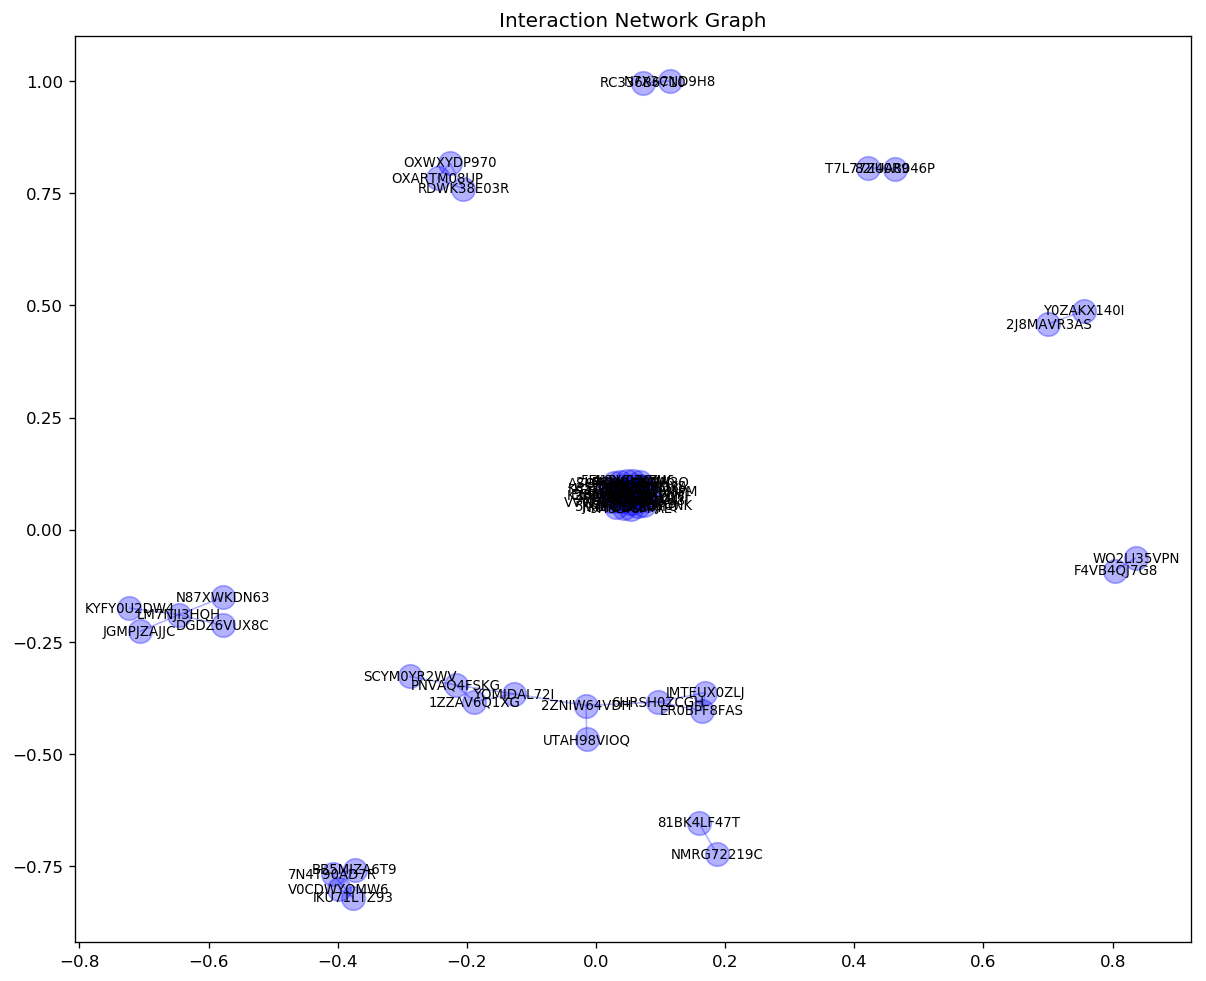

In [49]:
# plot the graph with filtered interactions 
graph=nx.from_pandas_edgelist(m2m_edges_count, "member1", "member2", "t_count")
fig = plt.figure(figsize=(12,10), dpi=120)
plt.title("Interaction Network Graph")
draw_graph(graph, graph_layout="spring",node_size=200)
plt.show()

c:\users\yumen\anaconda3\envs\py2\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
c:\users\yumen\anaconda3\envs\py2\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


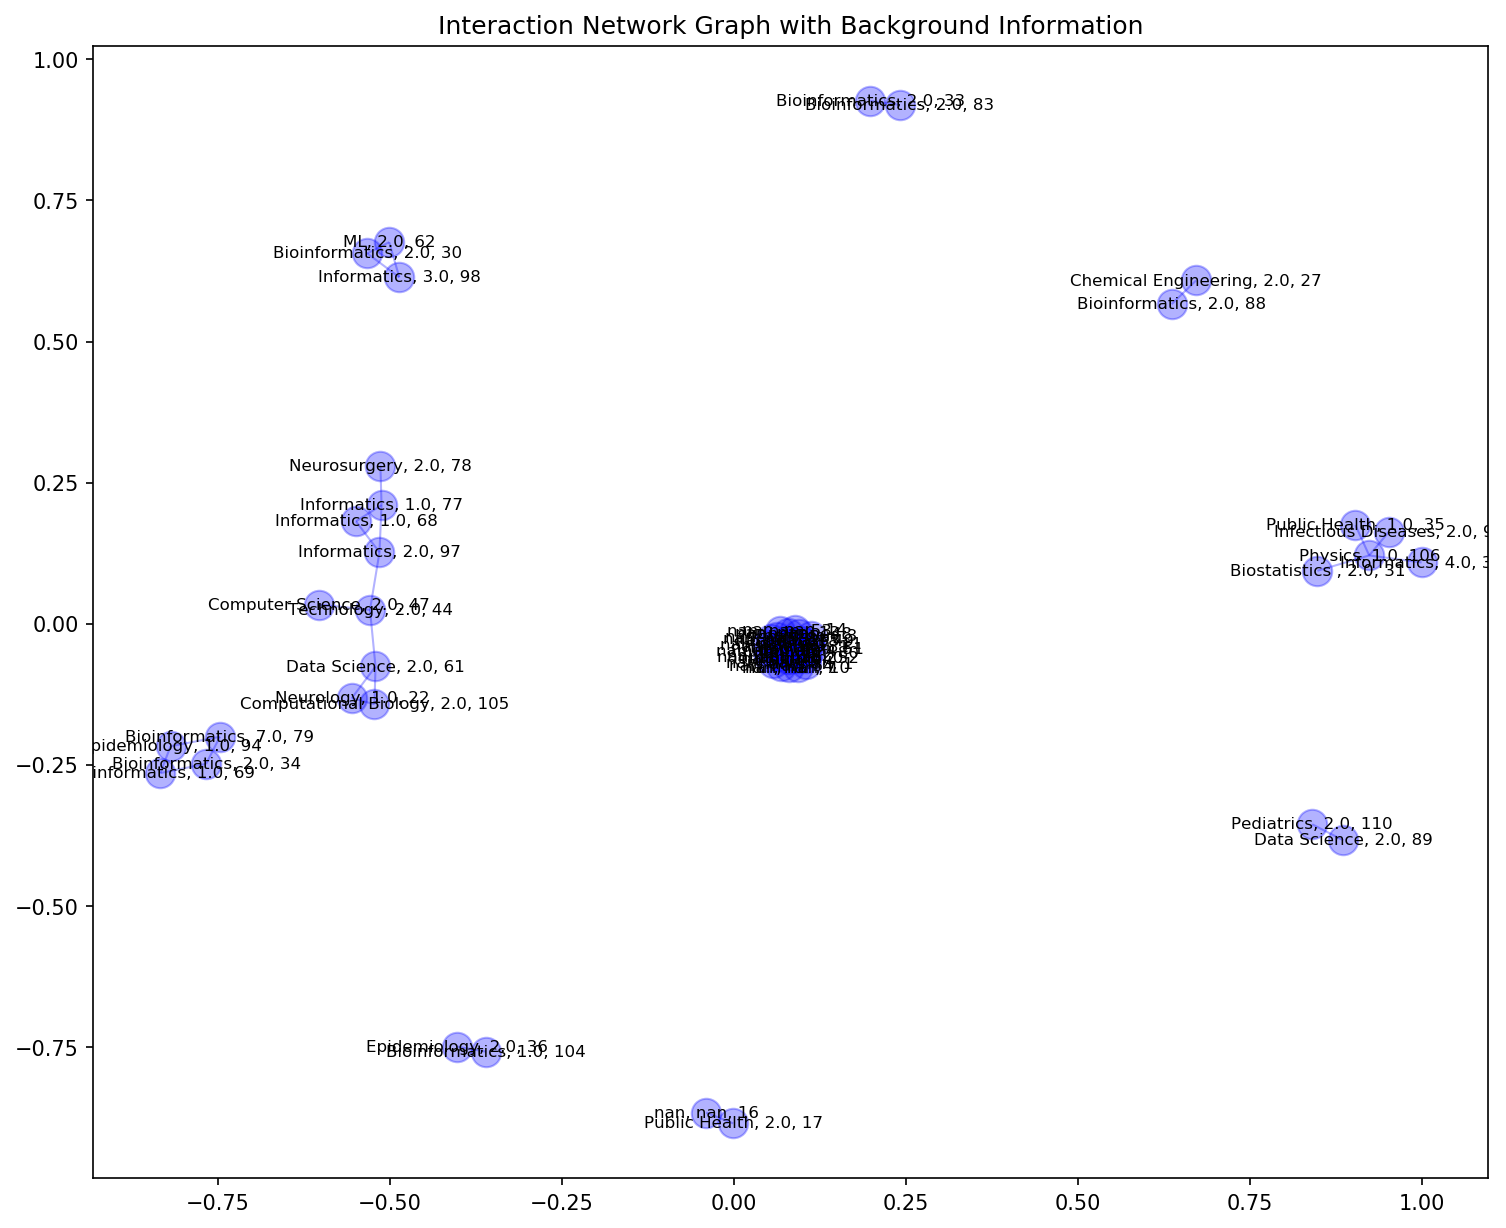

In [50]:
# incorporate background information into the dynamic graph

# read member background data  
attendees_metadata_filename = "Badge assignments_Attendees_2019.xlsx"
attendees_metadata = pd.read_excel(data_dir+attendees_metadata_filename)
background = pd.DataFrame(columns=['name','badge','background','affiliation'])
background_affiliation = pd.DataFrame(columns=['name','badge','background','affiliation'])
members_metadata = pd.read_csv(data_dir+members_metadata_filename)
background['name'] = members_metadata['member']
background['badge'] = members_metadata['BADGE IP']
for i in background['badge']:
    if i in attendees_metadata['BADGE IP'].values:
        a = background.loc[background['badge'] == i]
        b = attendees_metadata.loc[attendees_metadata['BADGE IP']==i]
        a['background'] = b['Cleaned Primary discipline/field of interest'].values
        a['affiliation'] = b['Affiliation'].values
        background_affiliation = pd.concat([background_affiliation, a])
    else:
        a = background.loc[background['badge']==i]
        background_affiliation = pd.concat([background_affiliation, a])
        

#create a dictionary for member id and background info
bg_dict = {}
for i in range(0,len(background_affiliation)):
    bg_dict.update({background_affiliation.loc[i,'name']: str(background_affiliation.loc[i,'background'])+", "+
                                                          str(background_affiliation.loc[i,'affiliation'])+", "+
                                                          str(i)})
    
#relabel the nodes with the background infomation
graph_bg = nx.relabel_nodes(graph,bg_dict)

# create the graph with filtered interactions 
fig = plt.figure(figsize=(12,10), dpi=150)
plt.title("Interaction Network Graph with Background Information")
draw_graph(graph_bg, graph_layout="spring",node_size=200)
plt.show()

# Interactive Interaction Finding Tool 
This tool helps find interaction between members in a certain amount of time with designated parameters, such as signal strength using the distribution of signal strength. These parameters can bu customized. 

To automatively choose a threshold for signal strength, the program analyzes the distribution of frequencies of signal strength and it will take the frequency of the peak -2. -2 for leave some room for fluctuation. 

R3JpZHNwZWNMYXlvdXQoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT0yLCBkZXNjcmlwdGlvbj11J1RpbWUgaW50ZXJ2YWw6ICcsIGxheW91dD1MYXlvdXQoZ3JpZF9hcmVhPXUnd2lkZ2V0MDDigKY=


You pressed the Draw graph! button!
The threshold we find from distribution is -71.0


c:\users\yumen\anaconda3\envs\py2\lib\site-packages\ipykernel_launcher.py:180: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\yumen\anaconda3\envs\py2\lib\site-packages\ipykernel_launcher.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


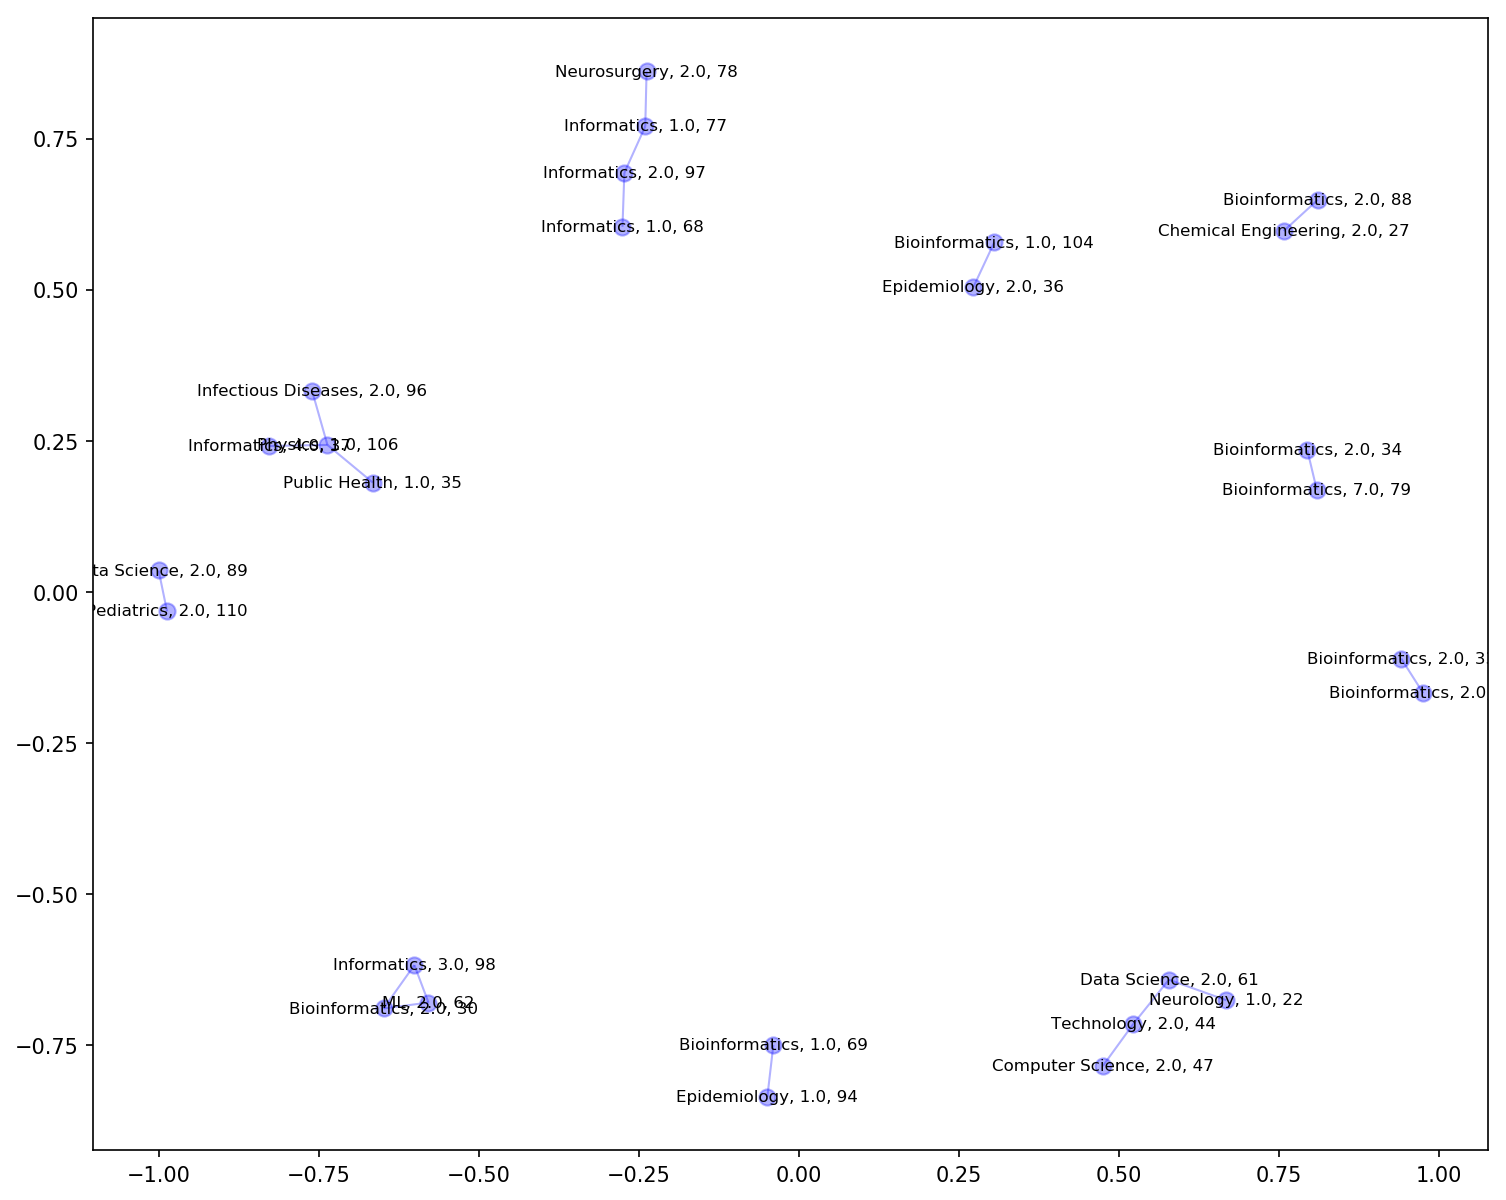

In [45]:
from ipywidgets import GridspecLayout,Layout,IntSlider,Button
from numpy import std


start_hr = IntSlider(min=7, max=14, value=9, description="Start hour: ",
                         layout=Layout(width='auto', height='auto')
                    )
start_min = IntSlider(min=0, max=59, value=50, description="Start min: ",
                         layout=Layout(width='auto', height='auto')
                     )
end_hr = IntSlider(min=7, max=14, value=11, description="End hour: ",
                         layout=Layout(width='auto', height='auto')
                  )
end_min = IntSlider(min=0, max=59, value=30,description="End min: ",
                         layout=Layout(width='auto', height='auto')
                   )
interval_threshold = IntSlider(min=2, max=10, value=2,description="Time interval: ",
                         layout=Layout(width='auto', height='auto')
                    )
time_count_threshold = IntSlider(min=0, max=90, value=2,description="Time count threshold: ",
                         layout=Layout(width='auto', height='auto')
                    )
app = GridspecLayout(3, 3, height='100px')

app[0,0]=start_hr
app[0,1]=start_min
app[0,2]=end_hr
app[1,0]=end_min
app[1,1]=interval_threshold
app[1,2]=time_count_threshold



def start_hr_change(change):
    time_interval_start_h=change['new']
    
def start_min_change(change):
    time_interval_start_h=change['new']
    
def end_hr_change(change):
    time_interval_start_h=change['new']
    
def end_min_change(change):
    time_interval_start_h=change['new']

def interval_threshold_change(change):
    interval=change['new']
    
def time_count_threshold_change(change):
    t_count_threshold=change['new']
    
start_hr.observe(start_hr_change, names='value')
start_min.observe(start_min_change, names='value')
end_hr.observe(end_hr_change, names='value')
end_min.observe(end_min_change, names='value')
interval_threshold.observe(interval_threshold_change, names='value')
time_count_threshold.observe(time_count_threshold_change, names='value')


draw_graph_button=Button(description='Draw graph!', button_style='info', layout=Layout(height='auto', width='auto'))
app[2,:]=draw_graph_button

display(app)



def draw_graph_button_click_handler(btn_object):
    print('You pressed the {} button!'.format(btn_object.description))
    time_interval_start_h=start_hr.value
    time_interval_start_m=start_min.value
    time_interval_end_h=end_hr.value
    time_interval_end_m=end_min.value
    interval=interval_threshold.value
    t_count_threshold=time_count_threshold.value
    bo1 = generate_time_points(time_interval_start_h, time_interval_start_m, 
                           time_interval_end_h, time_interval_end_m, interval)
    freq_list_1 = []
    for i in bo1:
        freq_list_1.append(tmp_m2ms.reset_index().set_index('datetime').loc[i])

    hist_list_1 = []
    for freq in freq_list_1:
        tmp_freq = []
        for row in freq.iterrows():
            tmp = [row[1][3]]*int(row[1][5])
            tmp_freq = tmp_freq + tmp
        hist_list_1.append(tmp_freq)


    vals = {}
    for i in range(len(hist_list_1)): 
        for j in hist_list_1[i]:
            if j not in vals.keys():
                vals[j]=1; 
            else: 
                vals[j]=vals[j]+1

   
    
    import copy
    vals_sorted = copy.deepcopy(sorted(vals.items(), key = 
                 lambda vals:(vals[1], vals[0]),reverse = True))
    sign_threshold = vals_sorted[2][0]
    print('The threshold we find from distribution is '+ str(sign_threshold))
    

    time_slices=generate_time_slices(time_interval_start_h,time_interval_start_m,time_interval_end_h,
                                     time_interval_end_m,interval)
    
    for i in range(1,len(time_slices)+1):
        time_slice = time_slices[i-1]
        m2m_breakout = tmp_m2ms_sorted.loc[time_slice]
        # keep only instances with strong signal
        m2m_filter_rssi = m2m_breakout[m2m_breakout.rssi >= sign_threshold].copy()
        # Count number of time members were in close proximity
        # We name the count column "weight" so that networkx will use it as weight for the spring layout
        m2m_edges = m2m_filter_rssi.groupby(['member1', 'member2'])[['rssi_weighted_mean']
                                                                   ].count().rename(columns={'rssi_weighted_mean':'weight'})
        m2m_edges = m2m_edges[["weight"]].reset_index()
        # Keep strongest edges (threshold set manually)
        m2m_edges = m2m_edges[m2m_edges.weight > interval/2]
        if i == 1: 
            m2m_edges_count = m2m_edges.copy().assign(t_count = [1 for x in range(1,len(m2m_edges['member1'])+1)])
            m2m_edges_count = m2m_edges_count.assign(appeared = [False for x in range(1,len(m2m_edges_count)+1)])
        else: 
            for h in range(1,len(m2m_edges['member1'])):        
                for j in range(1,len(m2m_edges_count['member1'])):
                    if m2m_edges.iloc[h,0]==m2m_edges_count.iloc[j,0] and m2m_edges.iloc[h,1]==m2m_edges_count.iloc[j,1]: 
                        m2m_edges_count.iloc[j,3]=m2m_edges_count.iloc[j,3]+1 
                        m2m_edges_count.iloc[j,4]=True
                    elif j==len(m2m_edges_count['member1']):
                        m2m_edges_count.append({'member1':m2m_edges.iloc[h,0],'member2':m2m_edges.iloc[h,1],
                                                'weight':m2m_edges.iloc[h,2],'t_count':m2m_edges.iloc[h,3],
                                               'appeared':True})
            for j in m2m_edges_count.index.values:            
                if m2m_edges_count.loc[j,'appeared']==False:
                    if m2m_edges_count.loc[j,'t_count']<t_count_threshold: 
                        m2m_edges_count.drop(j,inplace=True)
                else: 
                    m2m_edges_count.loc[j,'appeared']=False

    
    graph=nx.from_pandas_edgelist(m2m_edges_count, "member1", "member2", "t_count")
    

    # incorporate background information into the dynamic graph

    # read member background data  
    attendees_metadata_filename = "Badge assignments_Attendees_2019.xlsx"
    attendees_metadata = pd.read_excel(data_dir+attendees_metadata_filename)
    background = pd.DataFrame(columns=['name','badge','background','affiliation'])
    background_affiliation = pd.DataFrame(columns=['name','badge','background','affiliation'])
    members_metadata = pd.read_csv(data_dir+members_metadata_filename)
    background['name'] = members_metadata['member']
    background['badge'] = members_metadata['BADGE IP']
    for i in background['badge']:
        if i in attendees_metadata['BADGE IP'].values:
            a = background.loc[background['badge'] == i]
            b = attendees_metadata.loc[attendees_metadata['BADGE IP']==i]
            a['background'] = b['Cleaned Primary discipline/field of interest'].values
            a['affiliation'] = b['Affiliation'].values
            background_affiliation = pd.concat([background_affiliation, a])
        else:
            a = background.loc[background['badge']==i]
            background_affiliation = pd.concat([background_affiliation, a])


    #create a dictionary for member id and background info
    bg_dict = {}
    for i in range(0,len(background_affiliation)):
        bg_dict.update({background_affiliation.loc[i,'name']: str(background_affiliation.loc[i,'background'])+", "+
                                                              str(background_affiliation.loc[i,'affiliation'])+", "+
                                                              str(i)})

    #relabel the nodes with the background infomation
    graph_bg = nx.relabel_nodes(graph,bg_dict)

    # create the graph with filtered interactions 
    fig = plt.figure(figsize=(12,10), dpi=150)
    plt.title("Interaction Network Graph with Background")
    draw_graph(graph_bg, graph_layout="spring",node_size=400)
    plt.show()
    
    
draw_graph_button.on_click(draw_graph_button_click_handler)
